In [1]:
import sys
import torch
from torch.nn import MSELoss
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable
from torch_geometric_temporal.signal import temporal_signal_split
sys.path.append('../../model/geometric_temporal/')
sys.path.append('../../dataset/')
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from recurrent import LSTMGCNModel
from gdelt_dataset import GDELTDatasetLoader
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
seed = torch.random.manual_seed(52)

In [3]:
loader = GDELTDatasetLoader('../../data/dataset/gdelt_data_2.pkl', 1000)
dataset = loader.get_dataset()

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [5]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [6]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 7)

optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

model.train()

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        max_x = torch.nan_to_num(snapshot.x).max()
        X = torch.div(snapshot.x, max_x + 1)
        X = torch.clamp(X, 10e-5, 10e3)
        X = torch.nan_to_num(X)
        
        max_w = torch.nan_to_num(snapshot.edge_attr).max()
        W = torch.div(snapshot.edge_attr, max_w + 1)
        W = torch.clamp(W, 10e-5, 100)
        W = torch.nan_to_num(W)
        
        y_hat = model(X, snapshot.edge_index, W)
        y_hat = torch.sum(torch.mul(y_hat[snapshot.edge_index[0]], y_hat[snapshot.edge_index[1]]), 1)
        
#         y_hat = torch.mm(y_hat, y_hat.T)
        y_true = torch.diagonal(snapshot.y[snapshot.edge_index[0]][:, snapshot.edge_index[1]])
        cost = cost + torch.mean((y_hat-y_true)**2)
    cost = cost / (time+1)
    print(f'Cost: {cost}')
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Cost: 15.11224365234375


  1%|▊                                                                                 | 1/100 [00:07<12:48,  7.77s/it]

Cost: 15.050833702087402


  2%|█▋                                                                                | 2/100 [00:17<14:05,  8.63s/it]

Cost: 14.9729585647583


  3%|██▍                                                                               | 3/100 [00:26<14:29,  8.96s/it]

Cost: 14.866510391235352


  4%|███▎                                                                              | 4/100 [00:35<14:41,  9.19s/it]

Cost: 14.725057601928711


  5%|████                                                                              | 5/100 [00:45<14:40,  9.27s/it]

Cost: 14.541668891906738


  6%|████▉                                                                             | 6/100 [00:54<14:34,  9.31s/it]

Cost: 14.309309959411621


  7%|█████▋                                                                            | 7/100 [01:04<14:27,  9.33s/it]

Cost: 14.02105712890625


  8%|██████▌                                                                           | 8/100 [01:14<14:46,  9.64s/it]

Cost: 13.6713285446167


  9%|███████▍                                                                          | 9/100 [01:23<14:33,  9.60s/it]

Cost: 13.257375717163086


 10%|████████                                                                         | 10/100 [01:33<14:19,  9.55s/it]

Cost: 12.781230926513672


 11%|████████▉                                                                        | 11/100 [01:42<14:09,  9.55s/it]

Cost: 12.250027656555176


 12%|█████████▋                                                                       | 12/100 [01:52<13:49,  9.43s/it]

Cost: 11.691490173339844


 13%|██████████▌                                                                      | 13/100 [02:01<13:37,  9.40s/it]

Cost: 11.153295516967773


 14%|███████████▎                                                                     | 14/100 [02:10<13:31,  9.43s/it]

Cost: 10.722320556640625


 15%|████████████▏                                                                    | 15/100 [02:20<13:34,  9.58s/it]

Cost: 10.524413108825684


 16%|████████████▉                                                                    | 16/100 [02:30<13:26,  9.60s/it]

Cost: 10.678235054016113


 17%|█████████████▊                                                                   | 17/100 [02:40<13:26,  9.72s/it]

Cost: 11.068892478942871


 18%|██████████████▌                                                                  | 18/100 [02:50<13:15,  9.70s/it]

Cost: 11.313236236572266


 19%|███████████████▍                                                                 | 19/100 [02:59<13:07,  9.73s/it]

Cost: 11.264422416687012


 20%|████████████████▏                                                                | 20/100 [03:09<12:50,  9.64s/it]

Cost: 11.036063194274902


 21%|█████████████████                                                                | 21/100 [03:18<12:28,  9.48s/it]

Cost: 10.780479431152344


 22%|█████████████████▊                                                               | 22/100 [03:28<12:38,  9.72s/it]

Cost: 10.595297813415527


 23%|██████████████████▋                                                              | 23/100 [03:38<12:27,  9.71s/it]

Cost: 10.511519432067871


 24%|███████████████████▍                                                             | 24/100 [03:47<12:13,  9.65s/it]

Cost: 10.513405799865723


 25%|████████████████████▎                                                            | 25/100 [03:56<11:46,  9.42s/it]

Cost: 10.564502716064453


 26%|█████████████████████                                                            | 26/100 [04:05<11:22,  9.22s/it]

Cost: 10.631121635437012


 27%|█████████████████████▊                                                           | 27/100 [04:14<10:59,  9.03s/it]

Cost: 10.689306259155273


 28%|██████████████████████▋                                                          | 28/100 [04:22<10:35,  8.82s/it]

Cost: 10.72543716430664


 29%|███████████████████████▍                                                         | 29/100 [04:31<10:29,  8.87s/it]

Cost: 10.734325408935547


 30%|████████████████████████▎                                                        | 30/100 [04:40<10:18,  8.84s/it]

Cost: 10.716896057128906


 31%|█████████████████████████                                                        | 31/100 [04:48<10:05,  8.78s/it]

Cost: 10.678306579589844


 32%|█████████████████████████▉                                                       | 32/100 [04:57<09:49,  8.66s/it]

Cost: 10.626664161682129


 33%|██████████████████████████▋                                                      | 33/100 [05:05<09:37,  8.62s/it]

Cost: 10.571907997131348


 34%|███████████████████████████▌                                                     | 34/100 [05:14<09:27,  8.60s/it]

Cost: 10.524423599243164


 35%|████████████████████████████▎                                                    | 35/100 [05:22<09:18,  8.60s/it]

Cost: 10.493199348449707


 36%|█████████████████████████████▏                                                   | 36/100 [05:31<09:19,  8.74s/it]

Cost: 10.483338356018066


 37%|█████████████████████████████▉                                                   | 37/100 [05:42<09:44,  9.27s/it]

Cost: 10.493935585021973


 38%|██████████████████████████████▊                                                  | 38/100 [05:55<10:40, 10.32s/it]

Cost: 10.517359733581543


 39%|███████████████████████████████▌                                                 | 39/100 [06:09<11:34, 11.38s/it]

Cost: 10.541635513305664


 40%|████████████████████████████████▍                                                | 40/100 [06:21<11:49, 11.83s/it]

Cost: 10.555431365966797


 41%|█████████████████████████████████▏                                               | 41/100 [06:34<11:56, 12.14s/it]

Cost: 10.553140640258789


 42%|██████████████████████████████████                                               | 42/100 [06:48<12:18, 12.73s/it]

Cost: 10.536725997924805


 43%|██████████████████████████████████▊                                              | 43/100 [07:01<12:07, 12.76s/it]

Cost: 10.5136137008667


 44%|███████████████████████████████████▋                                             | 44/100 [07:14<12:00, 12.86s/it]

Cost: 10.492265701293945


 45%|████████████████████████████████████▍                                            | 45/100 [07:27<11:43, 12.80s/it]

Cost: 10.478620529174805


 46%|█████████████████████████████████████▎                                           | 46/100 [07:40<11:35, 12.88s/it]

Cost: 10.474456787109375


 47%|██████████████████████████████████████                                           | 47/100 [07:56<12:10, 13.79s/it]

Cost: 10.478065490722656


 48%|██████████████████████████████████████▉                                          | 48/100 [08:10<11:58, 13.81s/it]

Cost: 10.485712051391602


 49%|███████████████████████████████████████▋                                         | 49/100 [08:24<11:44, 13.82s/it]

Cost: 10.493433952331543


 50%|████████████████████████████████████████▌                                        | 50/100 [08:37<11:18, 13.57s/it]

Cost: 10.498212814331055


 51%|█████████████████████████████████████████▎                                       | 51/100 [08:50<11:08, 13.63s/it]

Cost: 10.498558044433594


 52%|██████████████████████████████████████████                                       | 52/100 [09:04<10:53, 13.61s/it]

Cost: 10.494571685791016


 53%|██████████████████████████████████████████▉                                      | 53/100 [09:20<11:11, 14.29s/it]

Cost: 10.48762321472168


 54%|███████████████████████████████████████████▋                                     | 54/100 [09:34<10:55, 14.26s/it]

Cost: 10.479850769042969


 55%|████████████████████████████████████████████▌                                    | 55/100 [09:50<11:09, 14.89s/it]

Cost: 10.473371505737305


 56%|█████████████████████████████████████████████▎                                   | 56/100 [10:07<11:23, 15.53s/it]

Cost: 10.469722747802734


 57%|██████████████████████████████████████████████▏                                  | 57/100 [10:23<11:03, 15.44s/it]

Cost: 10.46935749053955


 58%|██████████████████████████████████████████████▉                                  | 58/100 [10:38<10:52, 15.53s/it]

Cost: 10.471532821655273


 59%|███████████████████████████████████████████████▊                                 | 59/100 [10:55<10:45, 15.74s/it]

Cost: 10.474693298339844


 60%|████████████████████████████████████████████████▌                                | 60/100 [11:13<10:55, 16.39s/it]

Cost: 10.47709846496582


 61%|█████████████████████████████████████████████████▍                               | 61/100 [11:29<10:36, 16.31s/it]

Cost: 10.477596282958984


 62%|██████████████████████████████████████████████████▏                              | 62/100 [11:45<10:17, 16.26s/it]

Cost: 10.476004600524902


 63%|███████████████████████████████████████████████████                              | 63/100 [12:01<10:00, 16.22s/it]

Cost: 10.473052978515625


 64%|███████████████████████████████████████████████████▊                             | 64/100 [12:20<10:16, 17.11s/it]

Cost: 10.4699125289917


 65%|████████████████████████████████████████████████████▋                            | 65/100 [12:36<09:45, 16.72s/it]

Cost: 10.46761703491211


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [12:52<09:22, 16.54s/it]

Cost: 10.466662406921387


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [13:08<08:58, 16.31s/it]

Cost: 10.466988563537598


 68%|███████████████████████████████████████████████████████                          | 68/100 [13:26<08:57, 16.79s/it]

Cost: 10.468034744262695


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [13:41<08:29, 16.44s/it]

Cost: 10.469125747680664


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [13:56<07:55, 15.84s/it]

Cost: 10.469701766967773


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [14:12<07:41, 15.90s/it]

Cost: 10.469520568847656


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [14:27<07:14, 15.53s/it]

Cost: 10.468666076660156


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [14:43<07:06, 15.81s/it]

Cost: 10.467467308044434


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [14:56<06:30, 15.01s/it]

Cost: 10.466353416442871


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [15:04<05:23, 12.95s/it]

Cost: 10.465670585632324


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [15:12<04:33, 11.38s/it]

Cost: 10.465524673461914


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [15:19<03:48,  9.92s/it]

Cost: 10.465821266174316


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [15:25<03:14,  8.83s/it]

Cost: 10.466299057006836


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [15:32<02:54,  8.33s/it]

Cost: 10.466645240783691


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [15:40<02:43,  8.16s/it]

Cost: 10.466675758361816


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [15:47<02:29,  7.87s/it]

Cost: 10.46638298034668


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [15:54<02:19,  7.76s/it]

Cost: 10.465888977050781


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [16:01<02:05,  7.37s/it]

Cost: 10.465396881103516


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [16:07<01:53,  7.09s/it]

Cost: 10.46508502960205


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [16:13<01:41,  6.75s/it]

Cost: 10.46499252319336


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [16:19<01:30,  6.44s/it]

Cost: 10.46510124206543


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [16:26<01:24,  6.50s/it]

Cost: 10.46529769897461


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [16:33<01:20,  6.70s/it]

Cost: 10.465442657470703


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [16:38<01:09,  6.35s/it]

Cost: 10.465448379516602


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [16:44<01:01,  6.10s/it]

Cost: 10.46533489227295


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [16:49<00:52,  5.88s/it]

Cost: 10.465132713317871


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [16:55<00:46,  5.76s/it]

Cost: 10.46493148803711


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [17:00<00:39,  5.64s/it]

Cost: 10.464803695678711


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [17:05<00:33,  5.54s/it]

Cost: 10.464766502380371


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [17:11<00:27,  5.59s/it]

Cost: 10.464820861816406


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [17:17<00:22,  5.60s/it]

Cost: 10.46489143371582


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [17:22<00:16,  5.58s/it]

Cost: 10.46493911743164


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [17:27<00:10,  5.48s/it]

Cost: 10.464929580688477


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [17:33<00:05,  5.43s/it]

Cost: 10.464865684509277


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:39<00:00, 10.59s/it]


In [33]:
 with open('../../data/dataset/gdelt_data_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [37]:
country_names = data['node_ids']

In [44]:
data = None

In [46]:
def plot_confusion_matrix(y_hat, y_true):
    x_ticks = []
    for i, j in zip(snapshot.edge_index[0], snapshot.edge_index[1]):
        ci = list(country_names.keys())[list(country_names.values()).index(i)]
        cj = list(country_names.keys())[list(country_names.values()).index(j)]
        x_ticks.append(f'{ci}-{cj}')
    plt.figure(figsize=(30, 5))
    sns.heatmap([y_true.detach().numpy(), y_hat.detach().numpy()], annot=True, yticklabels=['True', 'Predicted'], xticklabels=x_ticks)
    plt.title('Confusion matrix')
    plt.show()

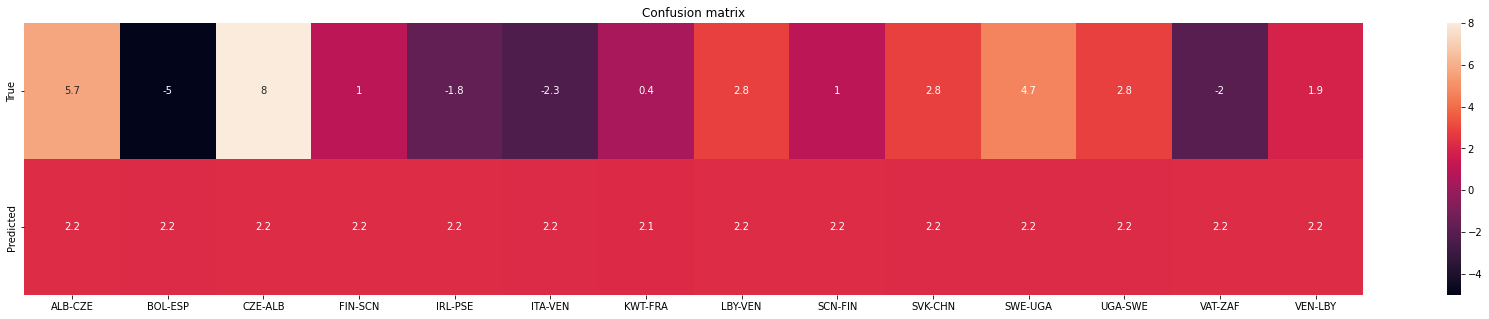

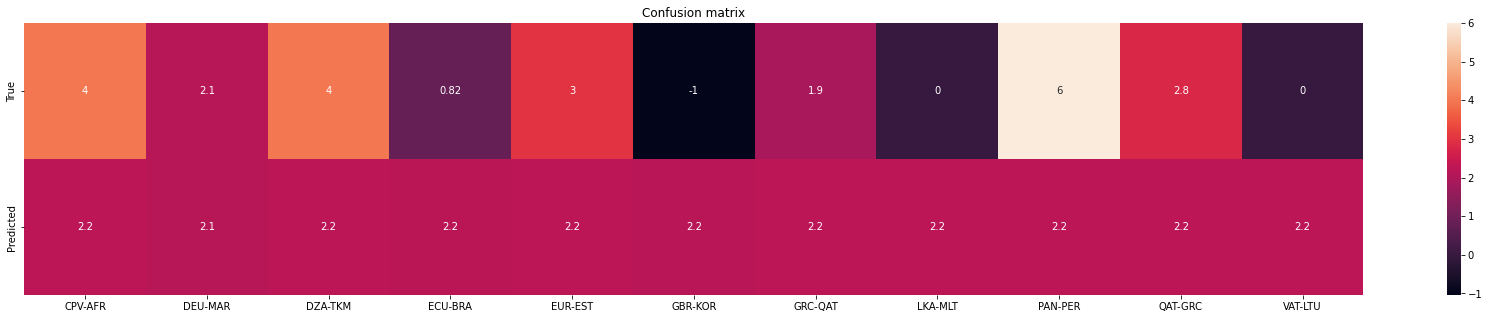

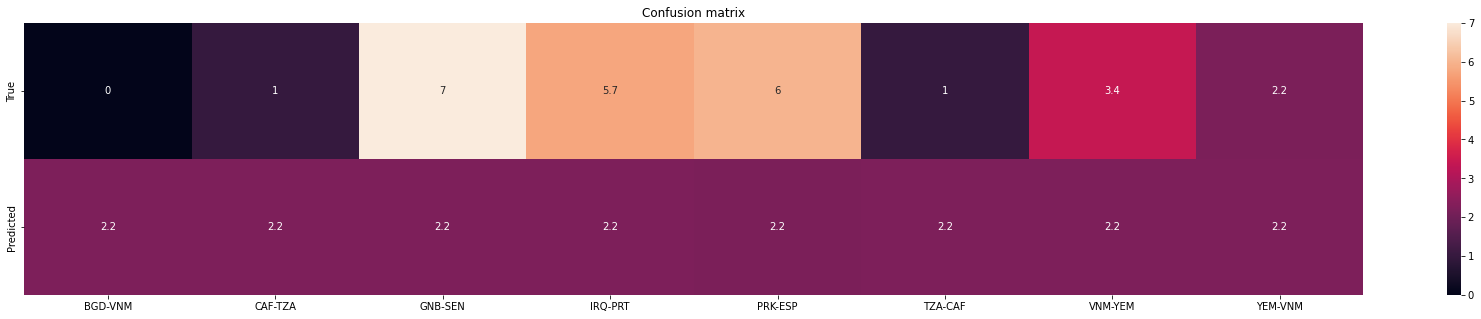

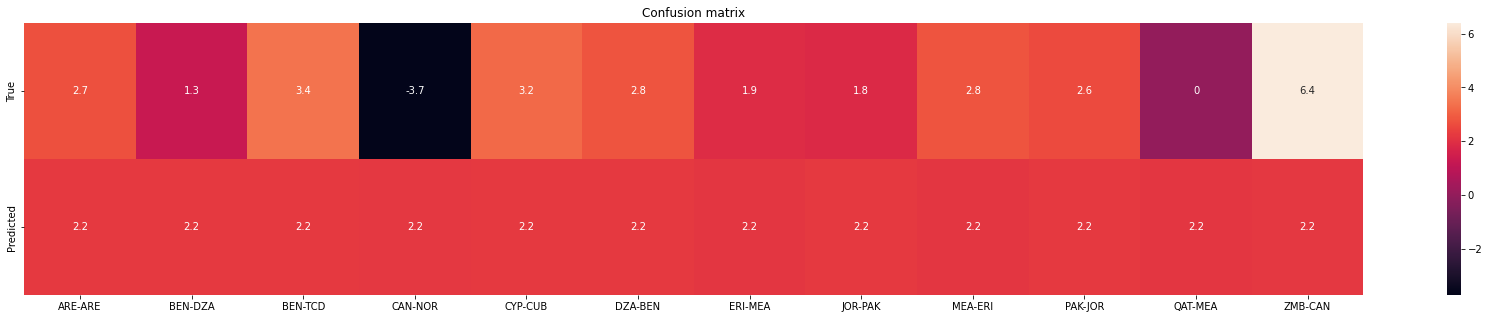

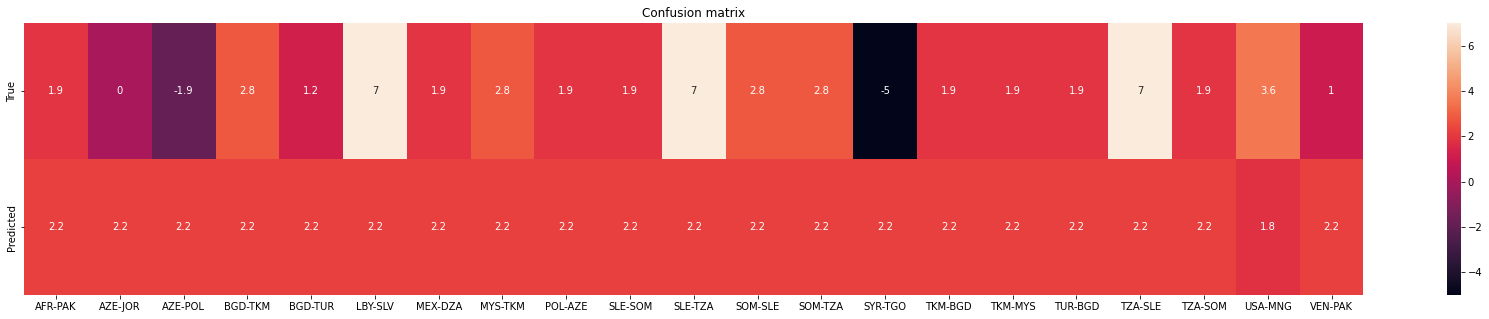

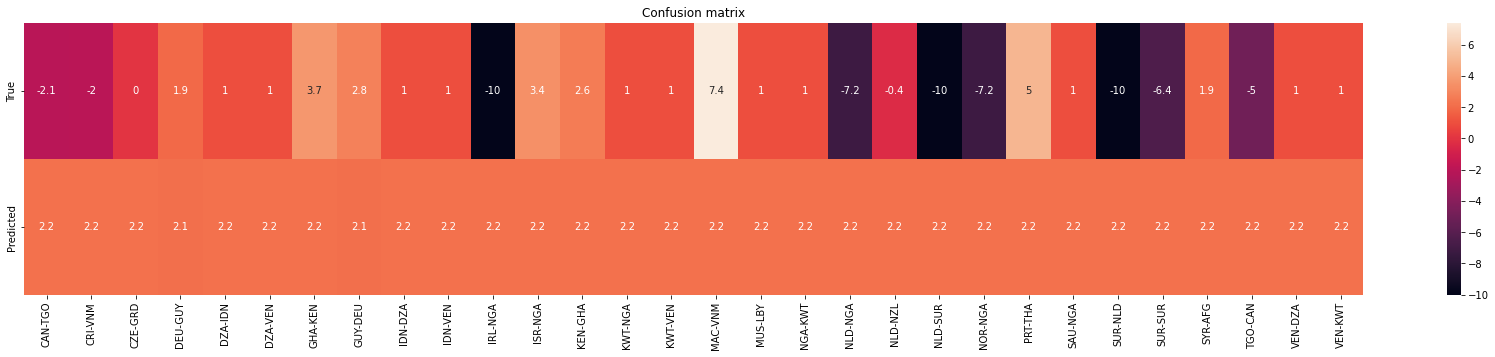

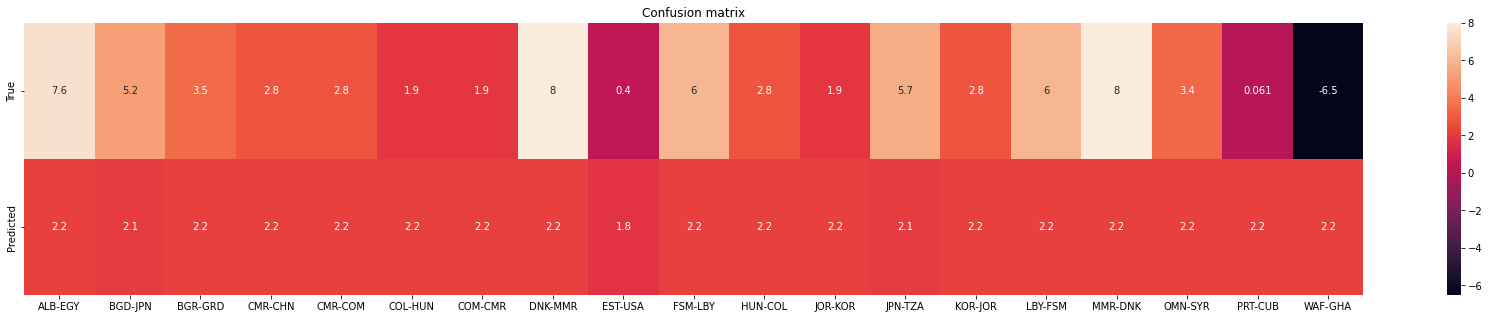

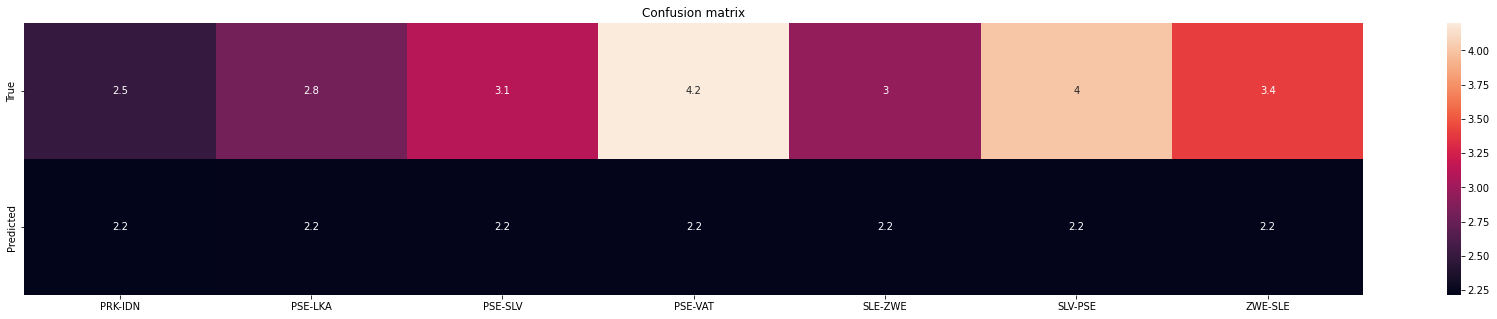

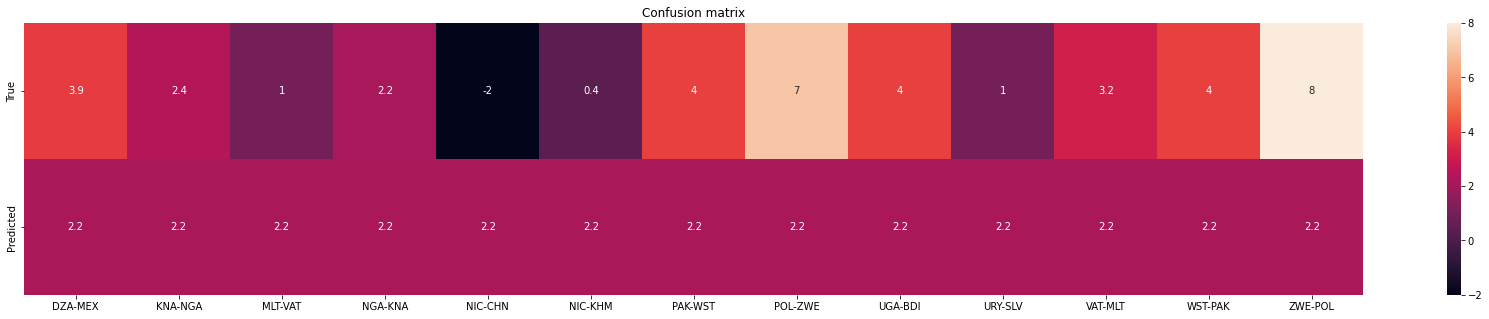

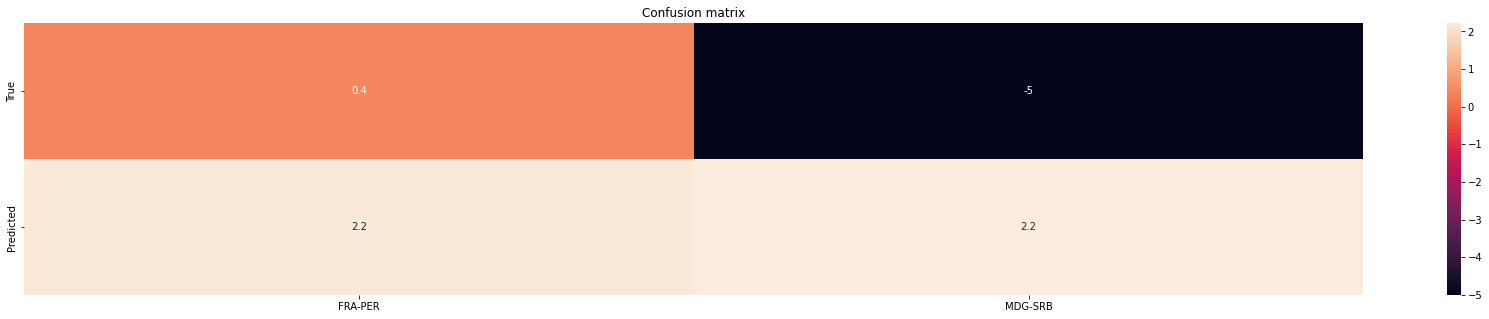

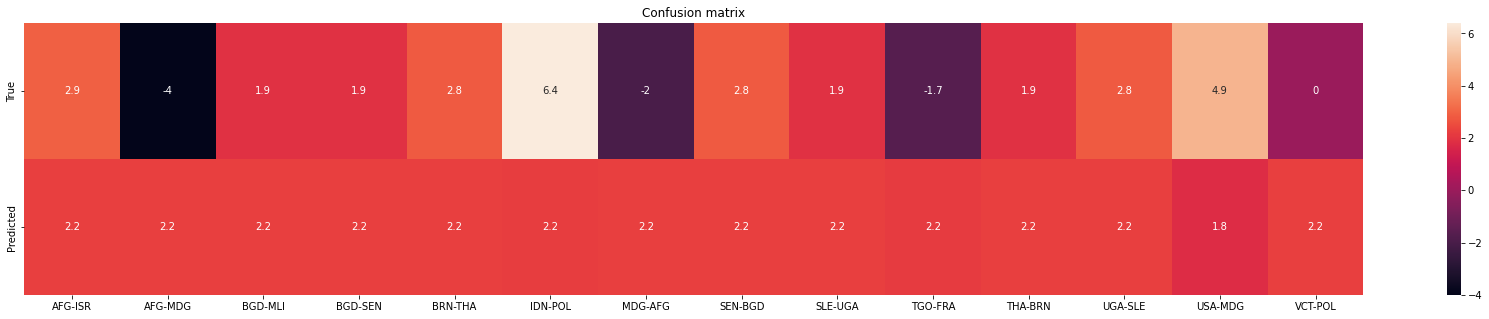

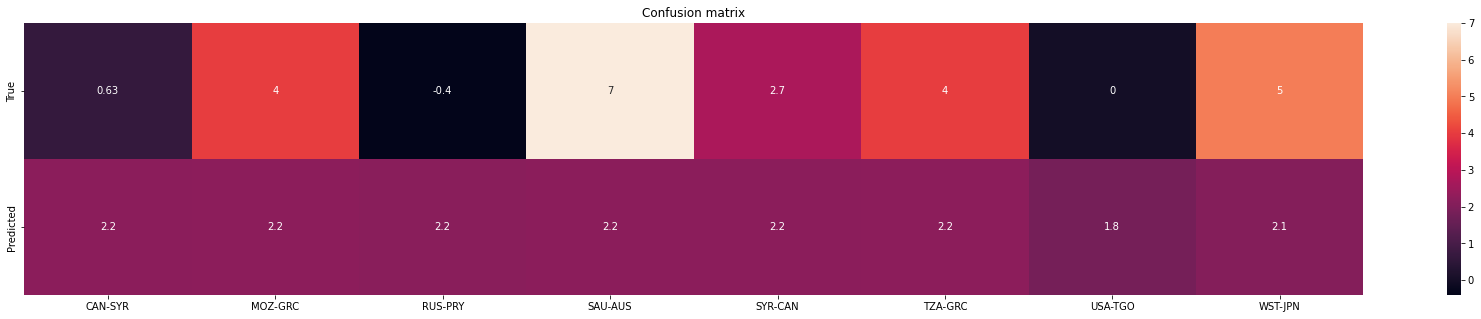

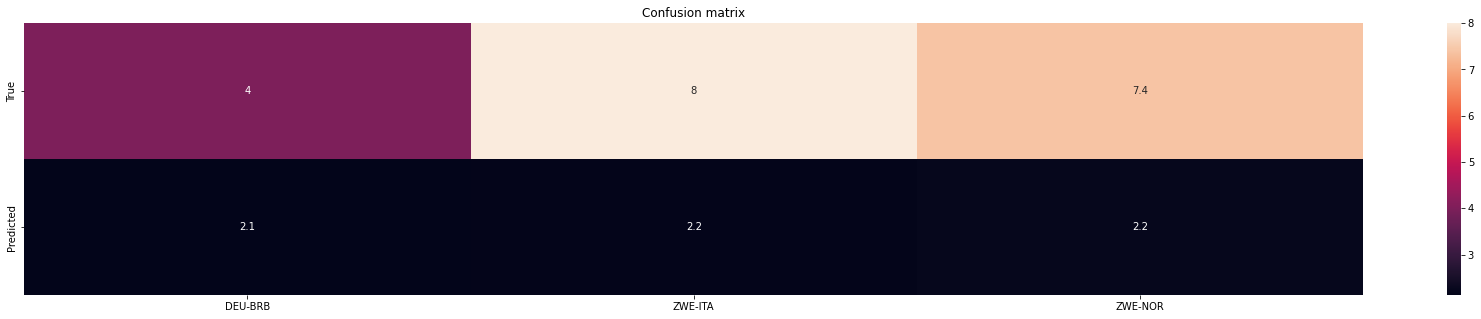

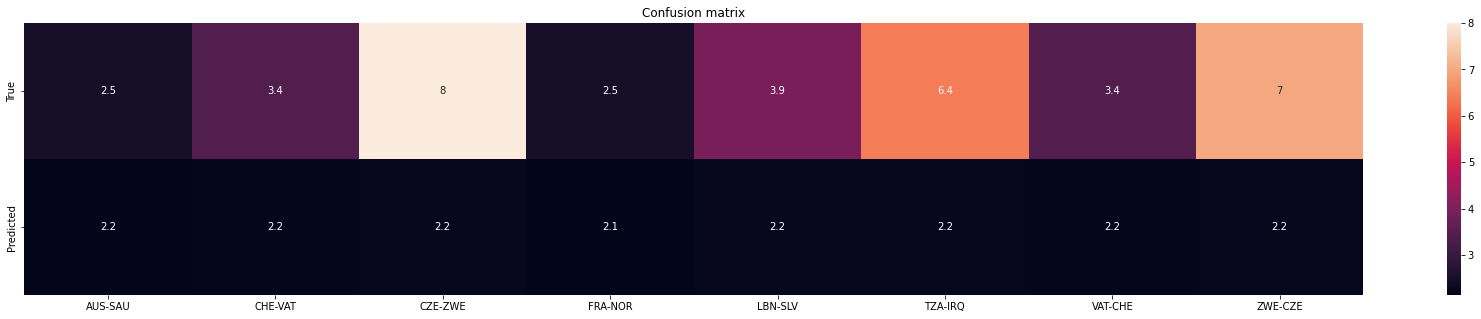

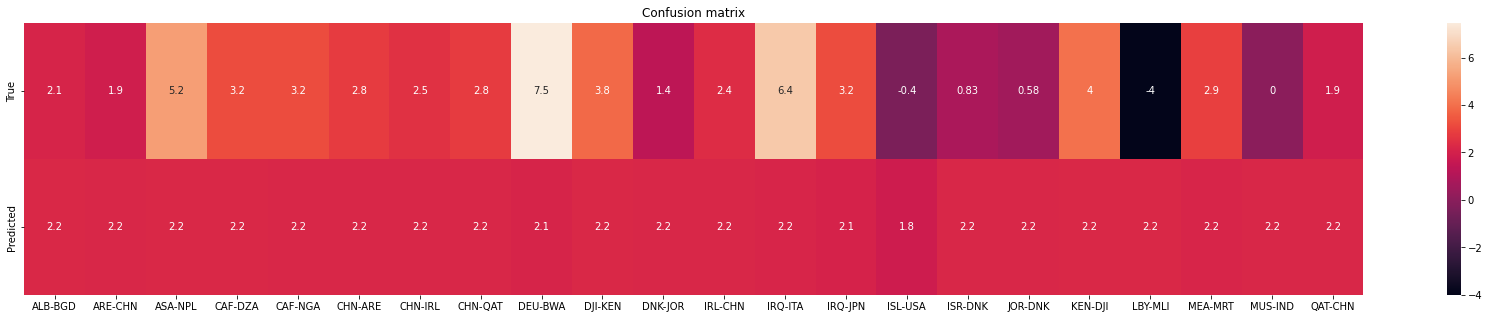

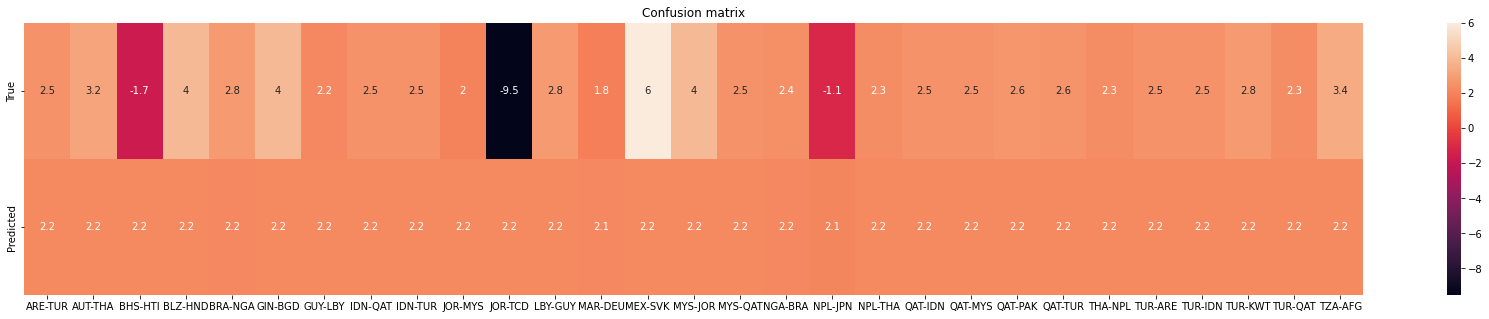

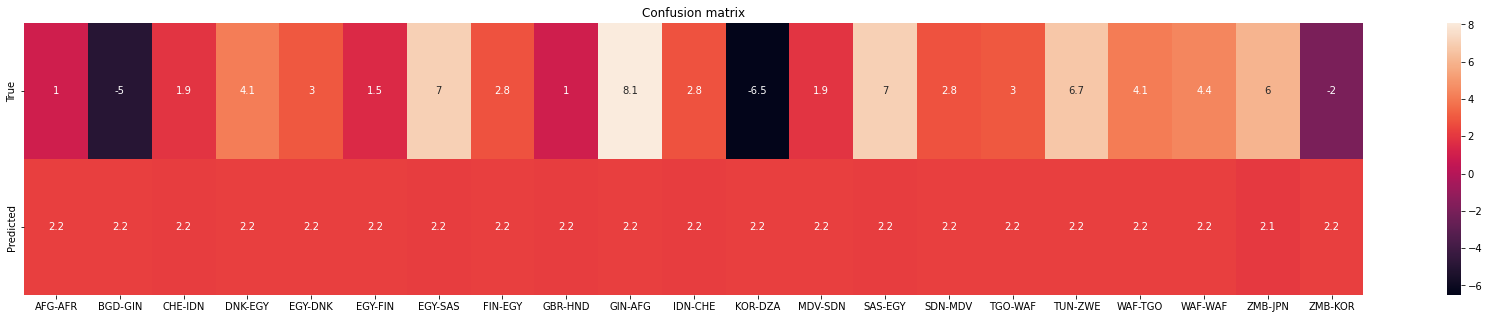

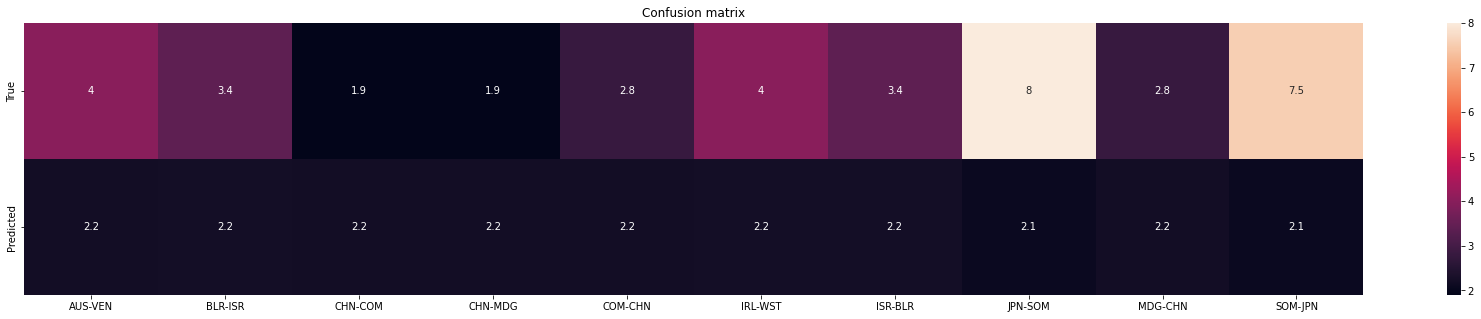

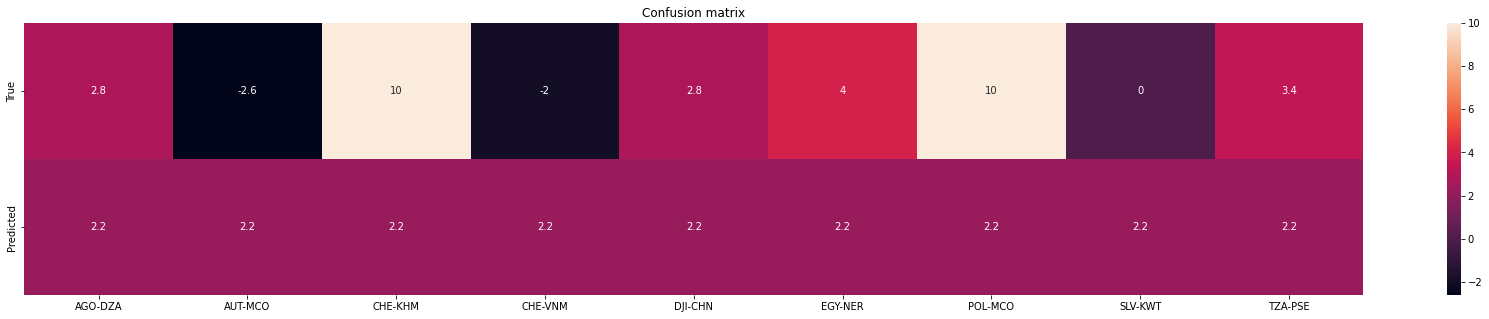

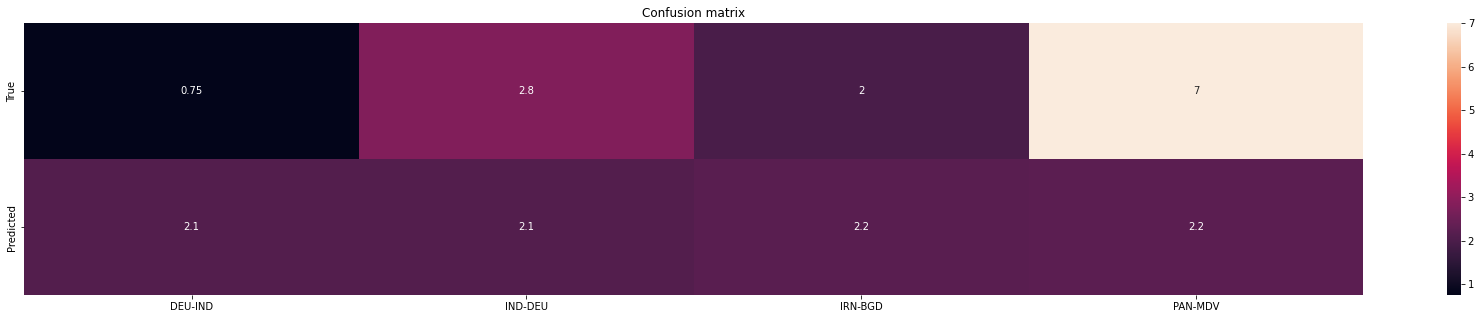

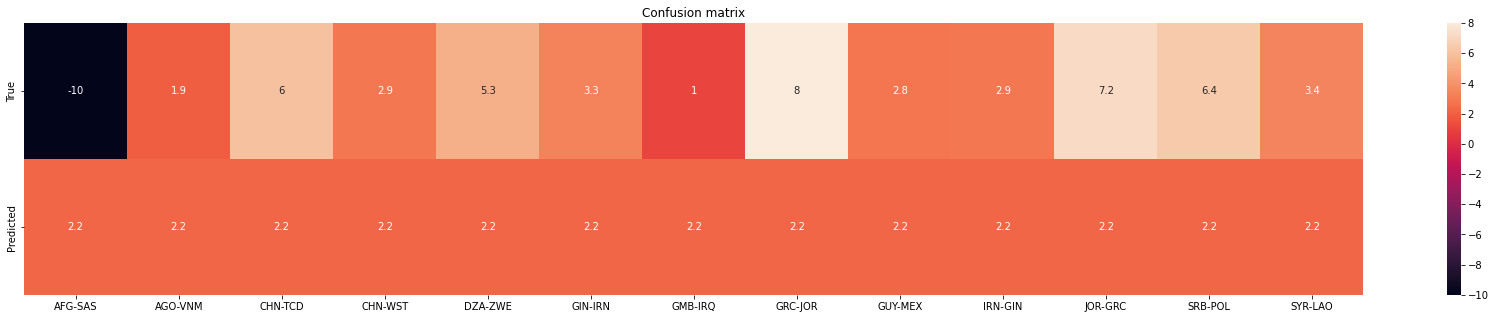

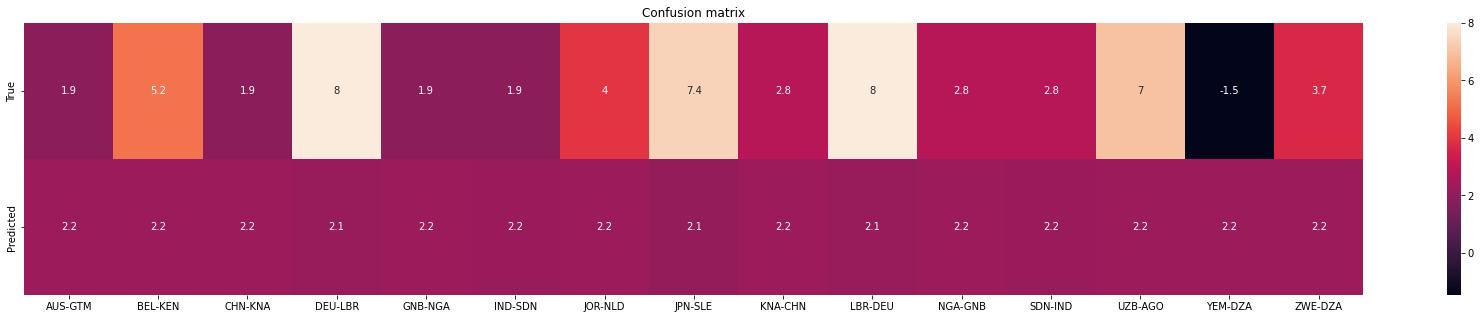

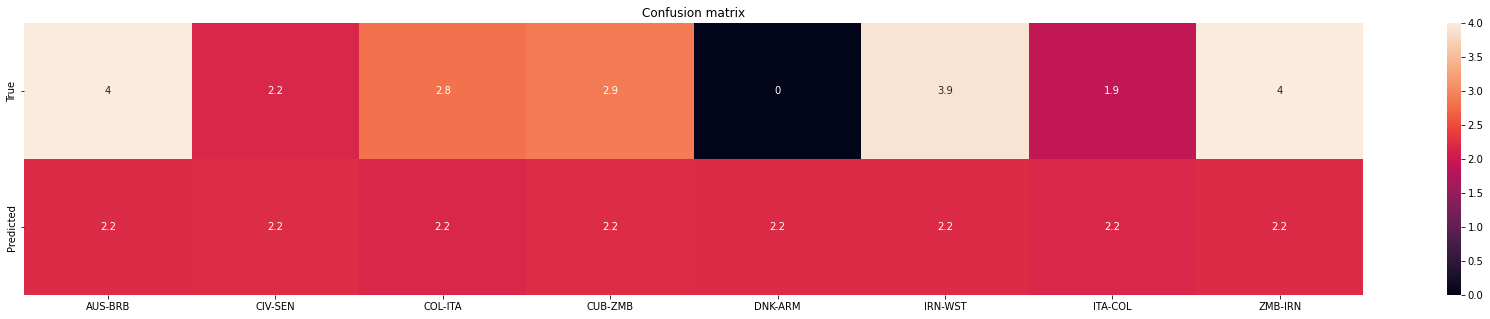

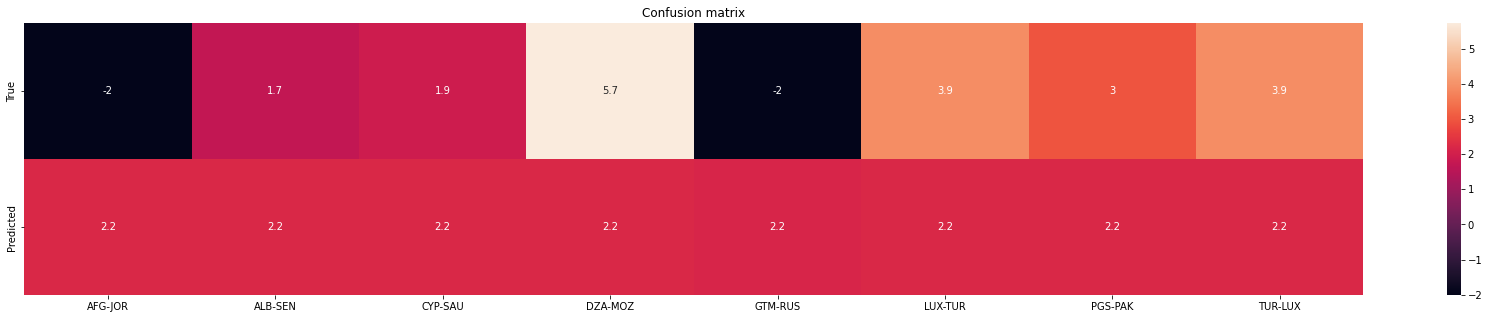

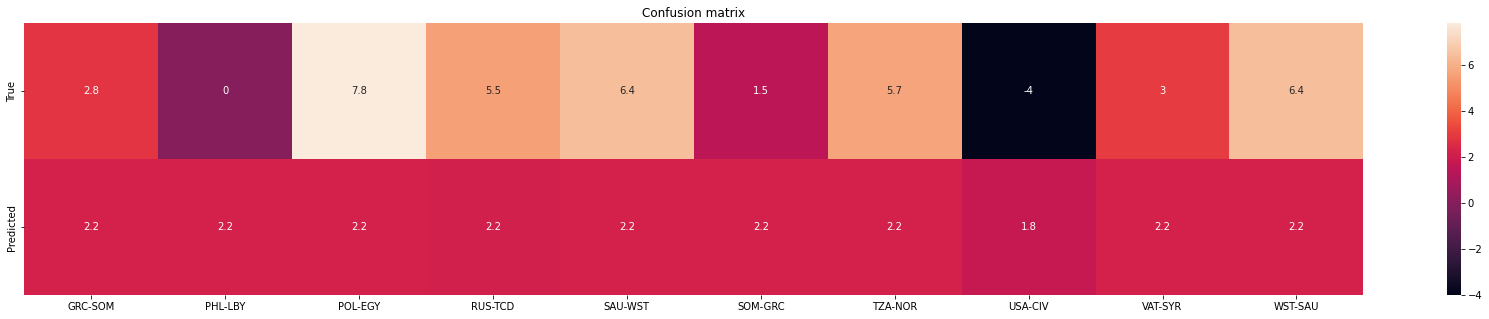

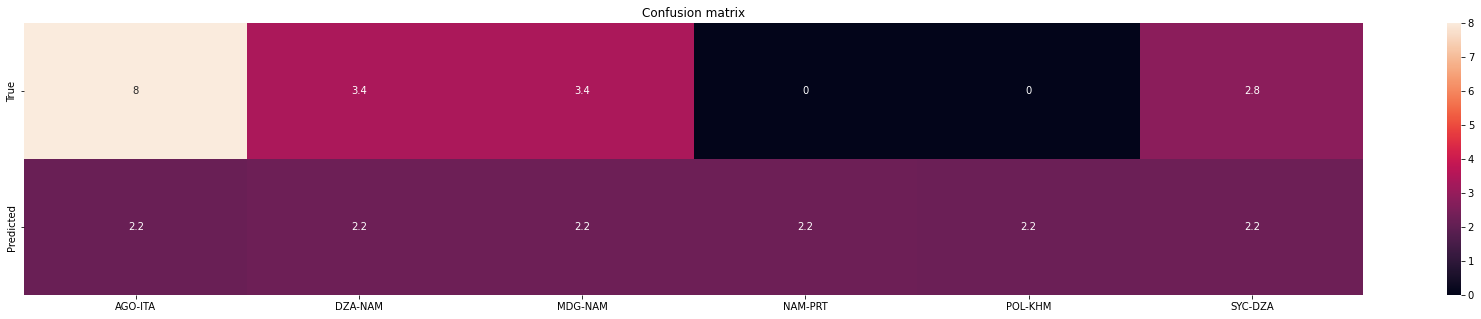

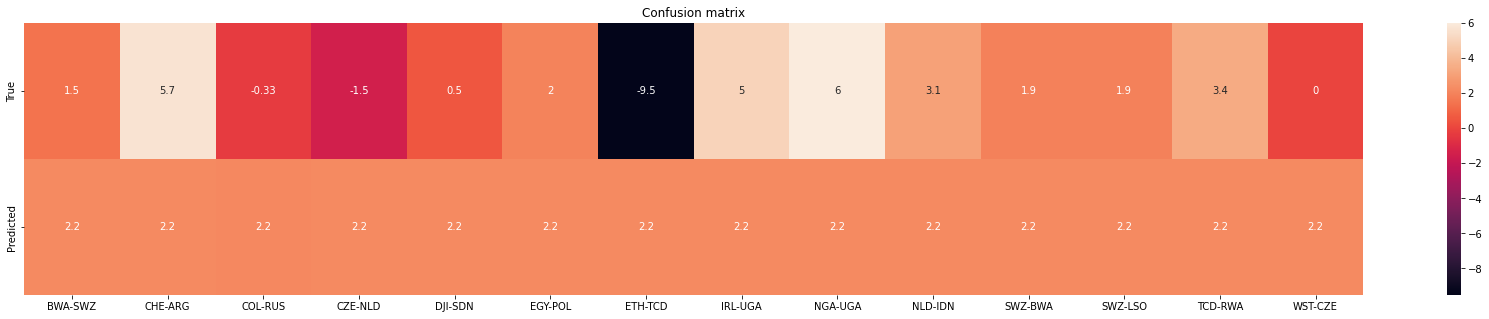

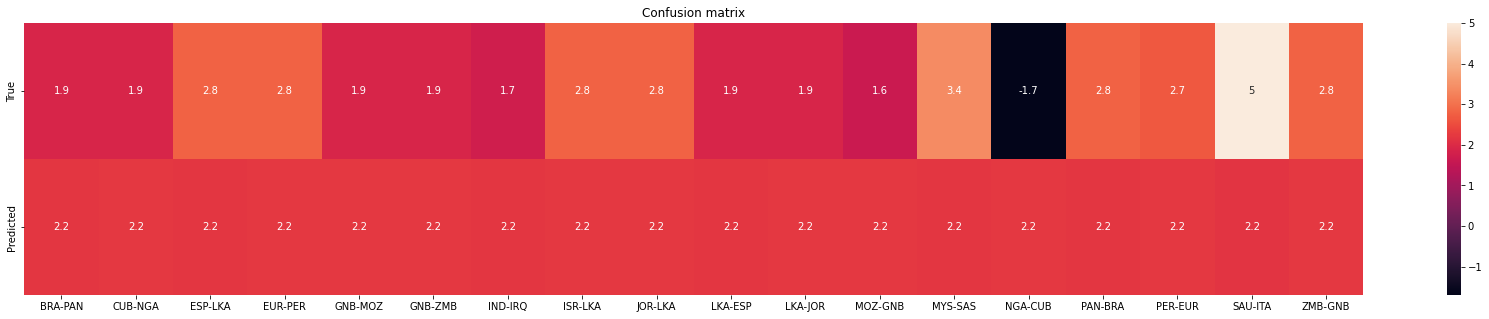

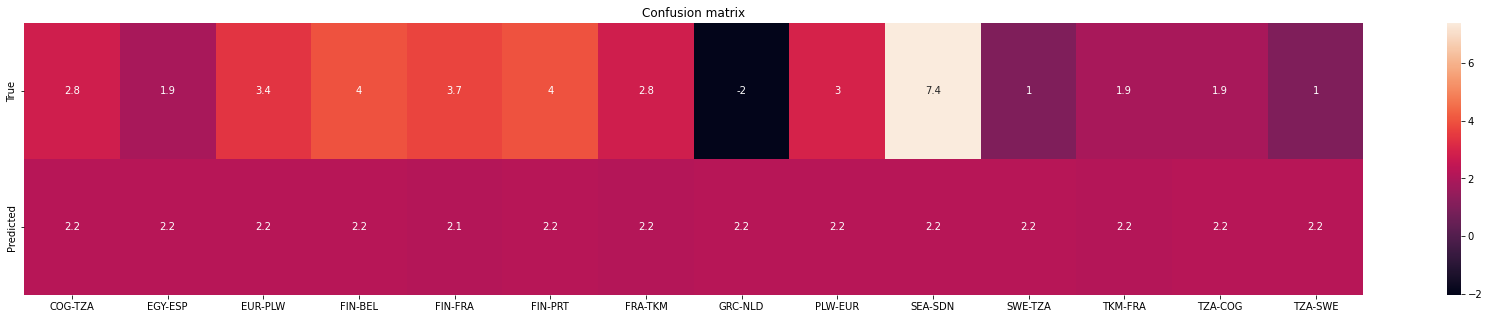

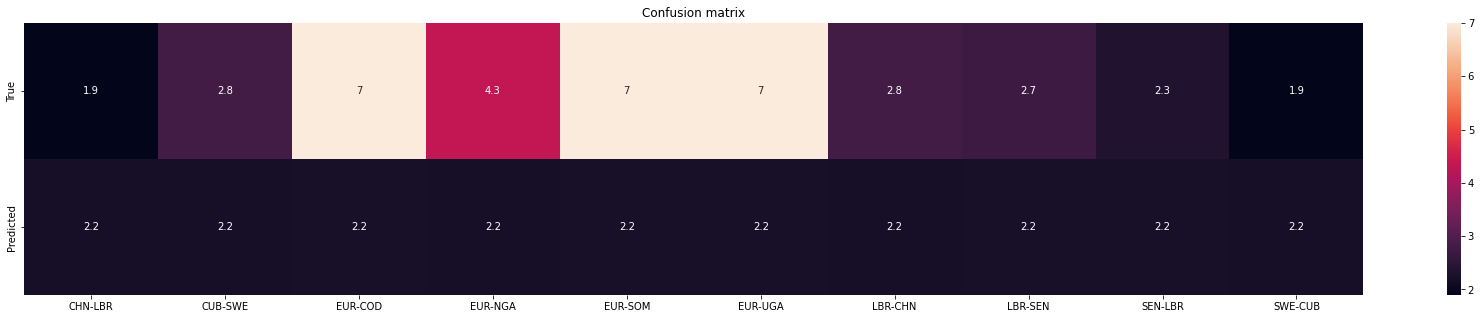

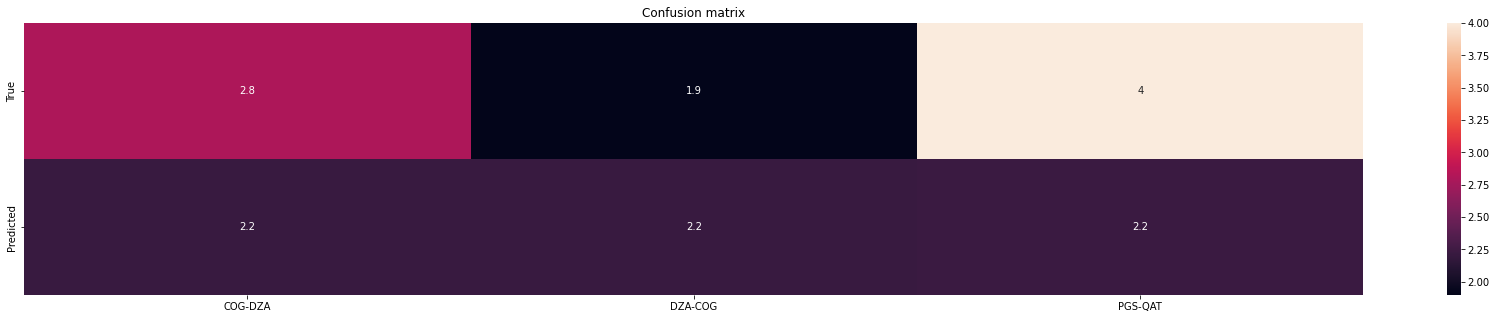

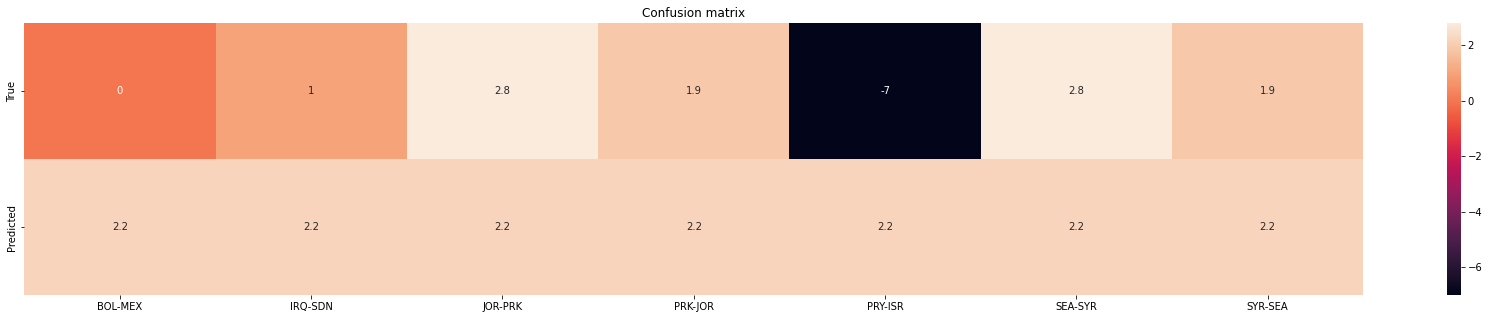

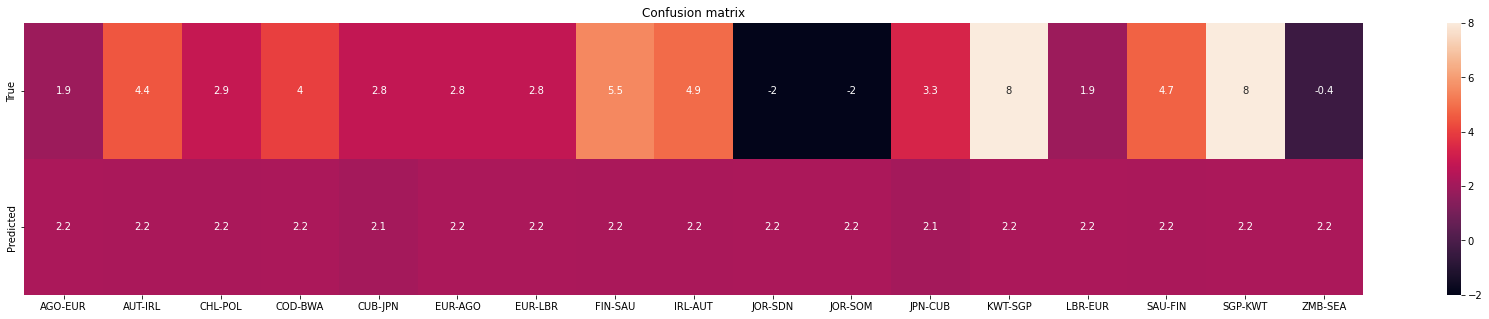

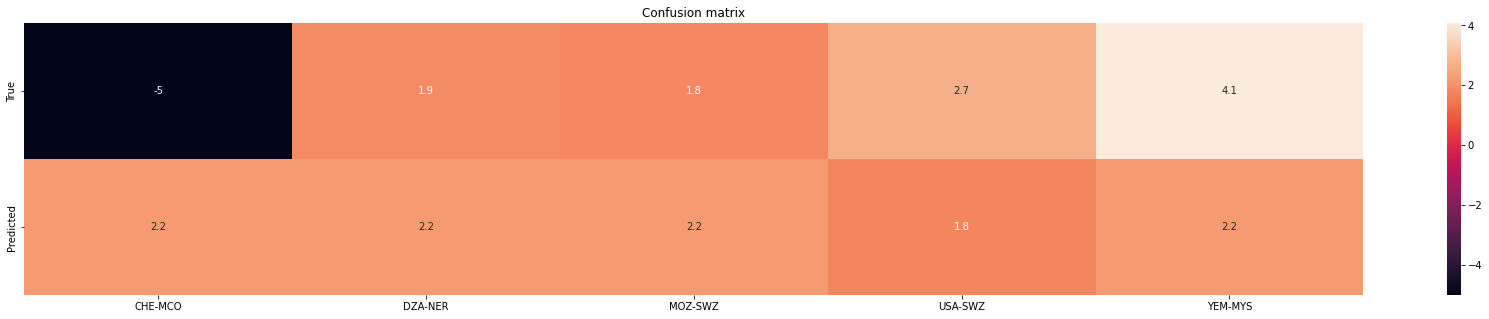

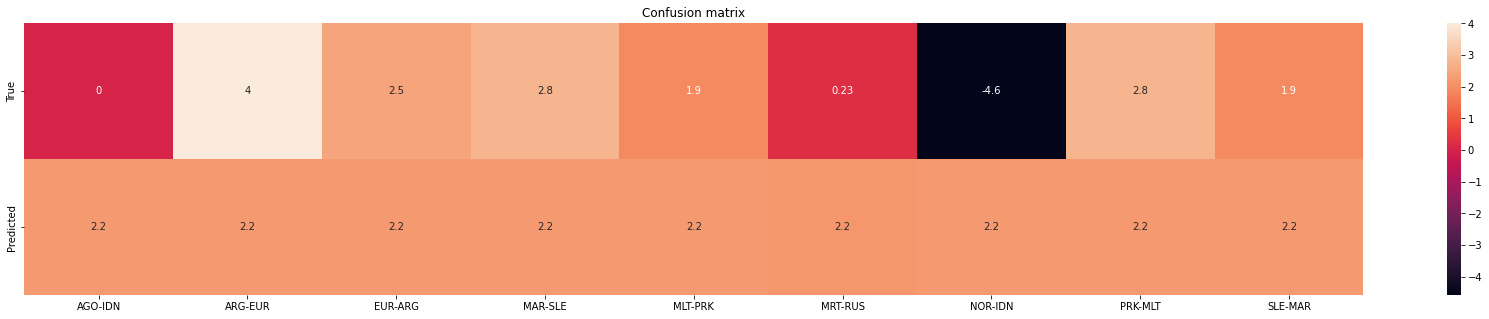

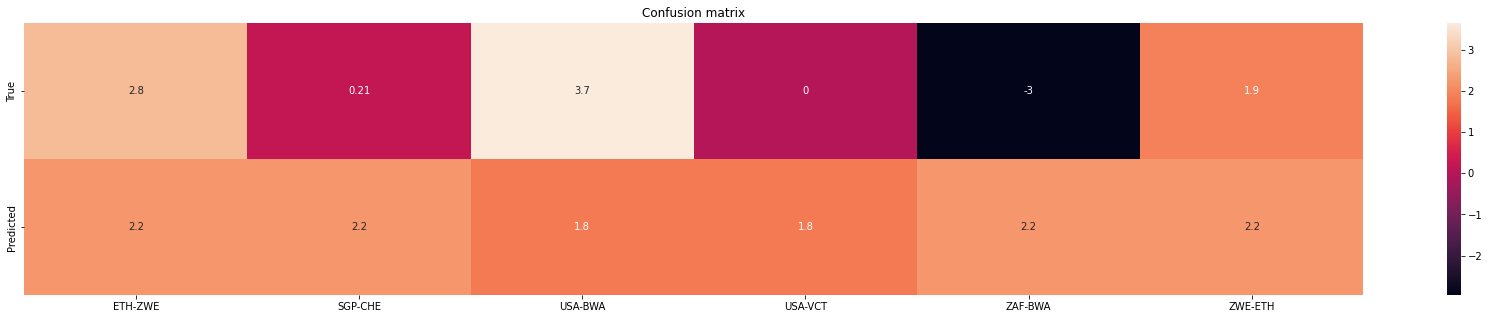

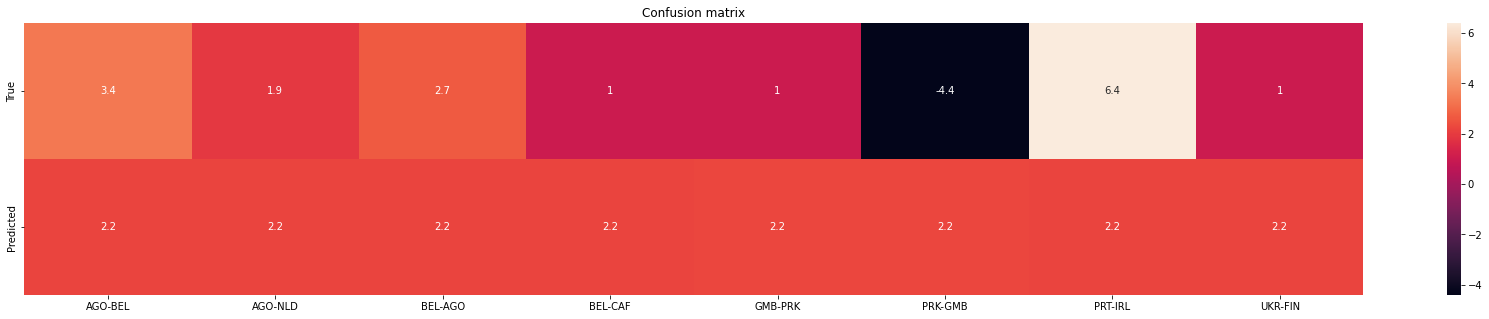

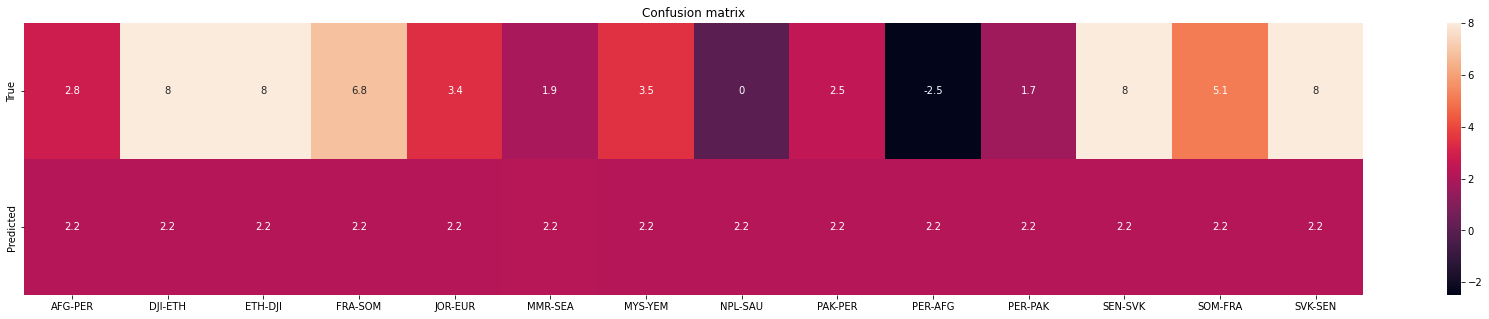

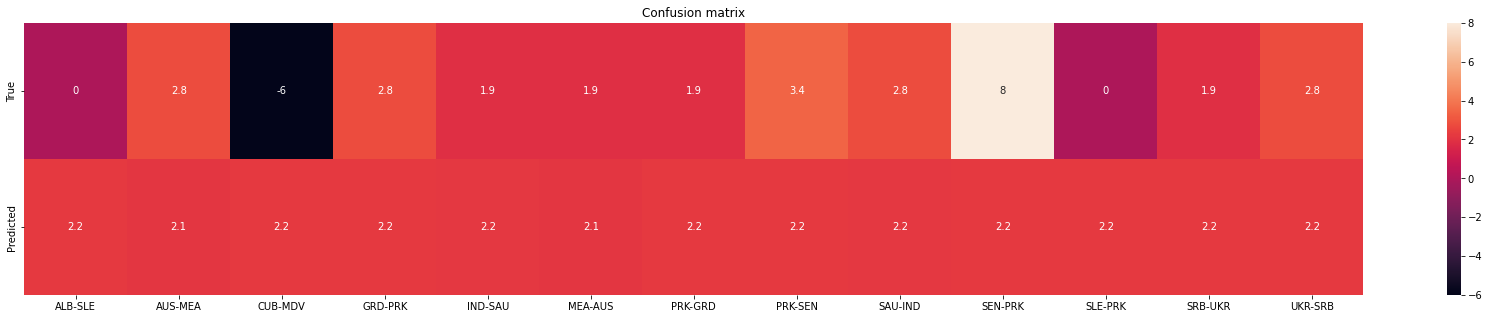

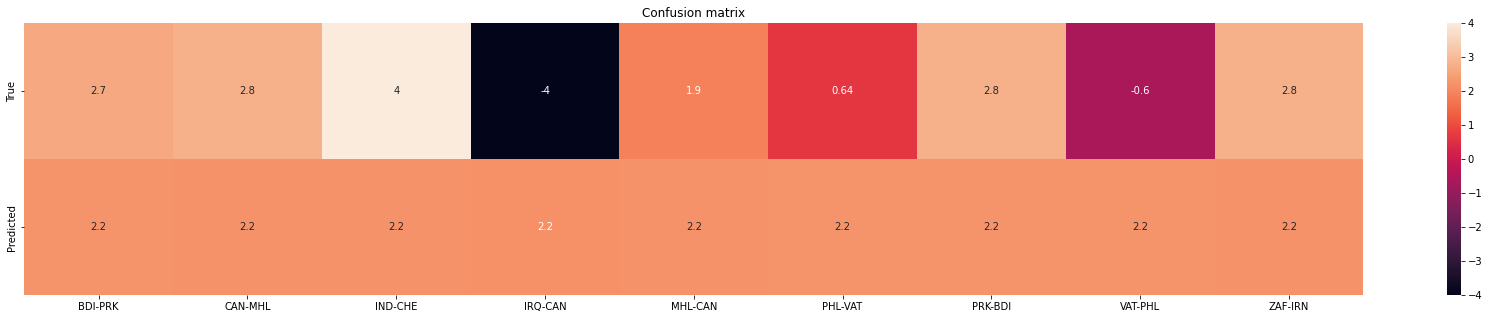

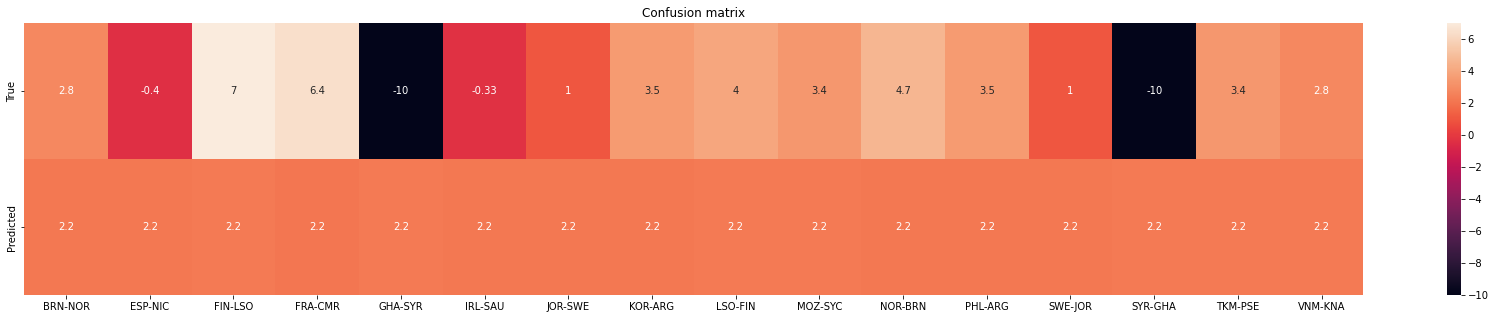

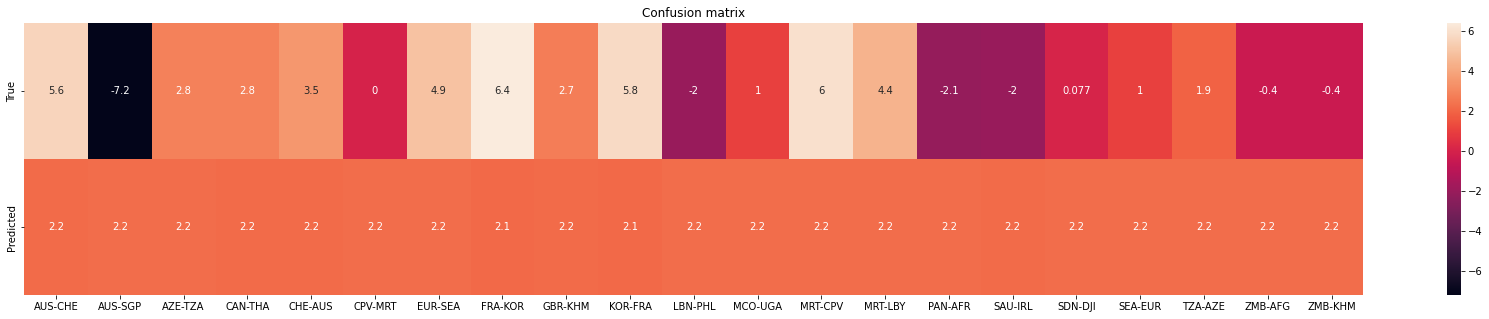

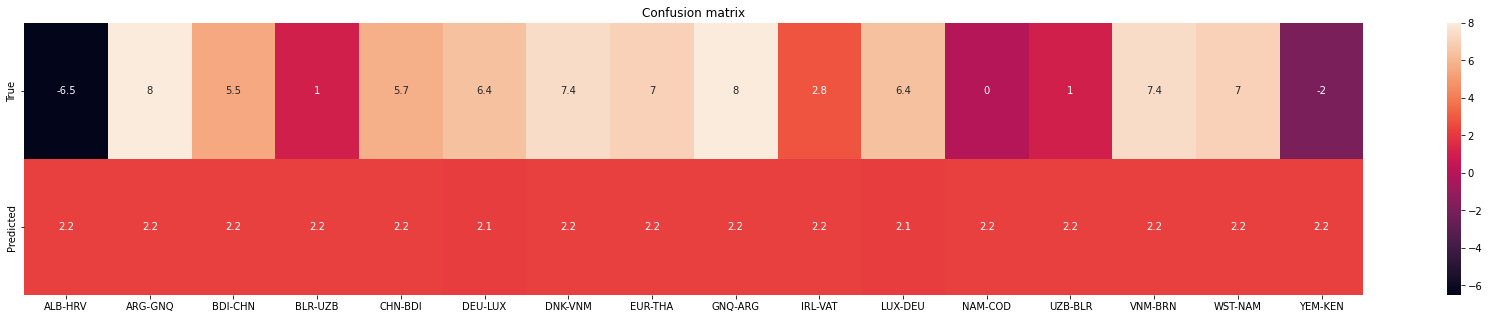

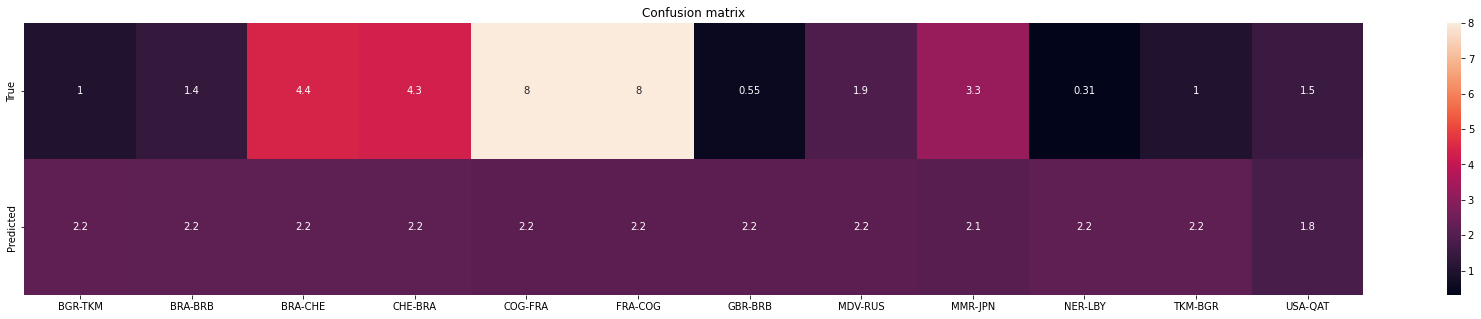

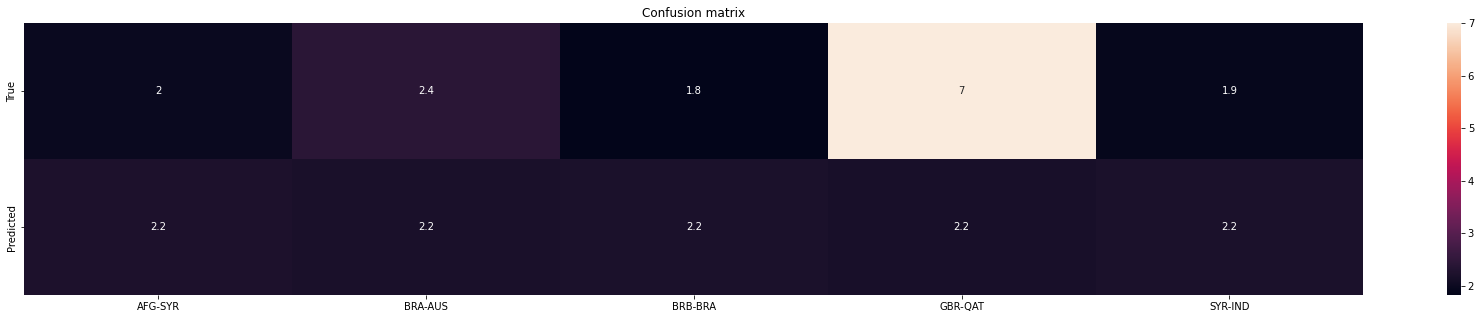

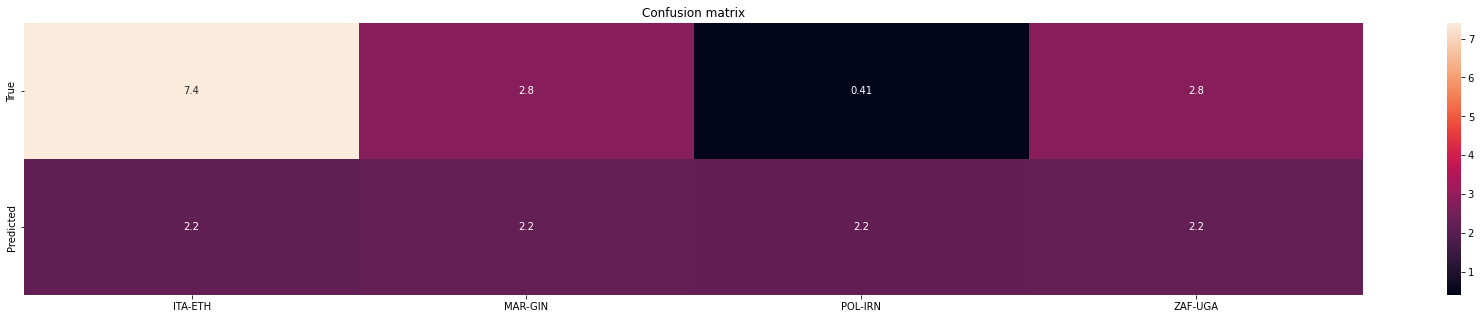

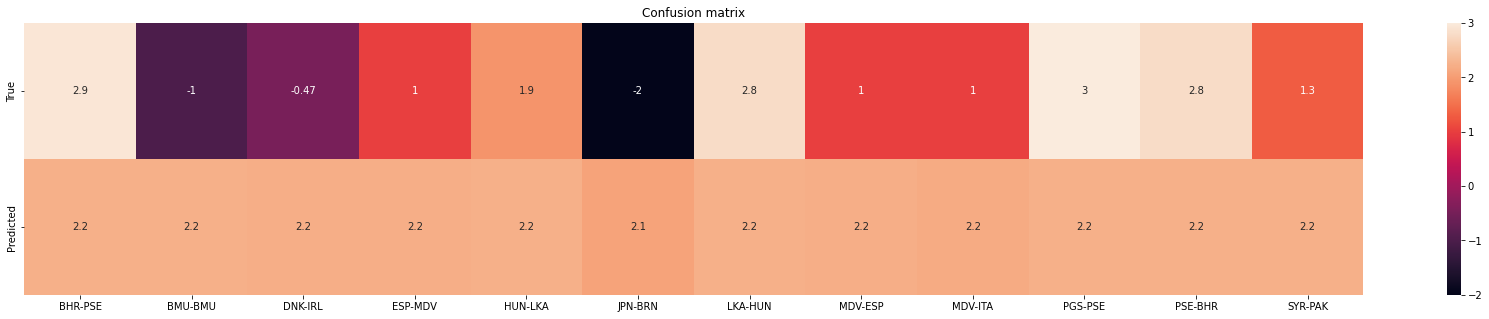

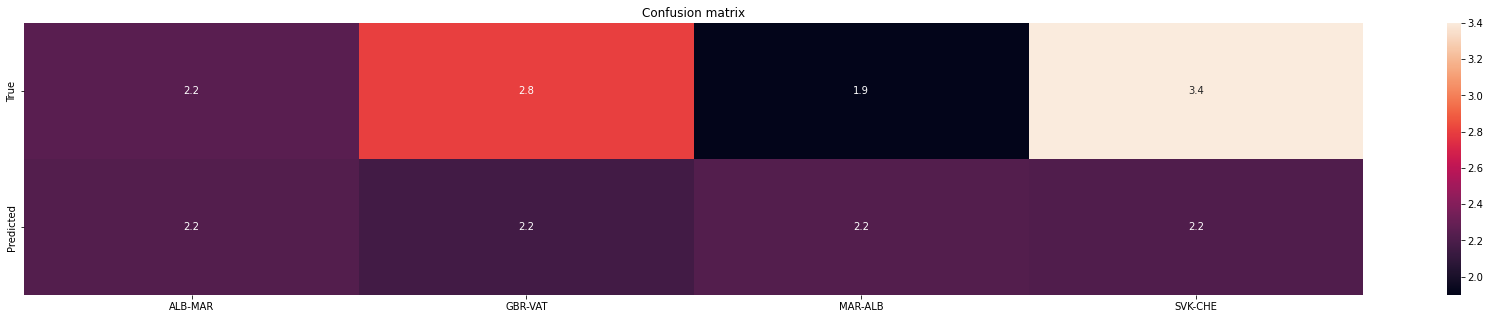

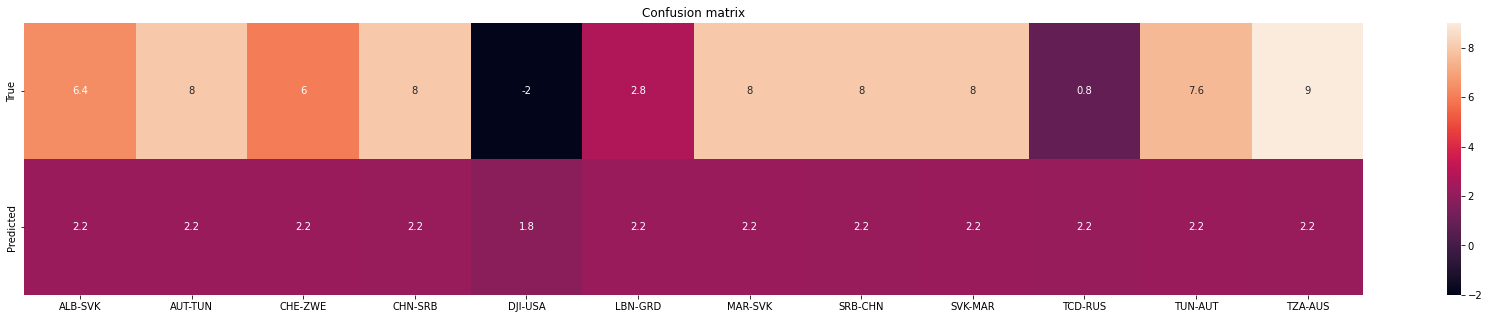

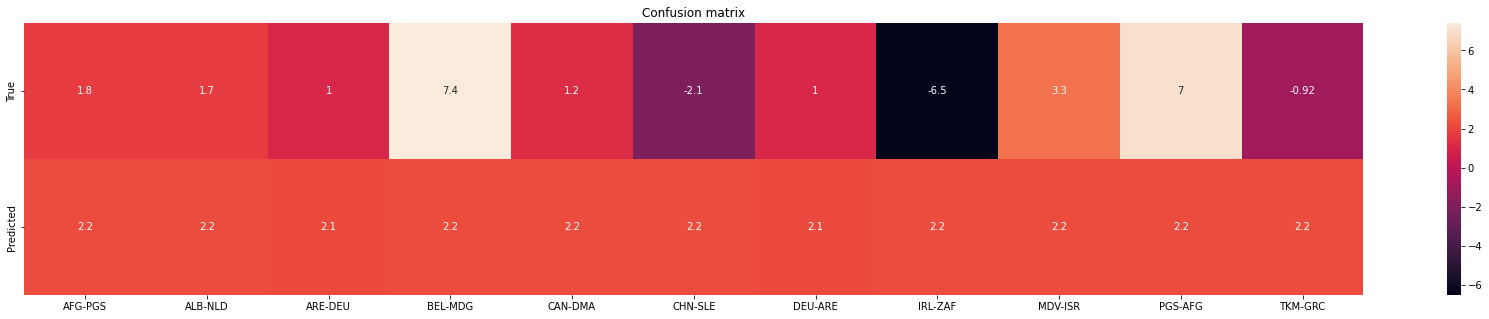

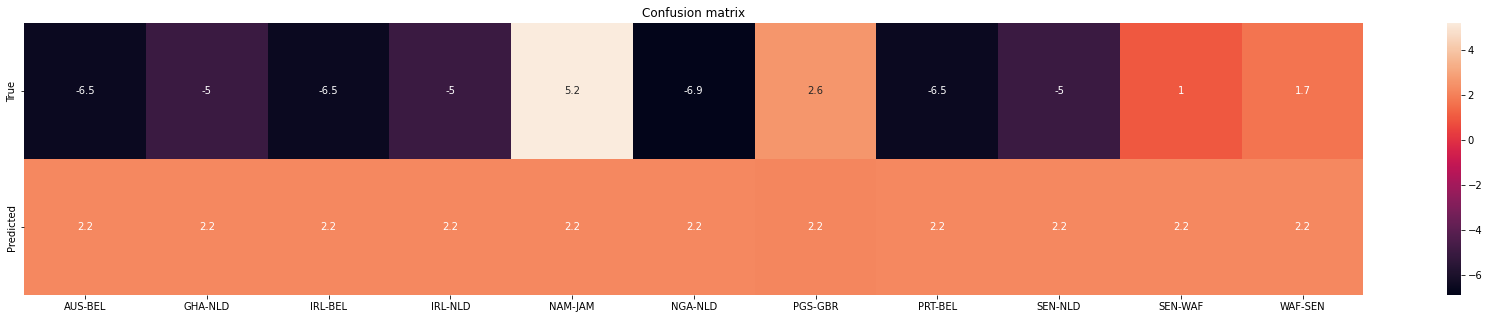

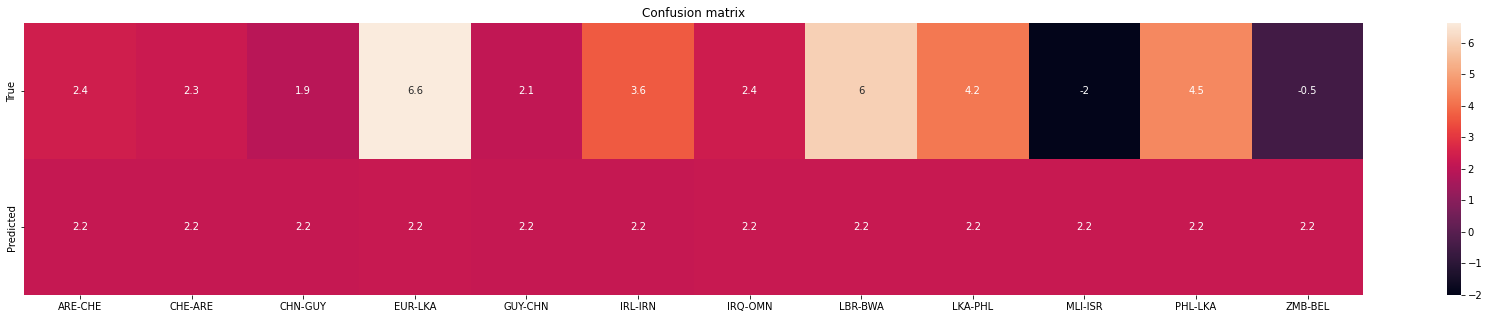

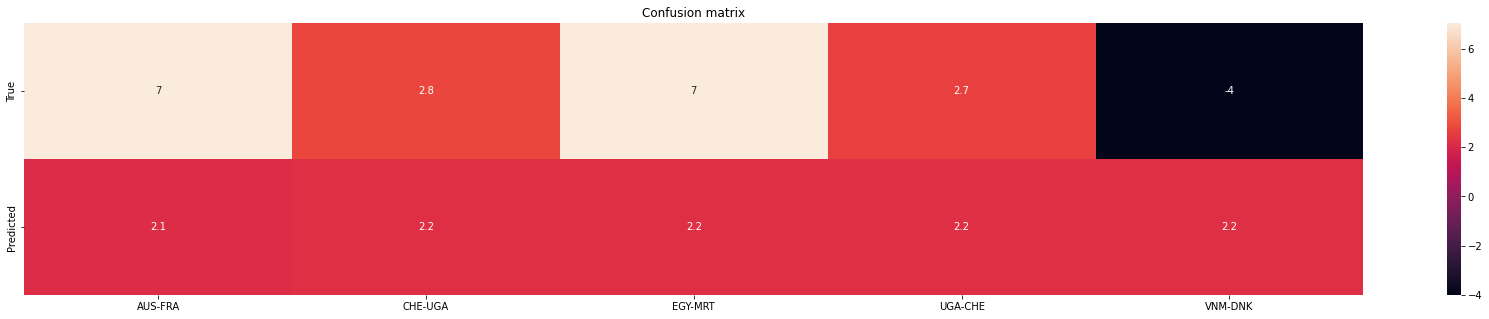

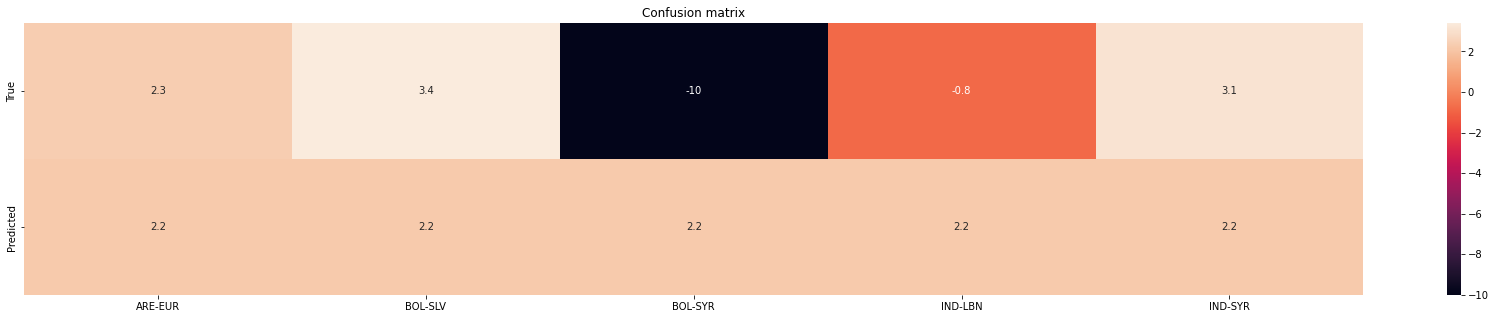

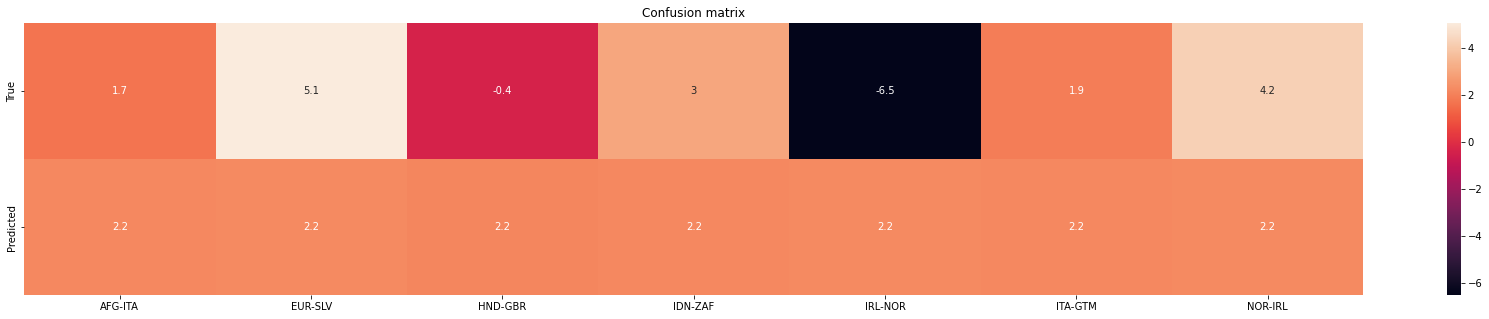

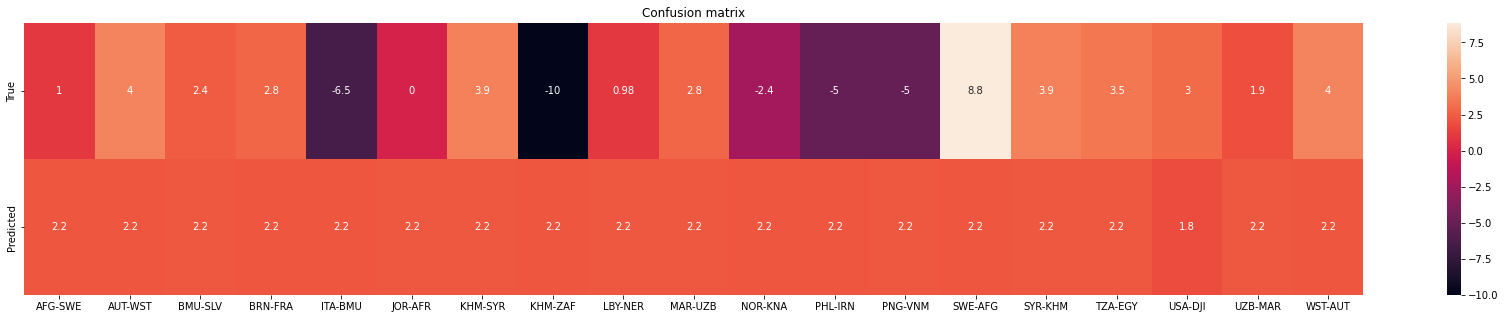

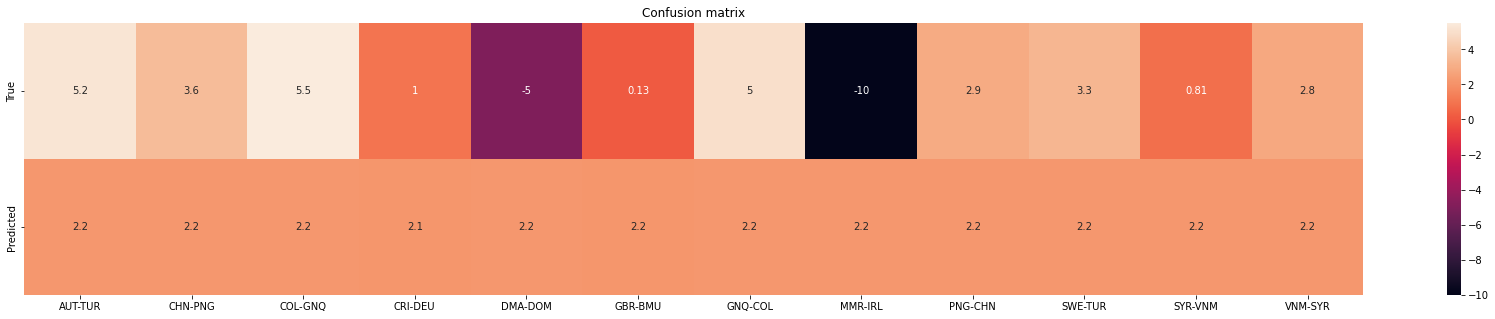

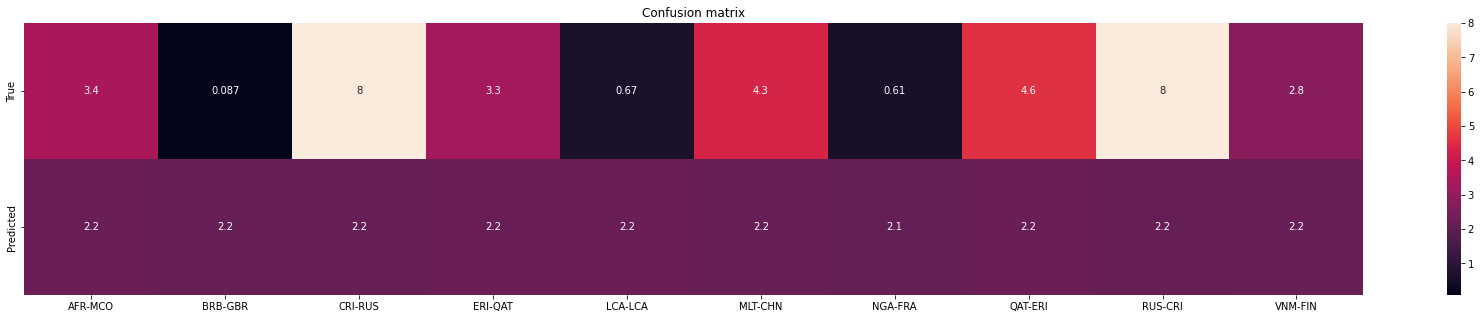

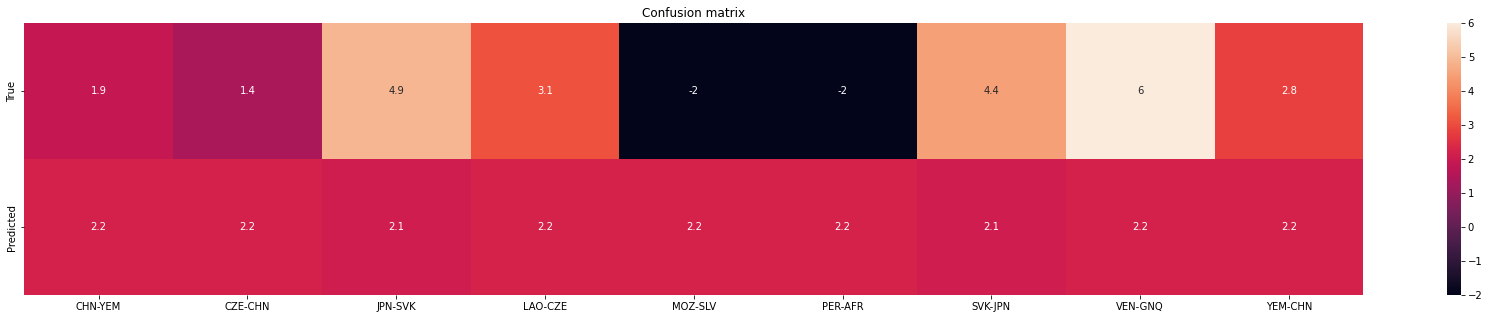

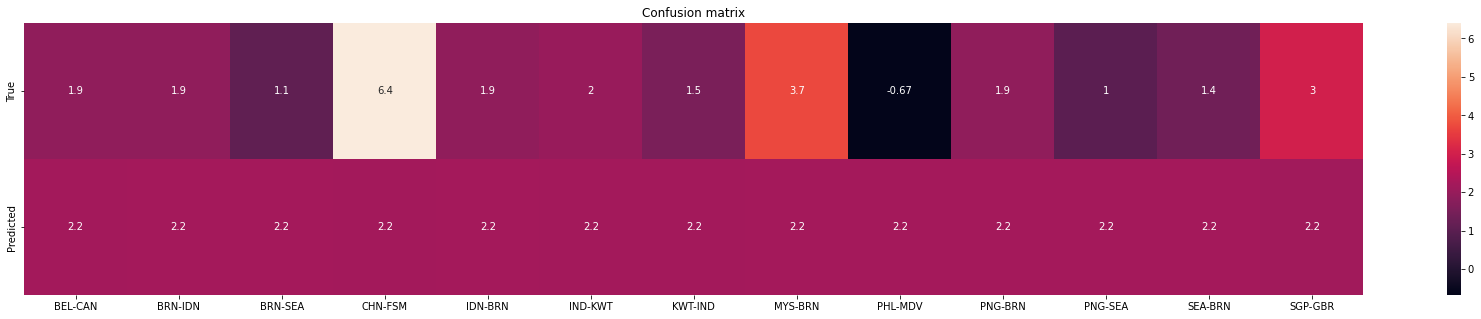

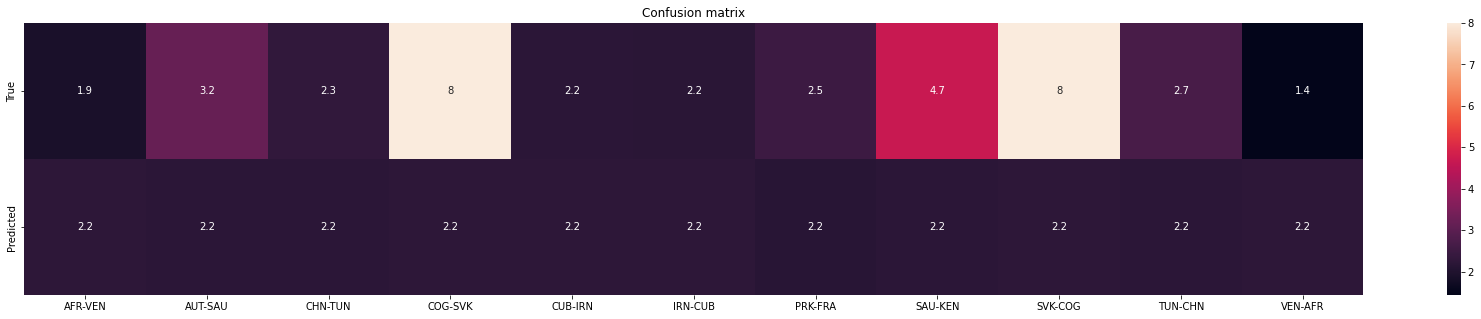

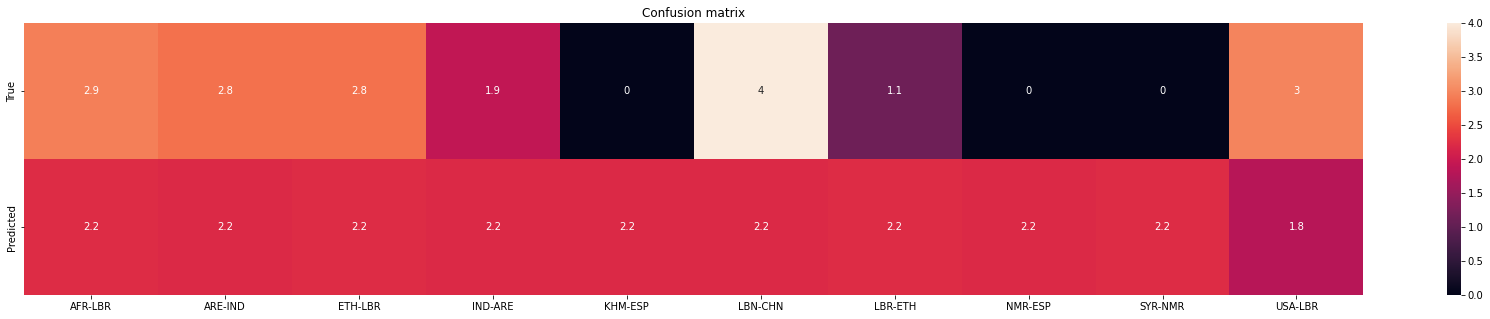

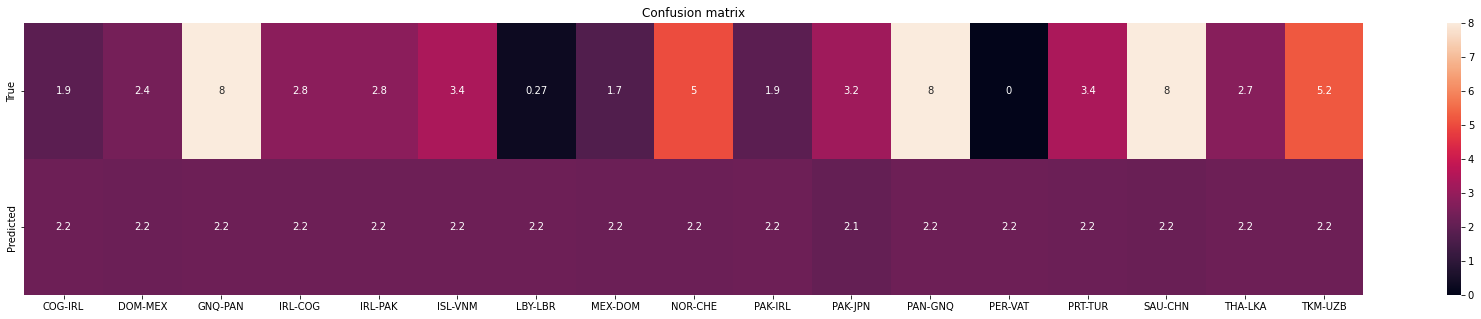

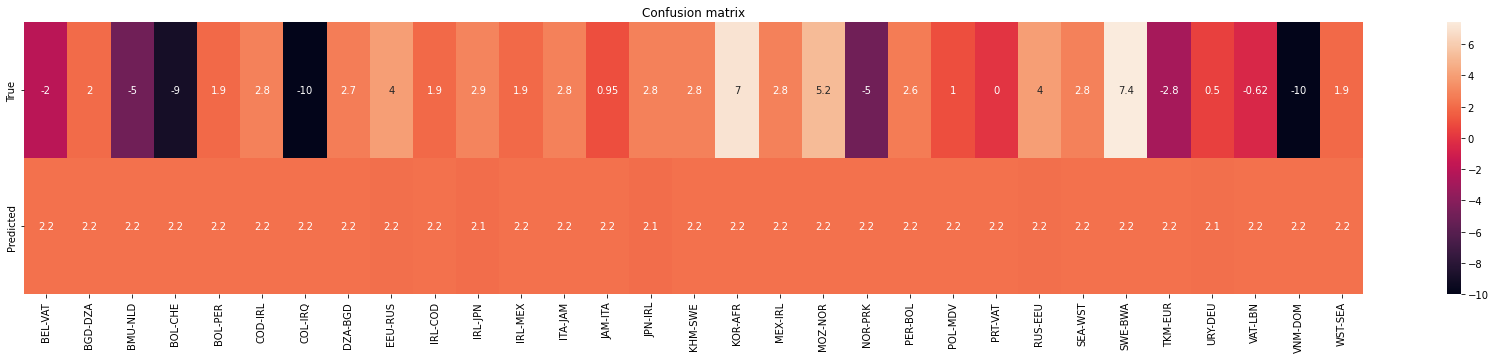

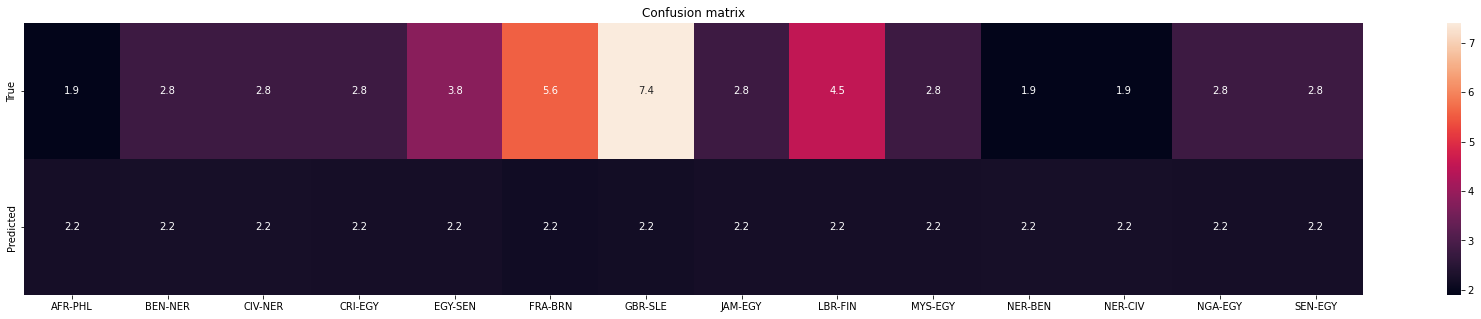

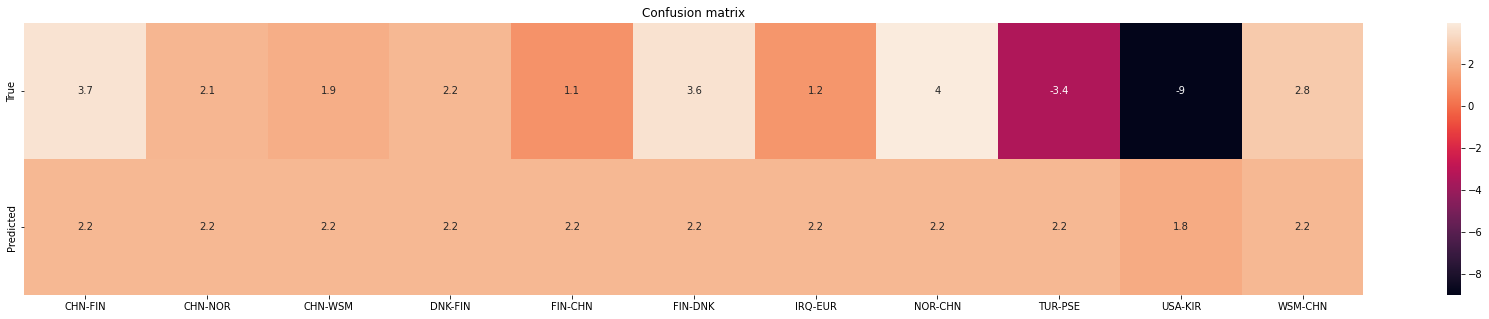

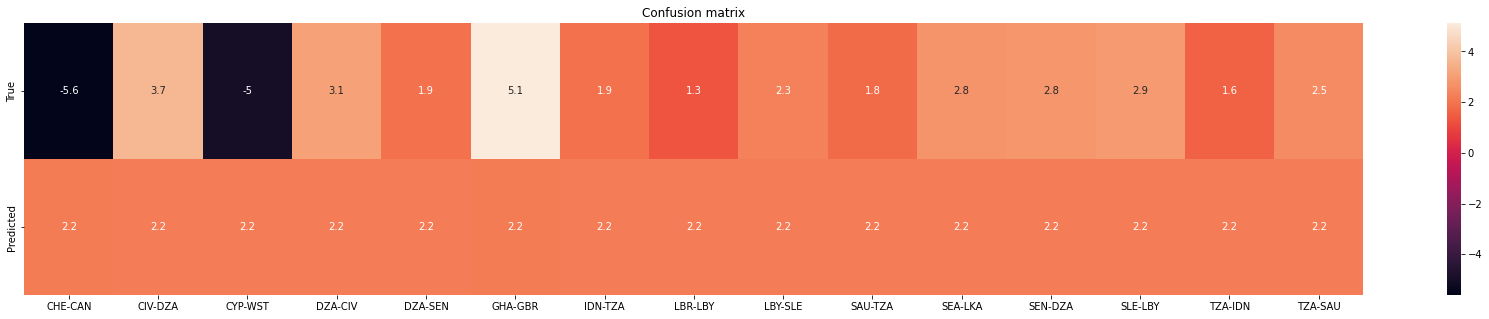

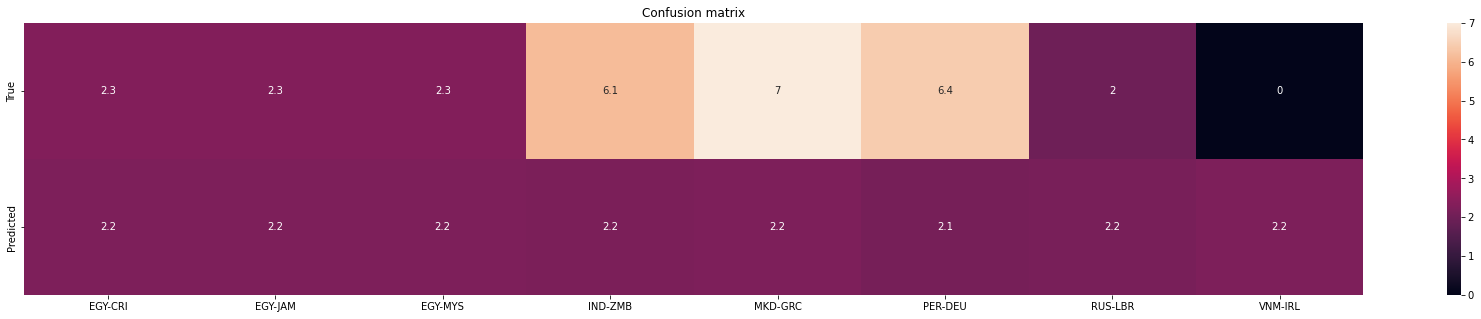

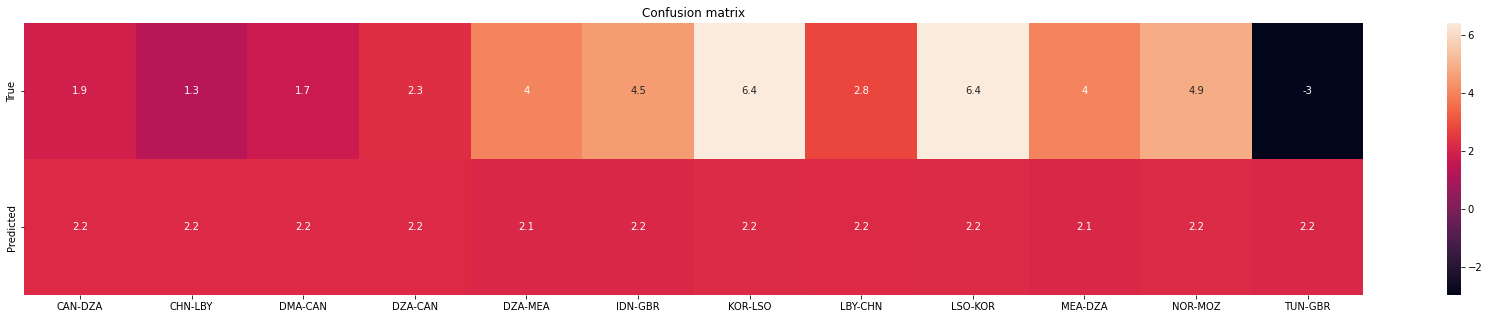

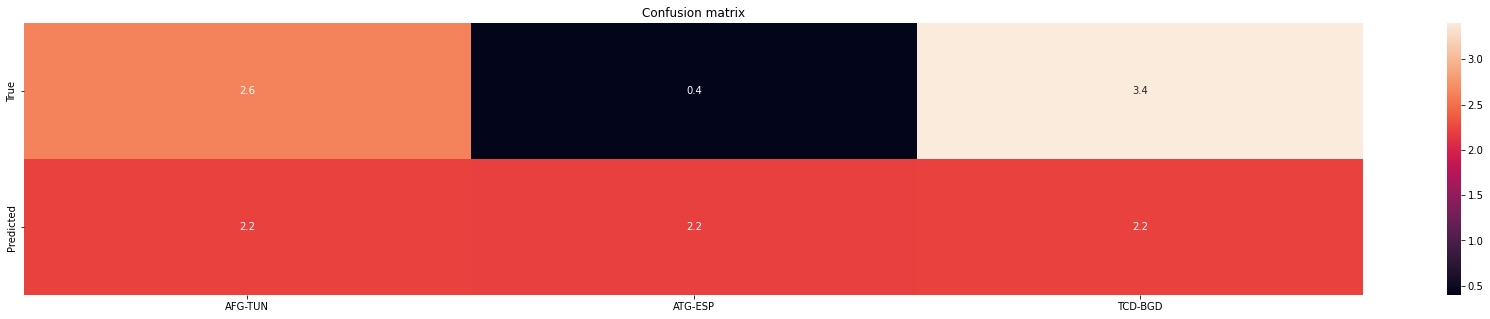

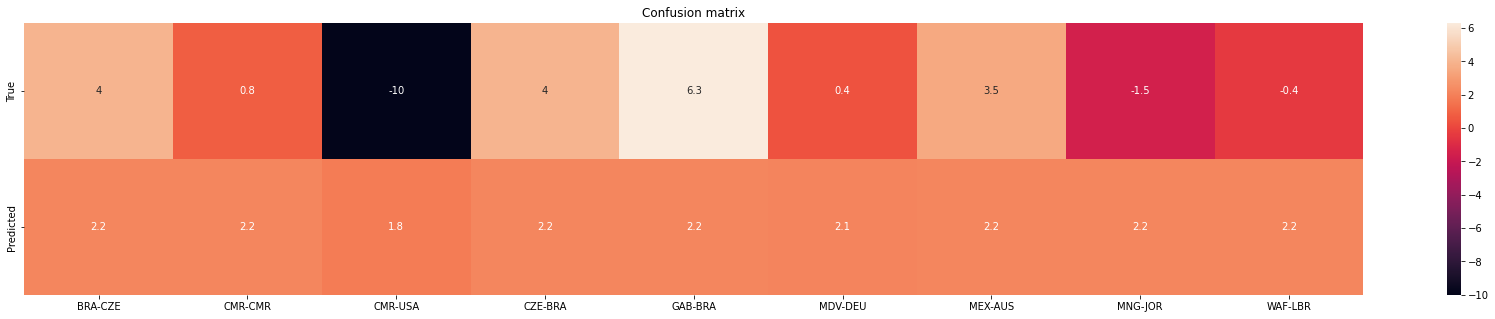

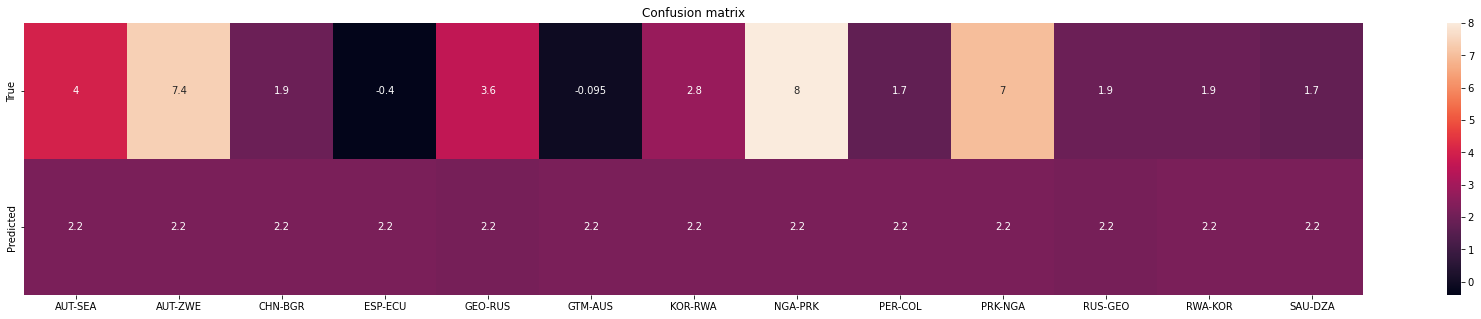

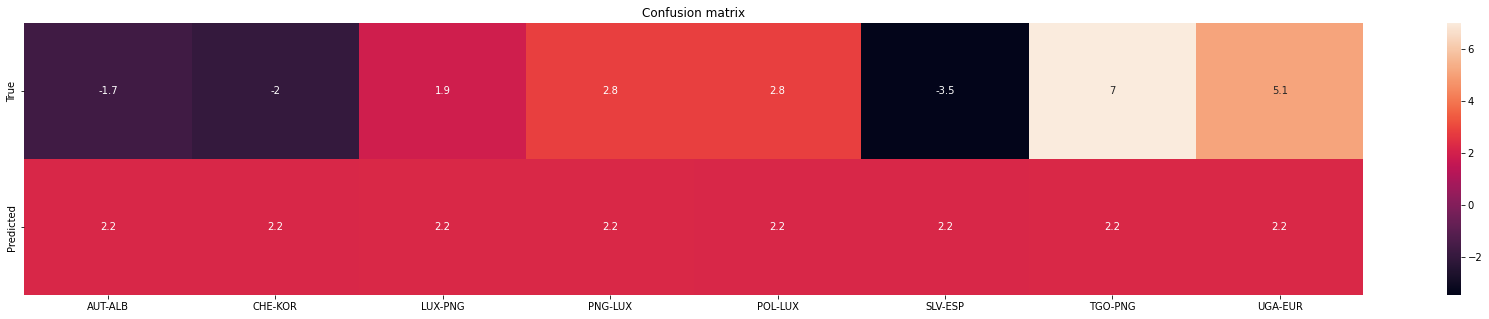

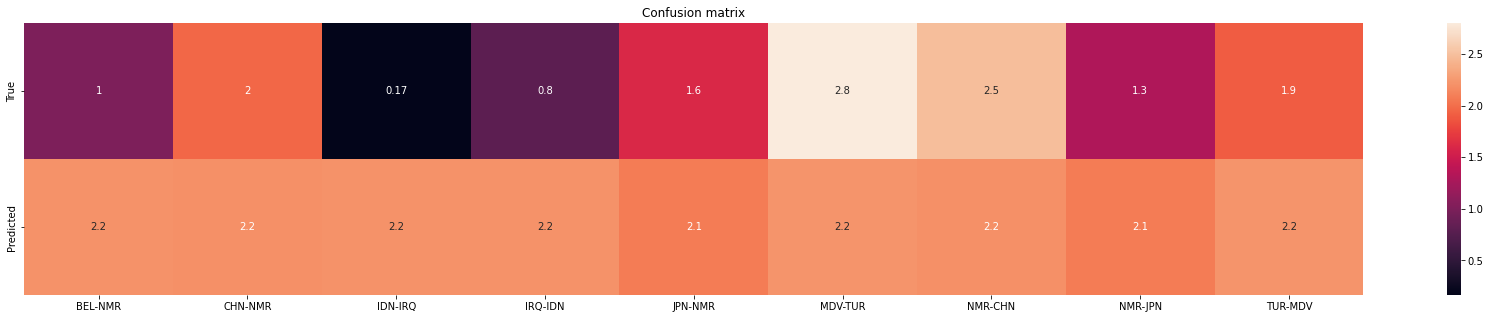

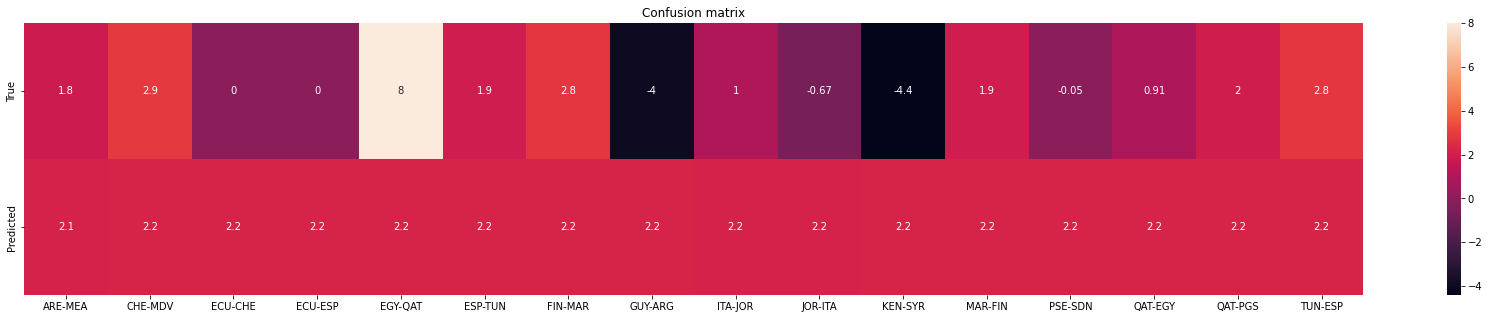

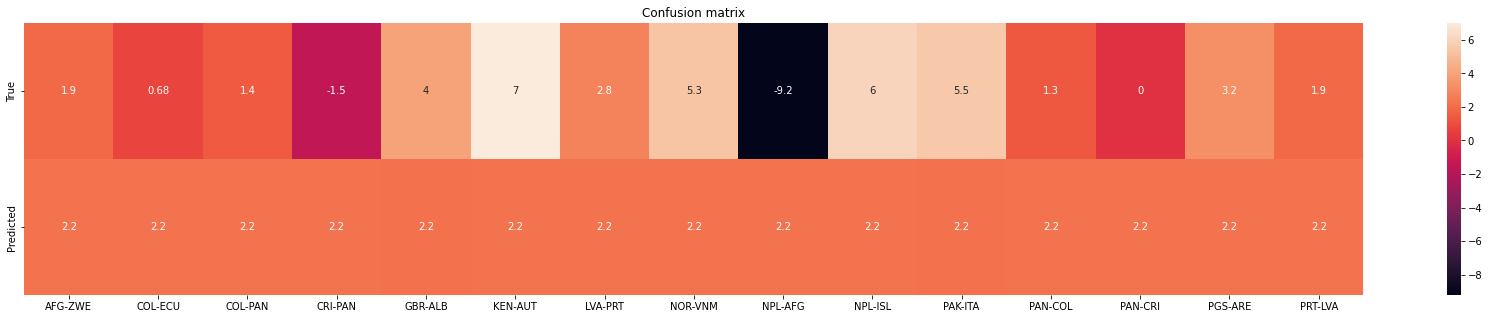

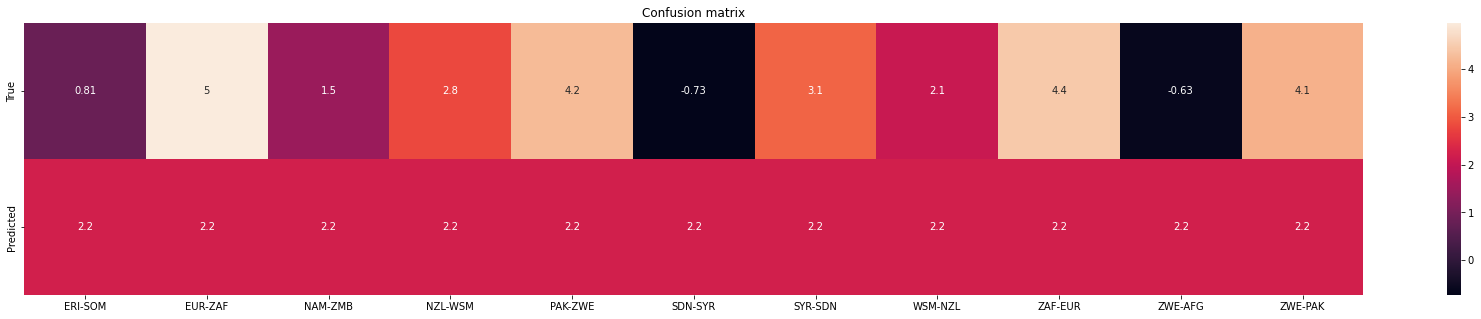

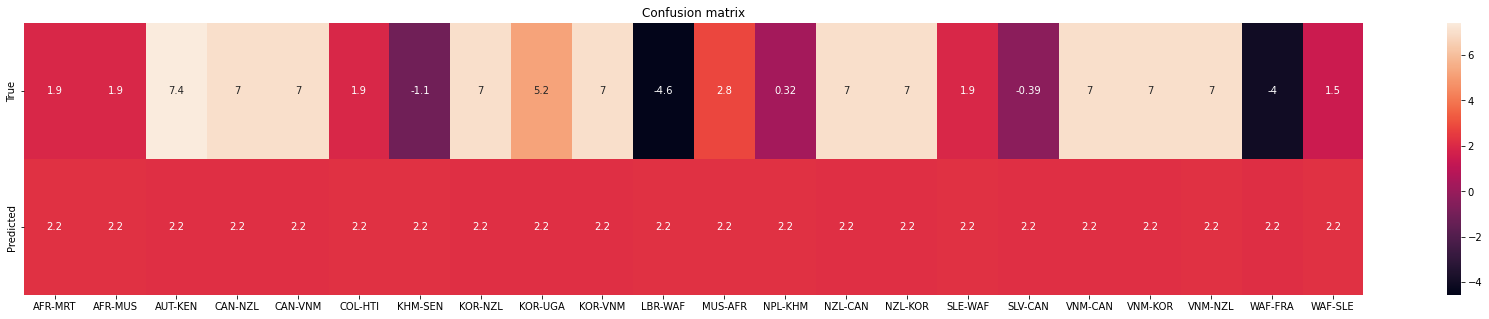

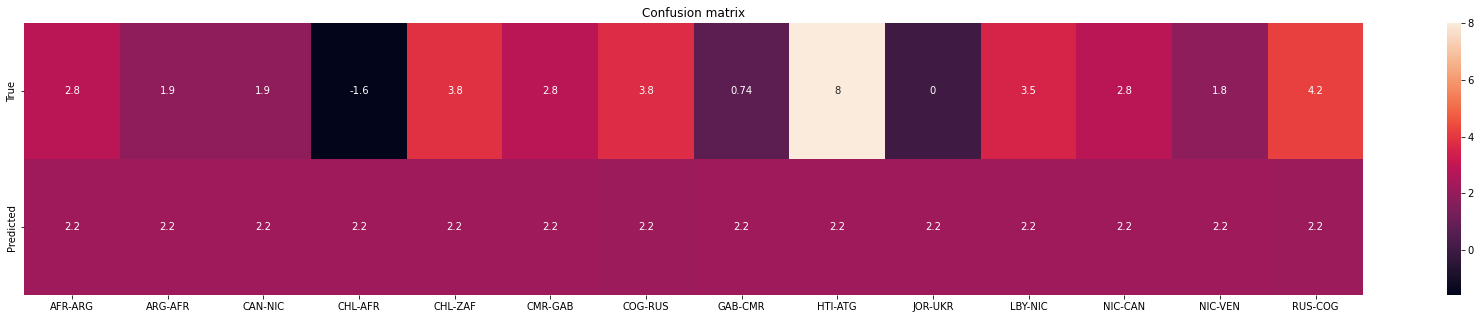

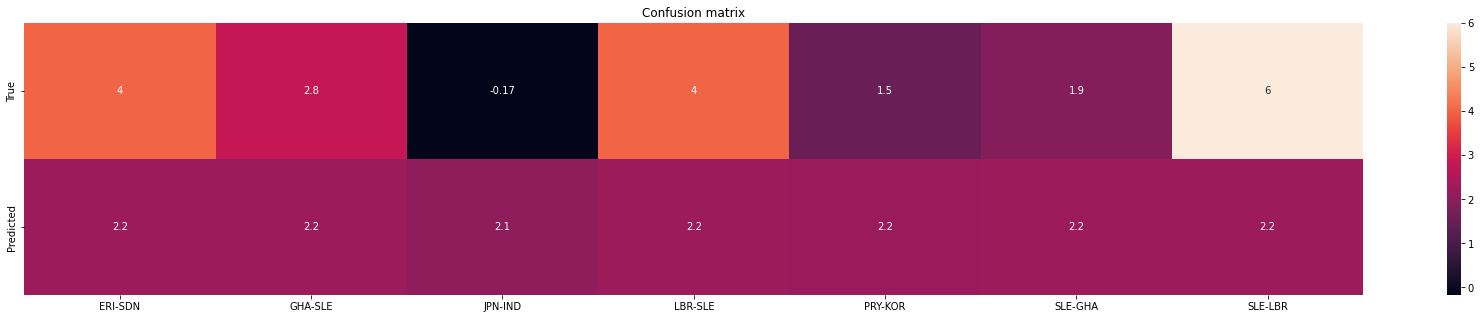

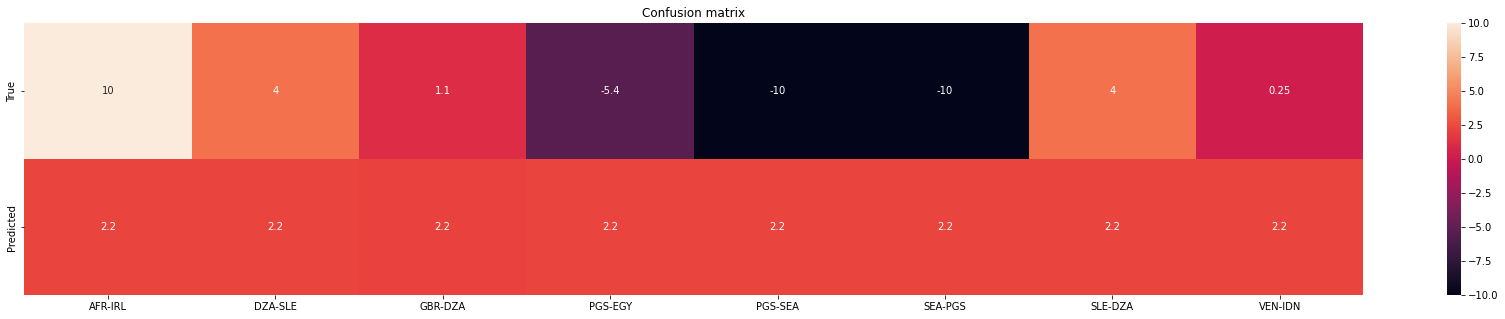

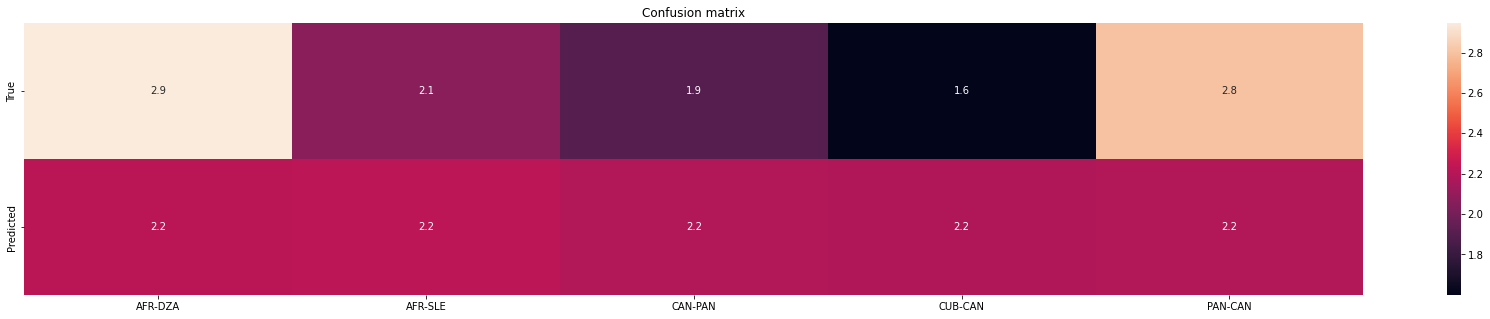

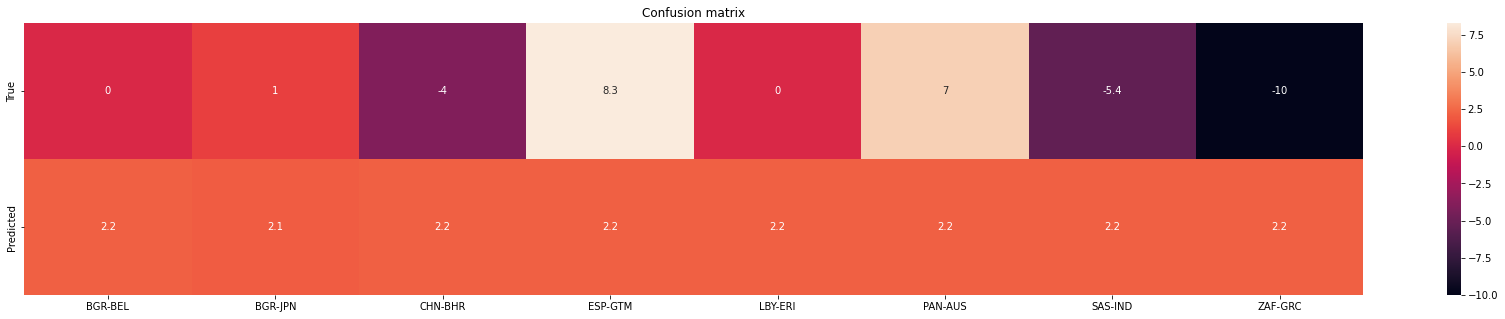

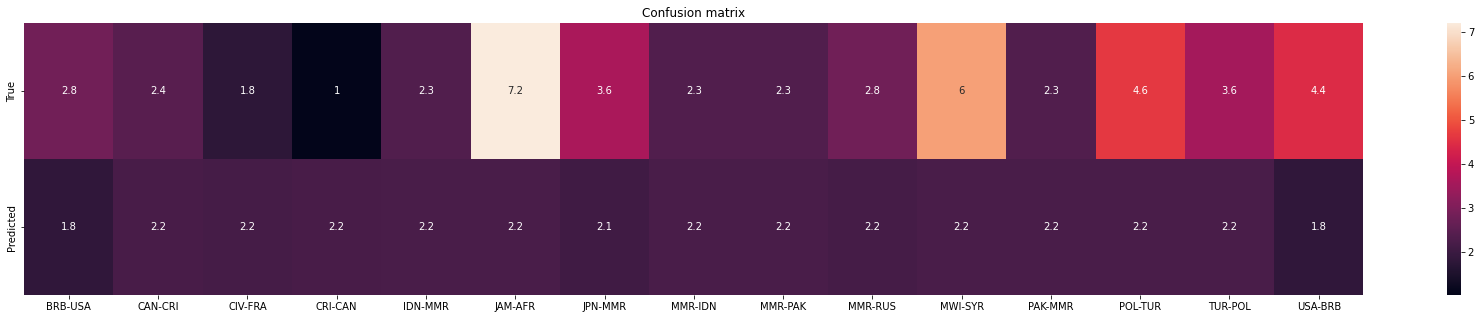

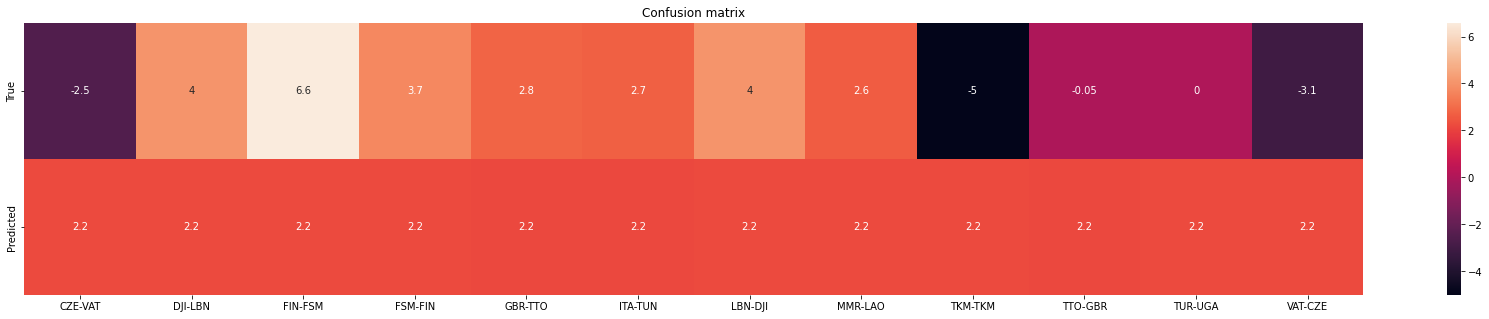

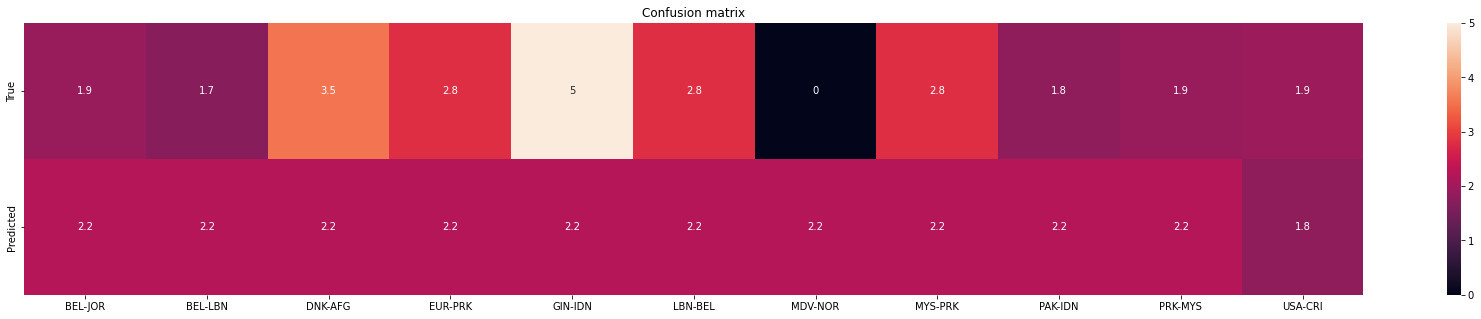

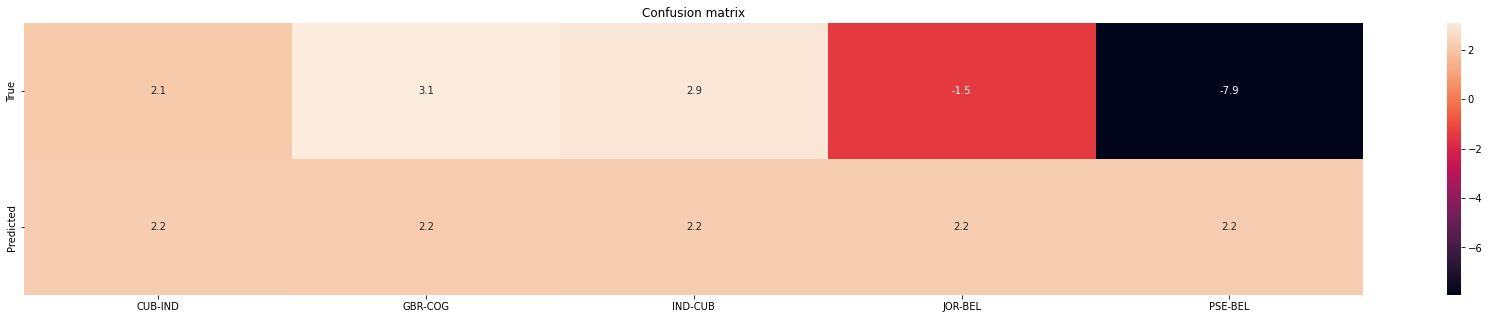

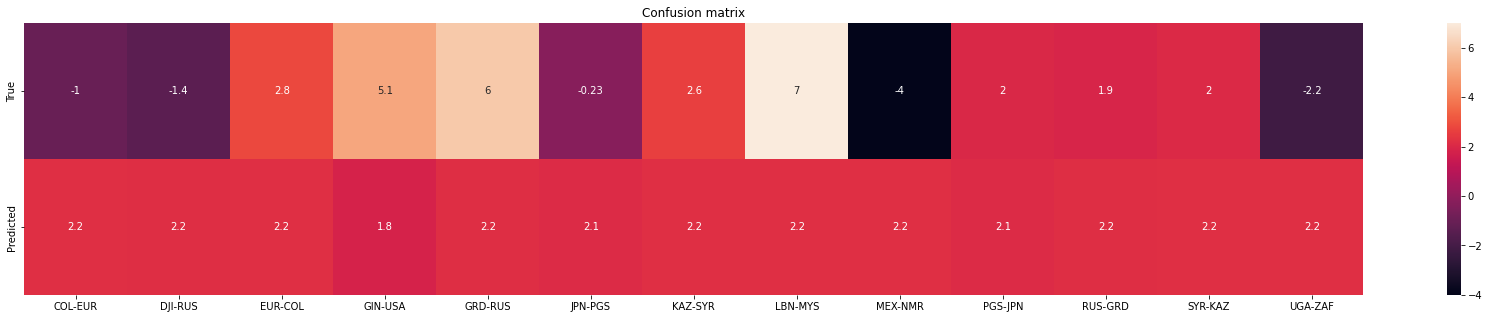

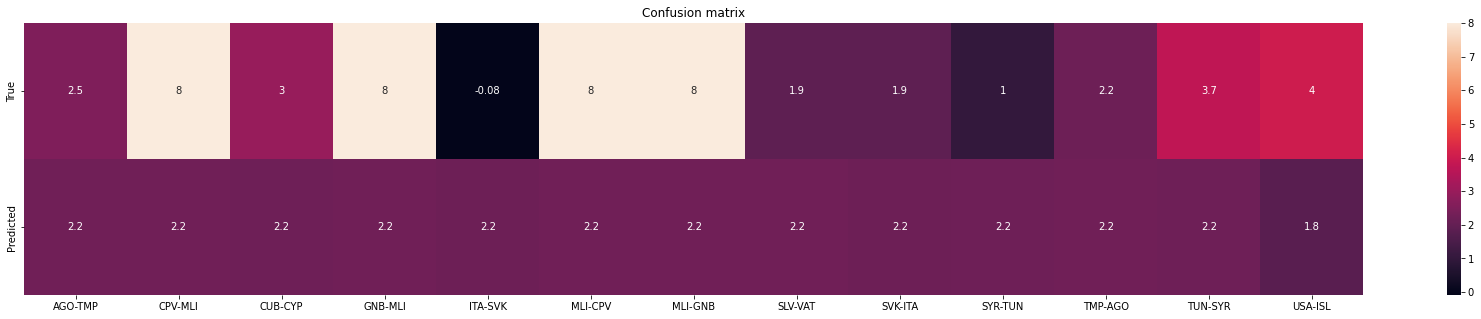

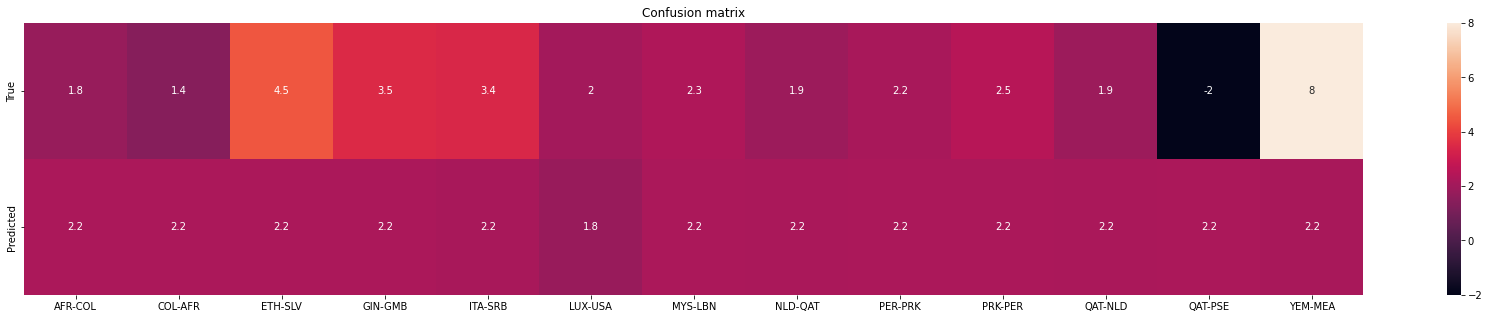

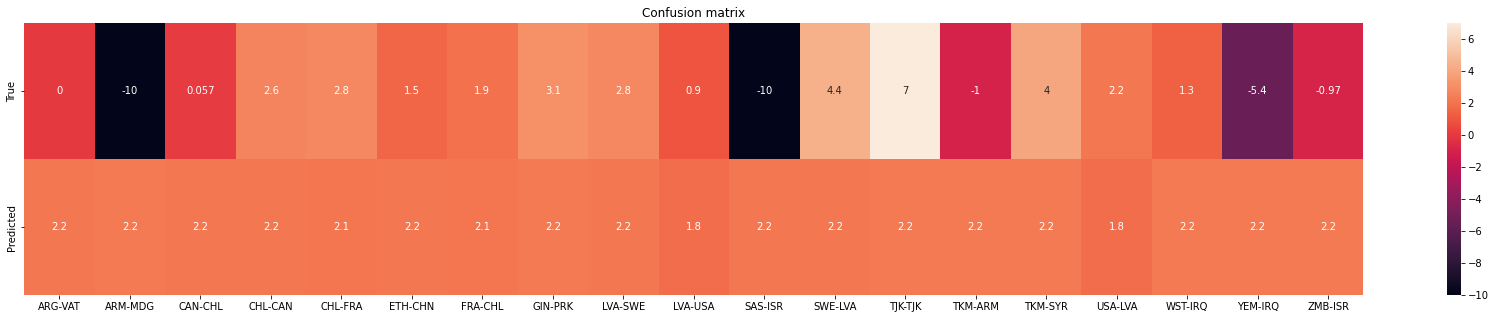

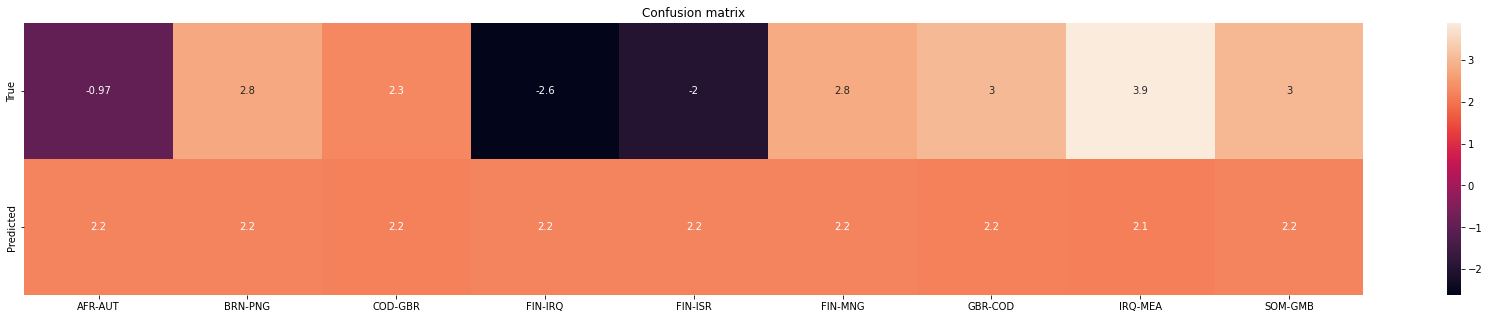

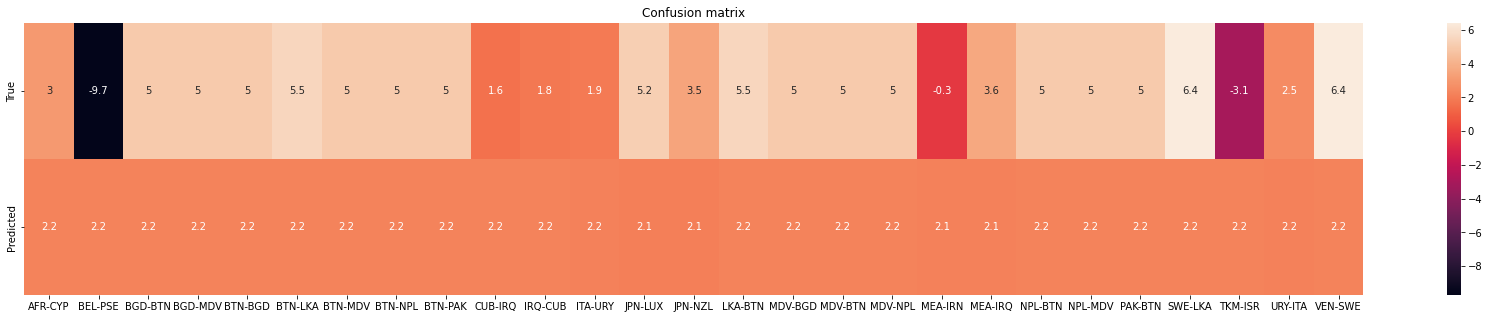

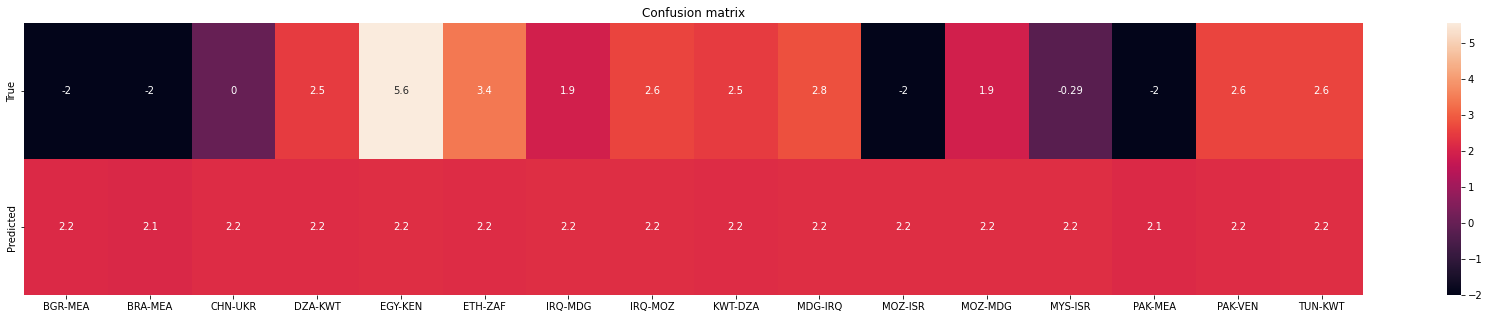

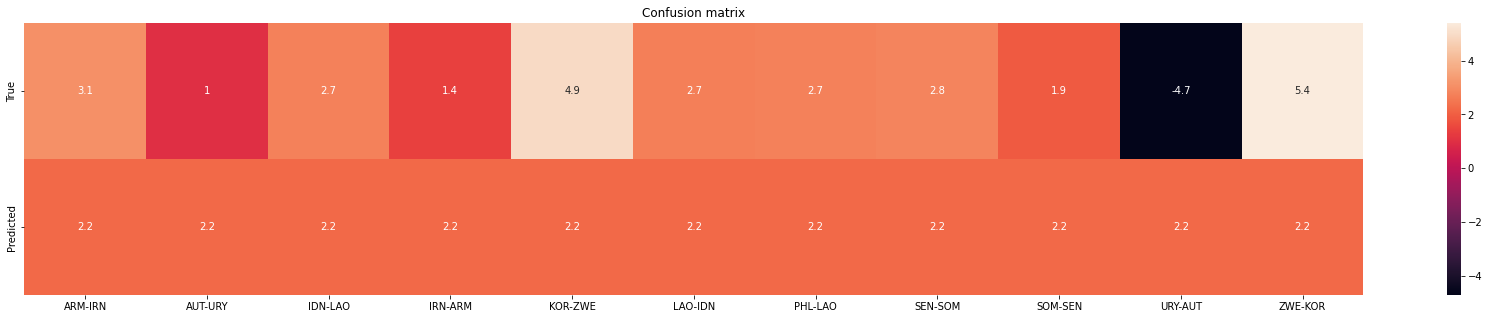

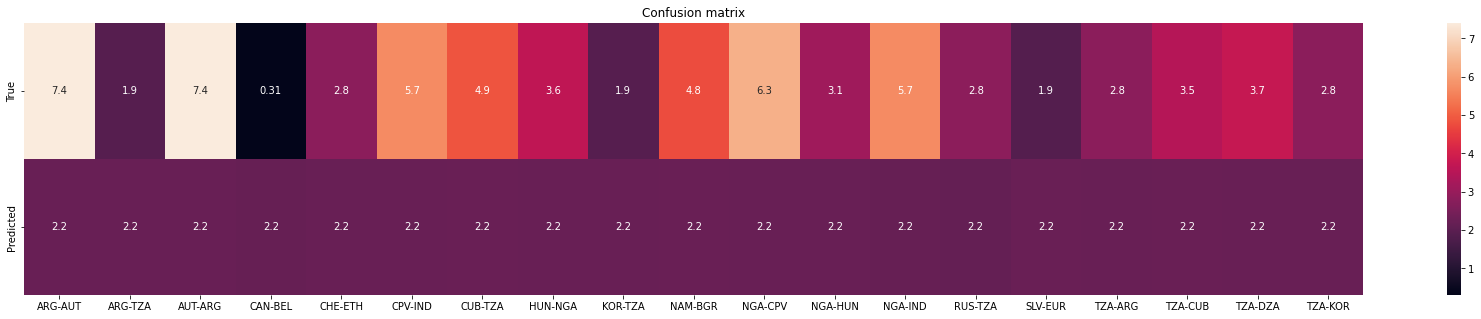

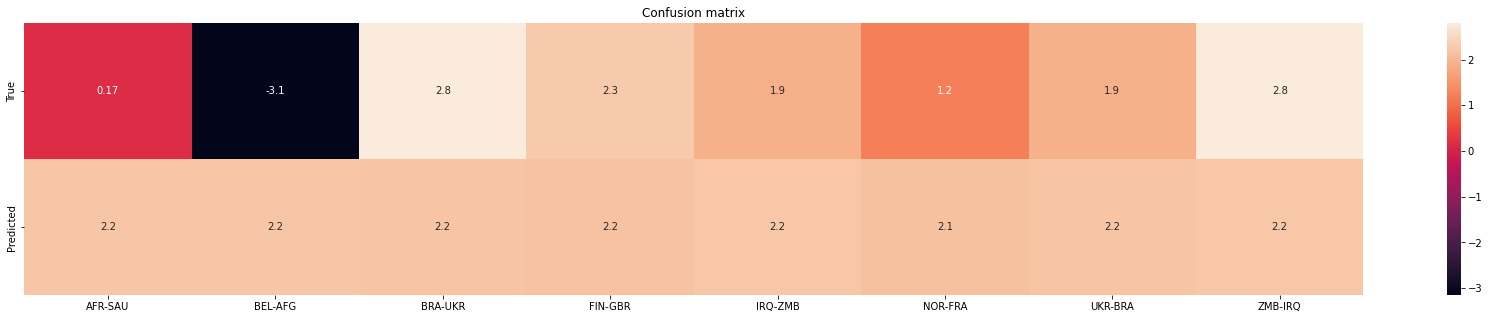

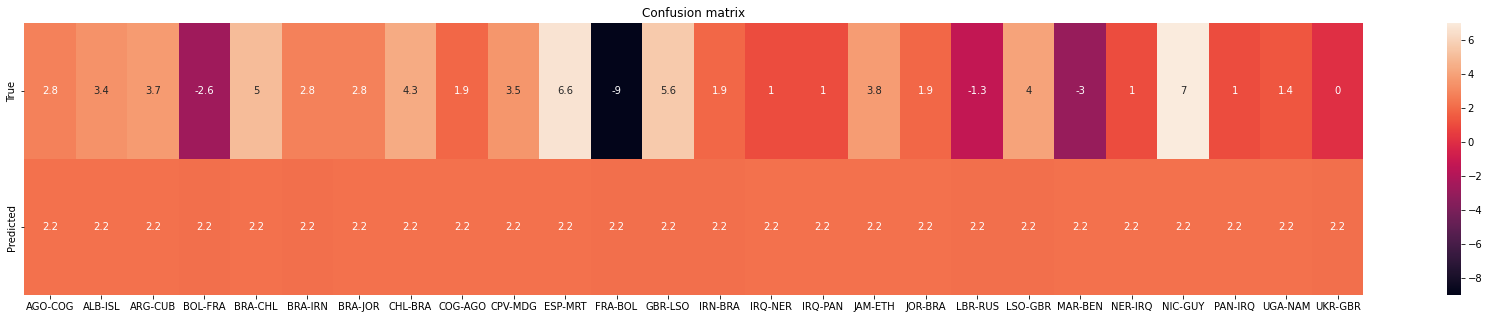

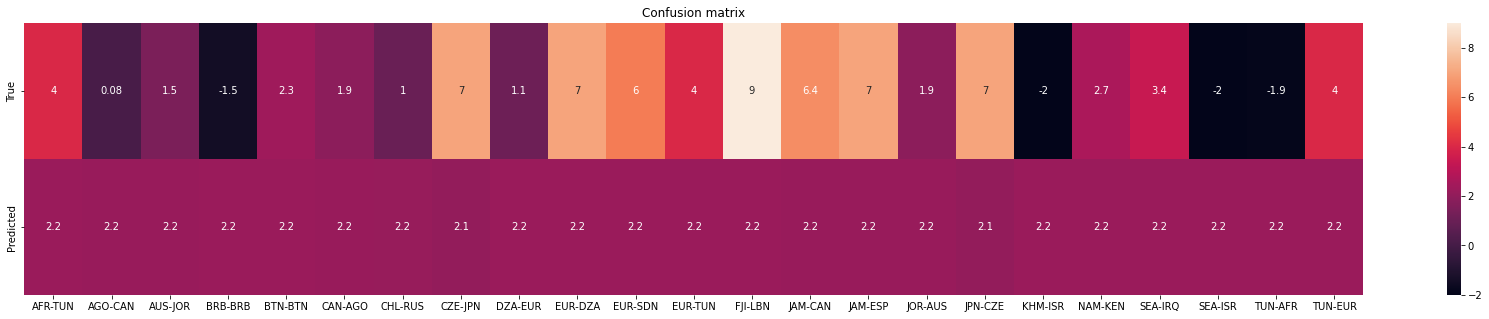

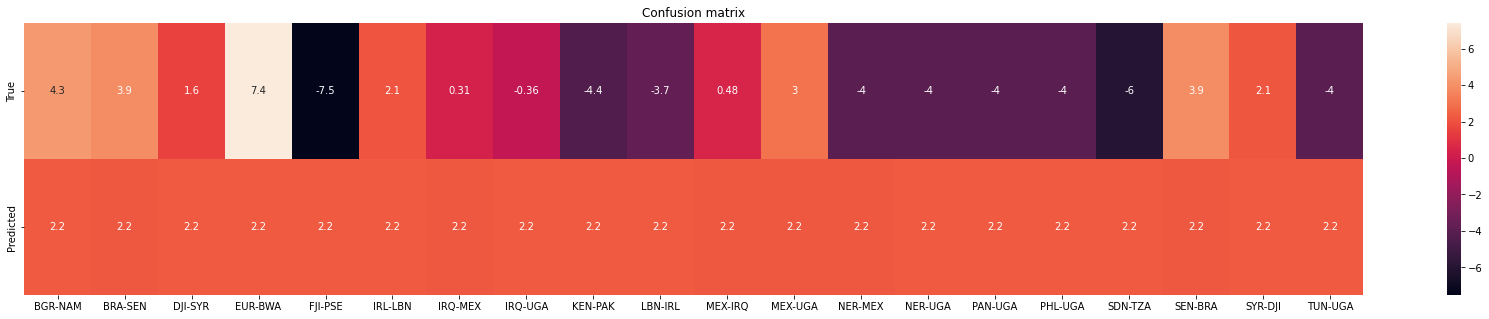

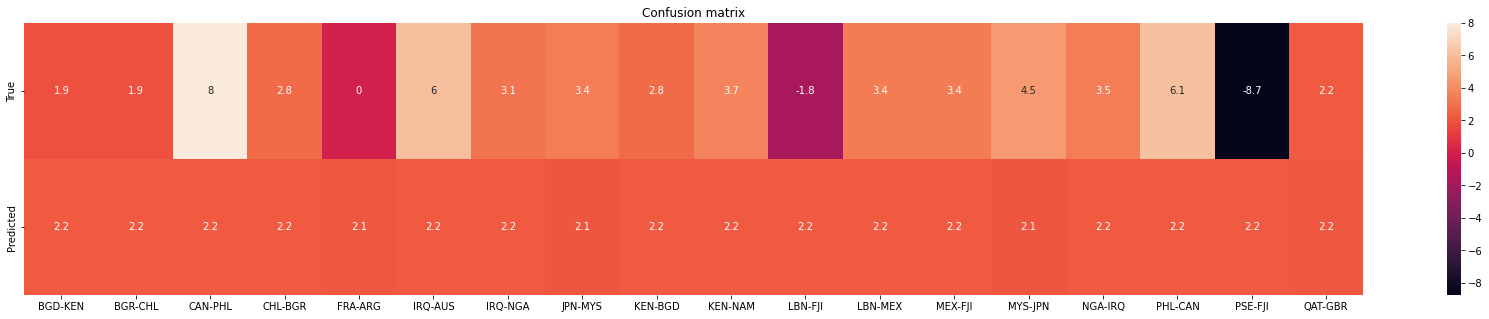

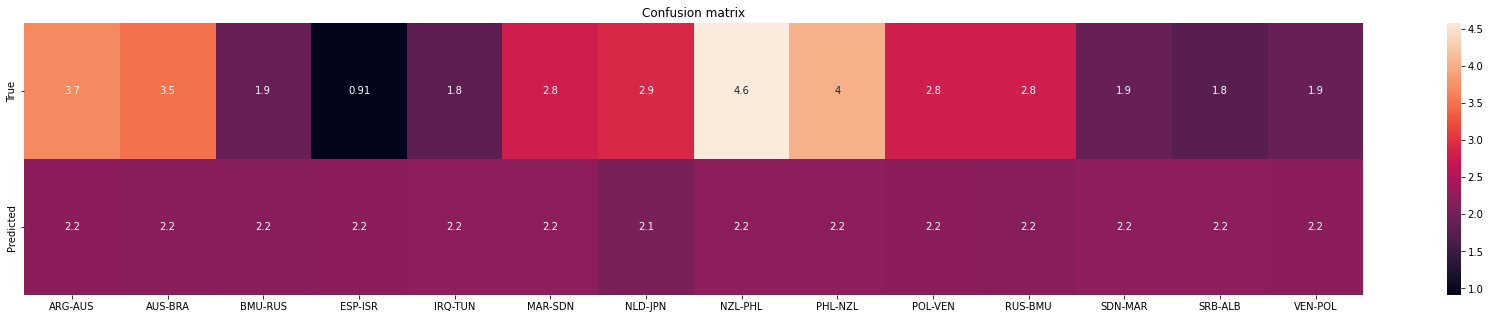

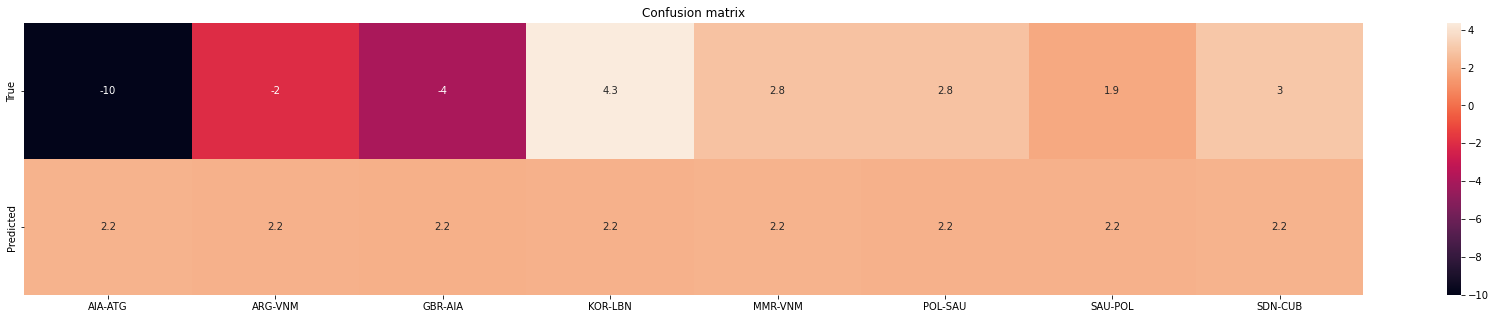

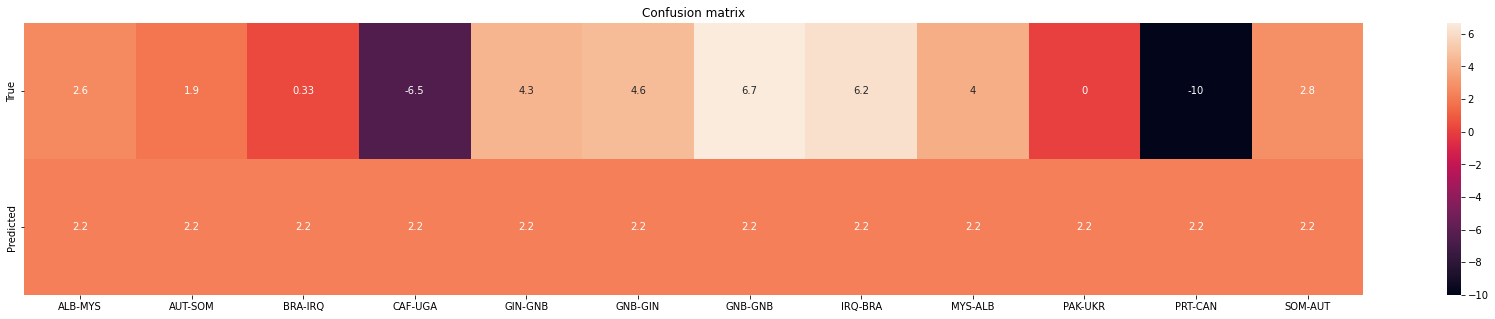

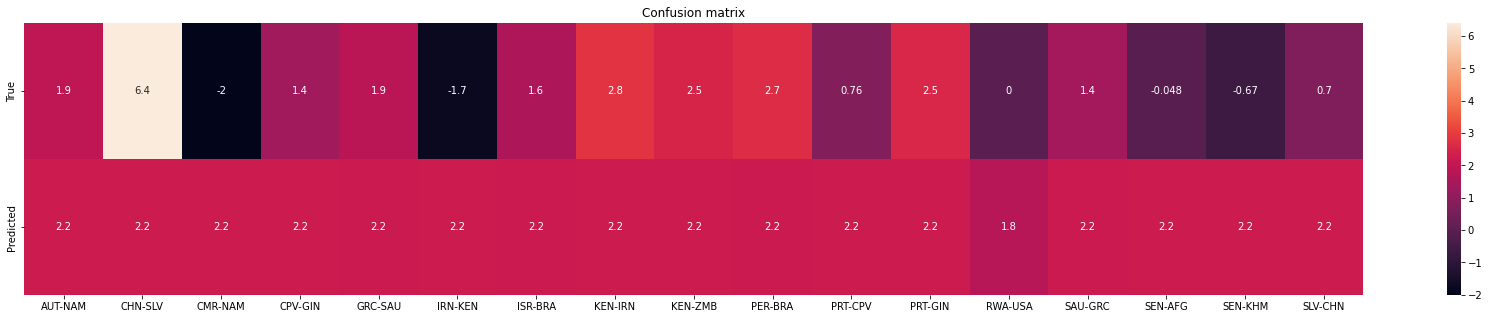

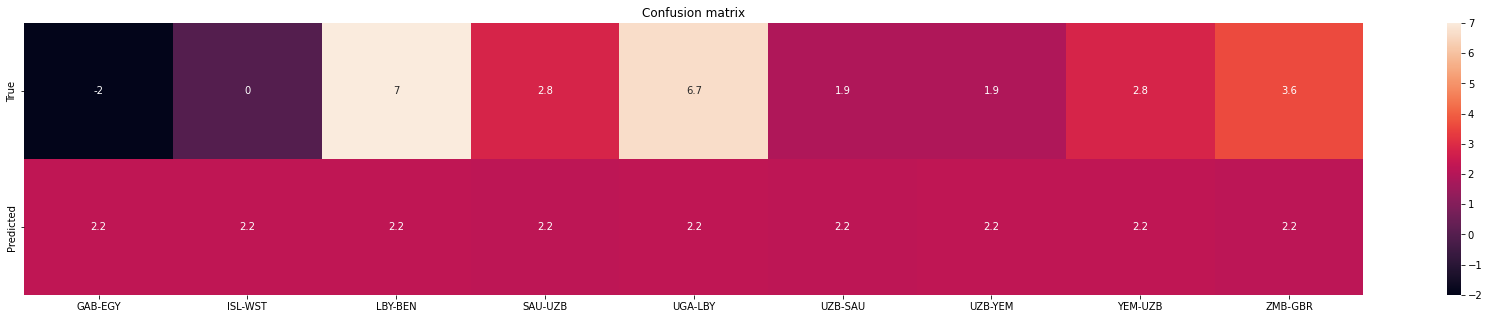

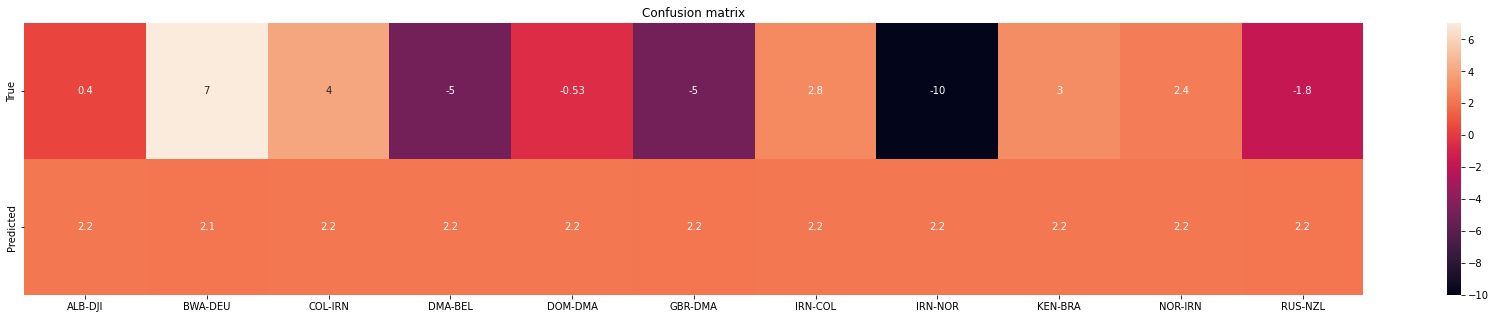

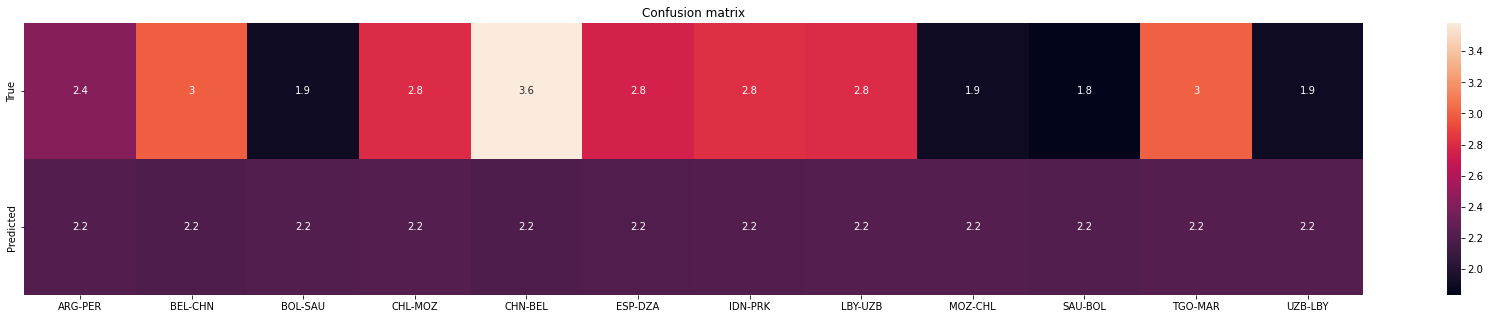

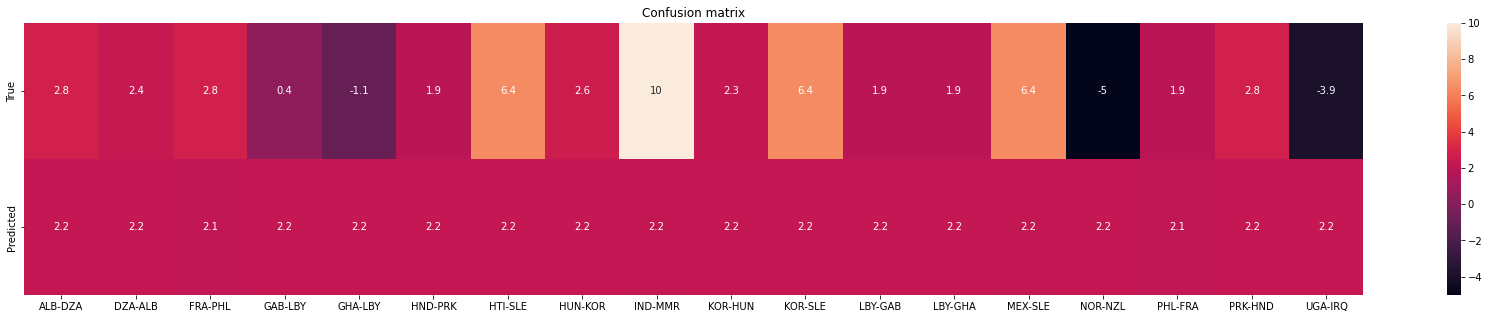

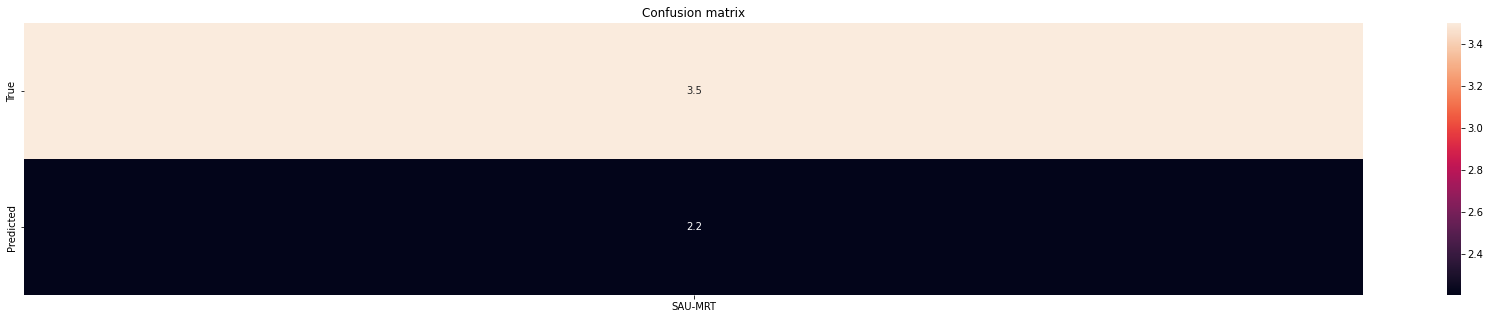

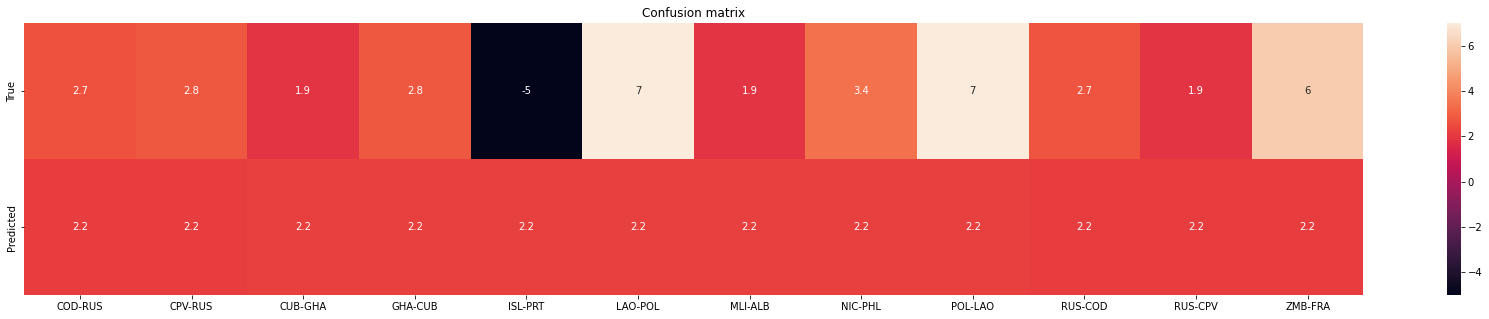

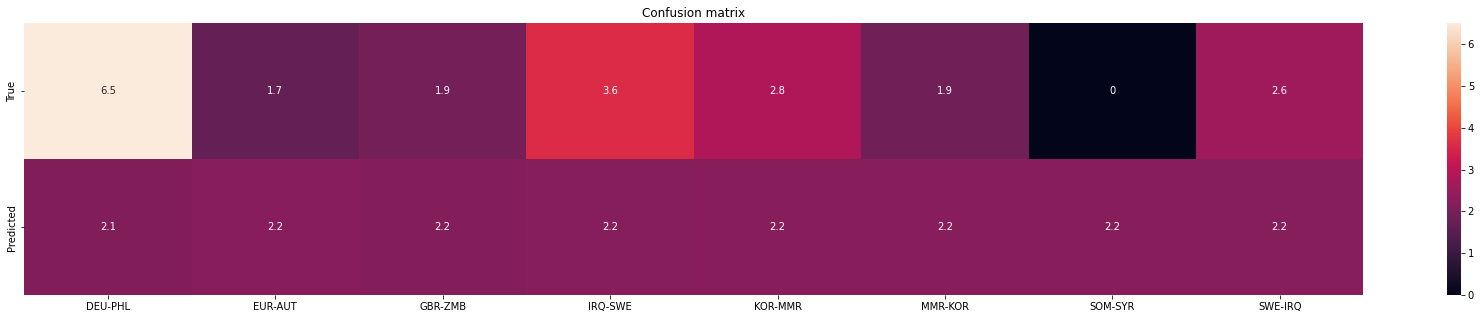

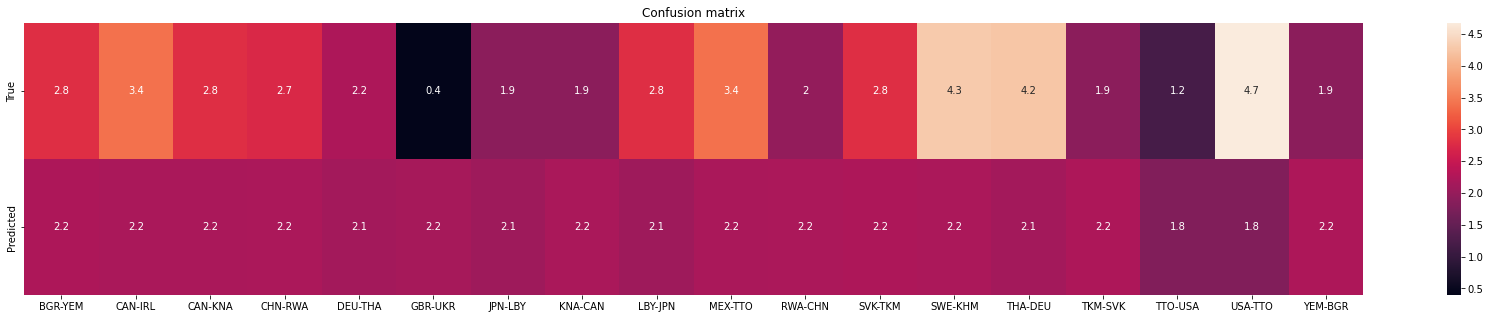

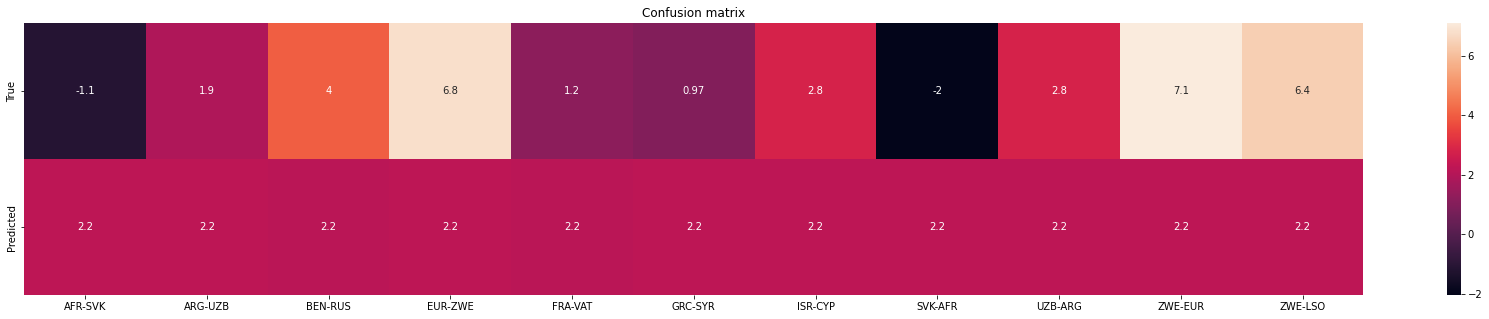

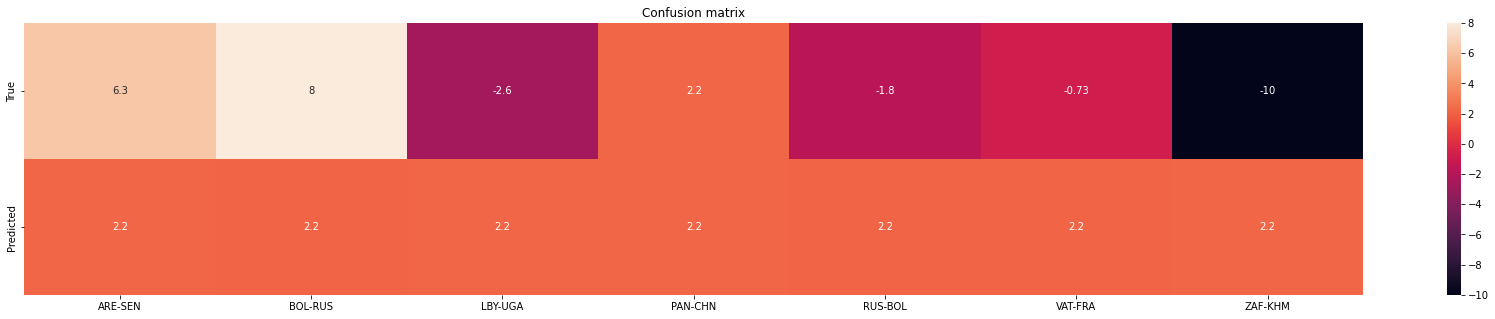

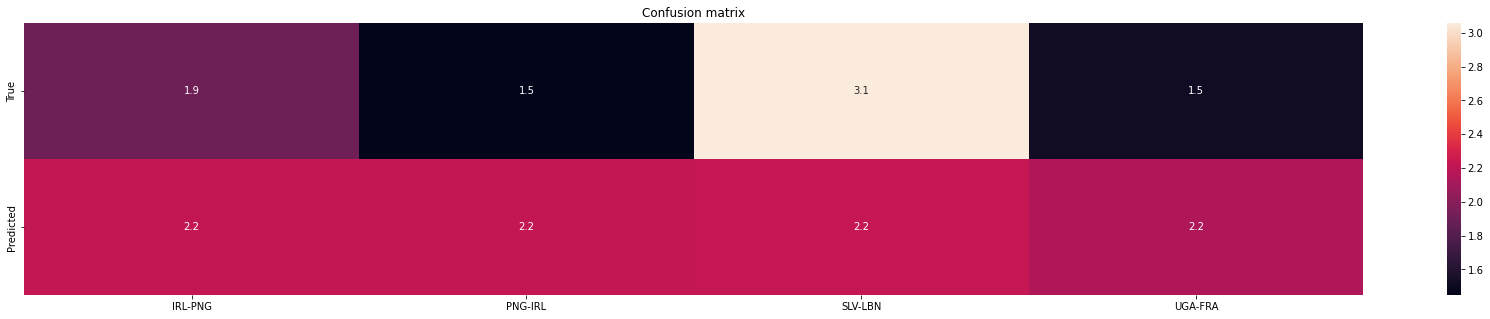

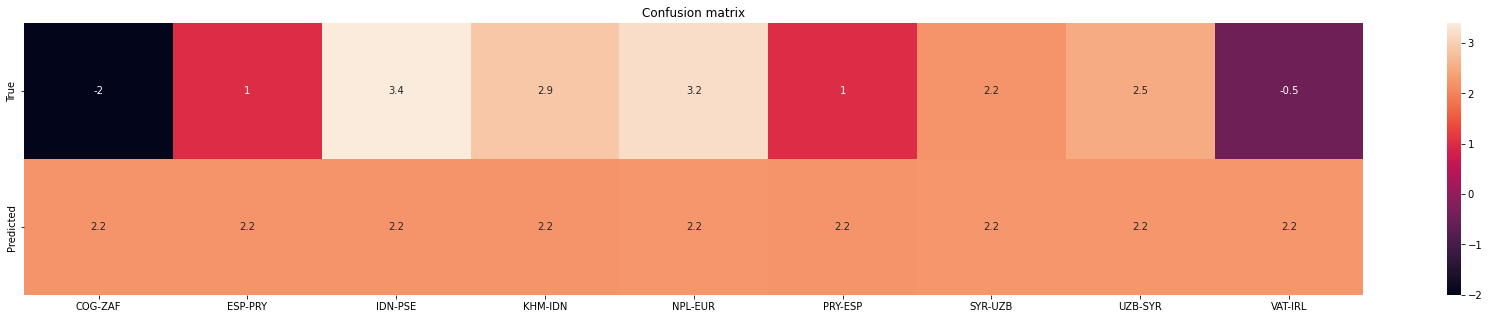

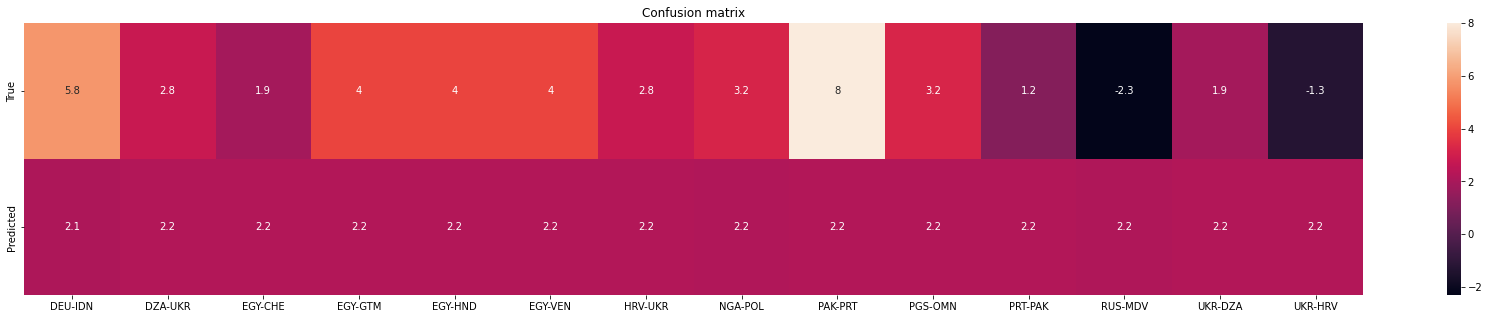

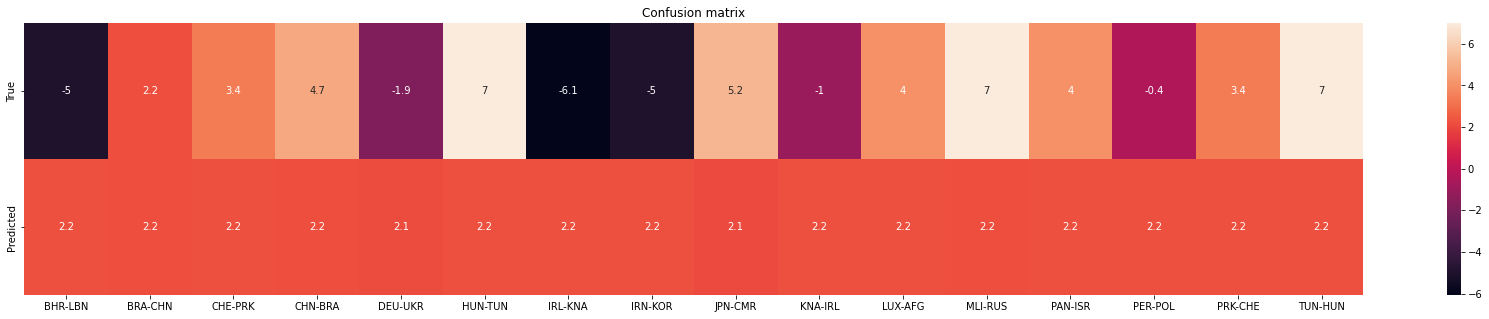

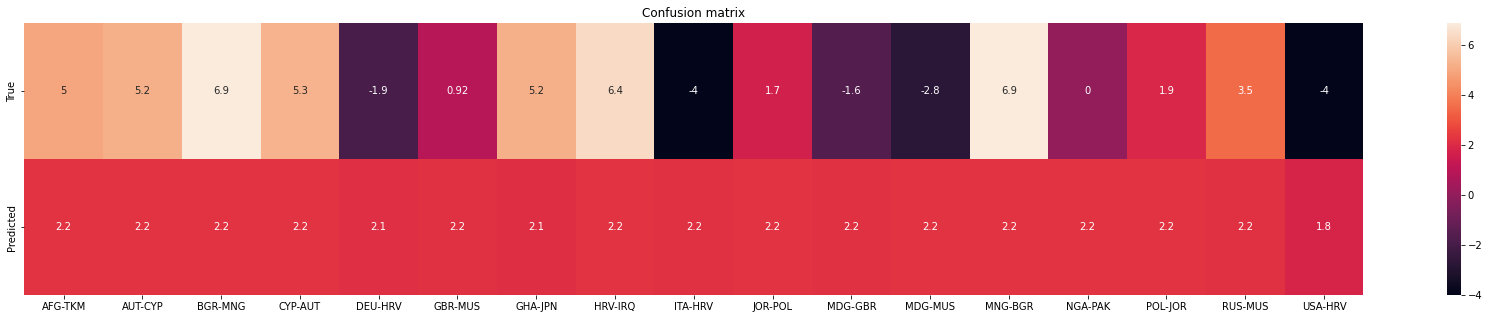

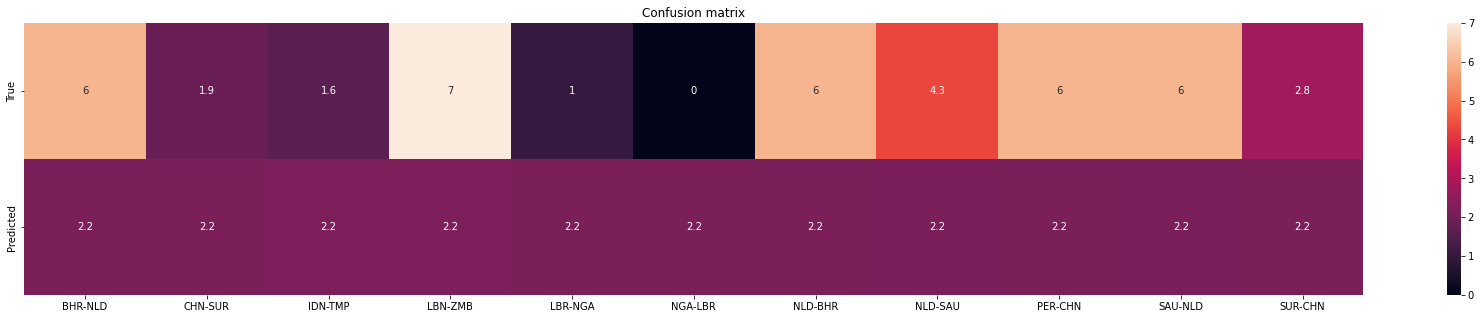

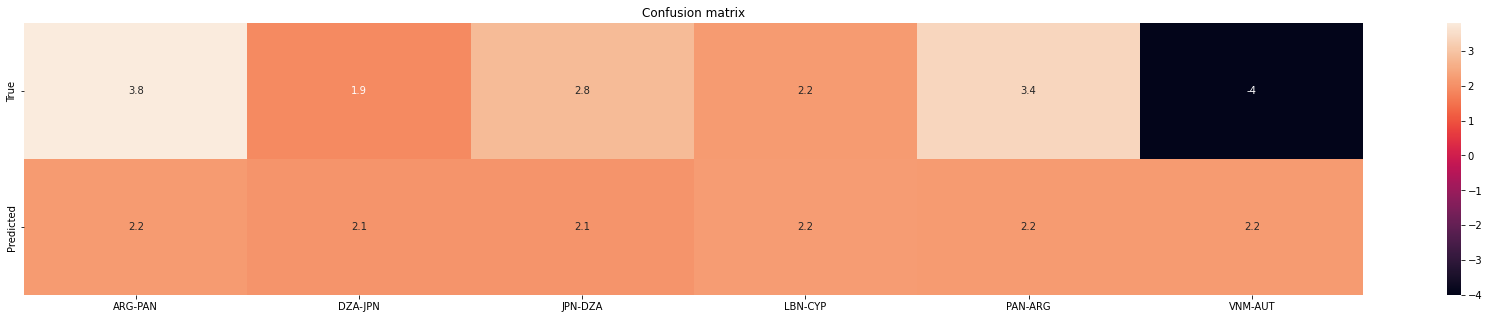

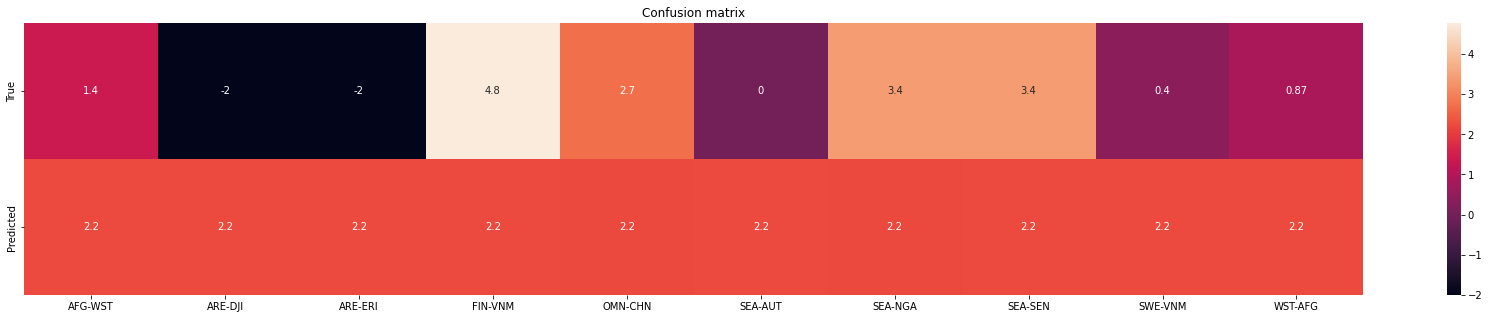

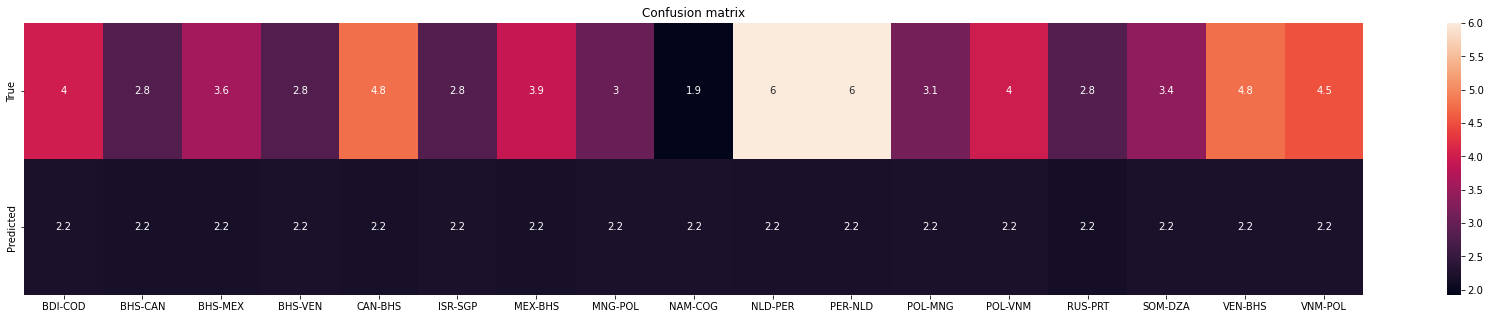

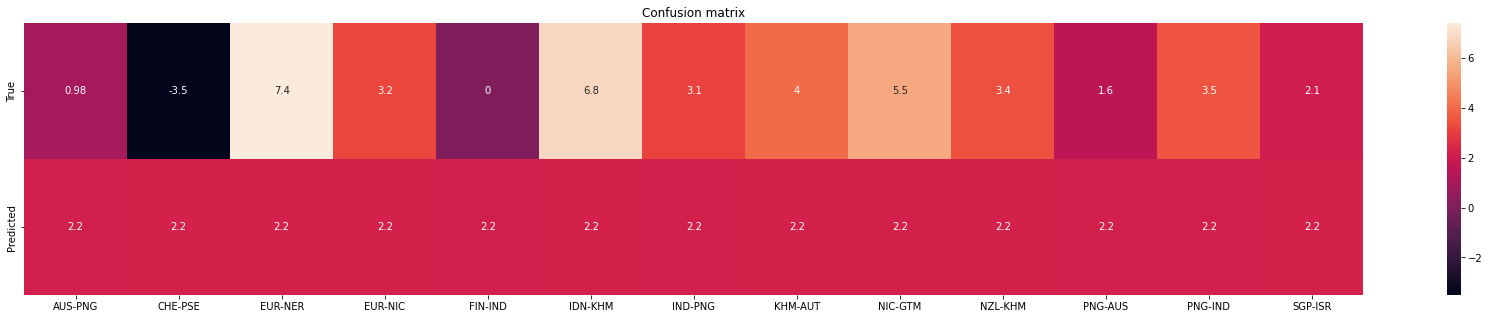

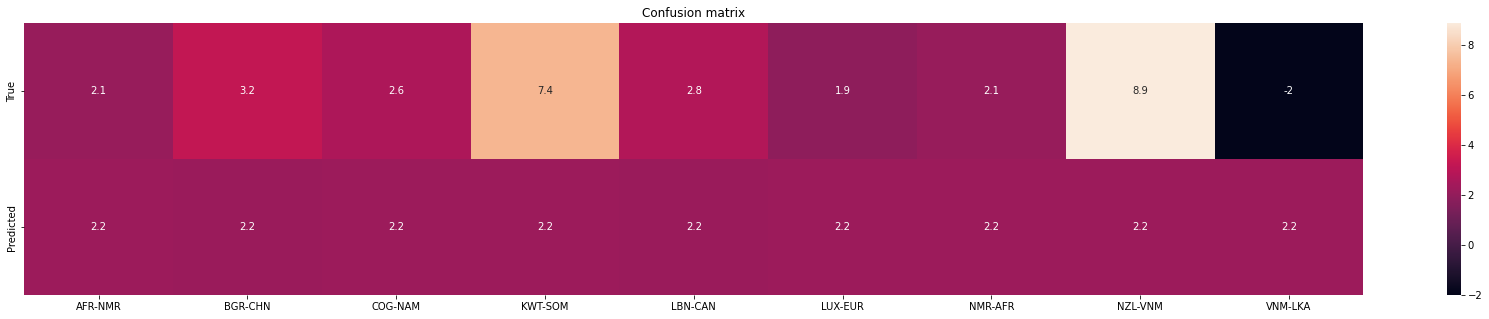

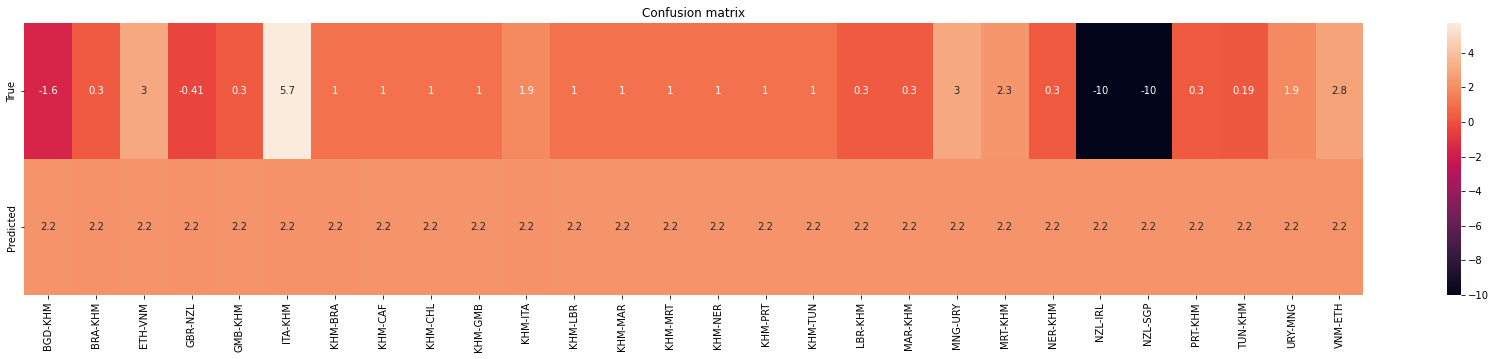

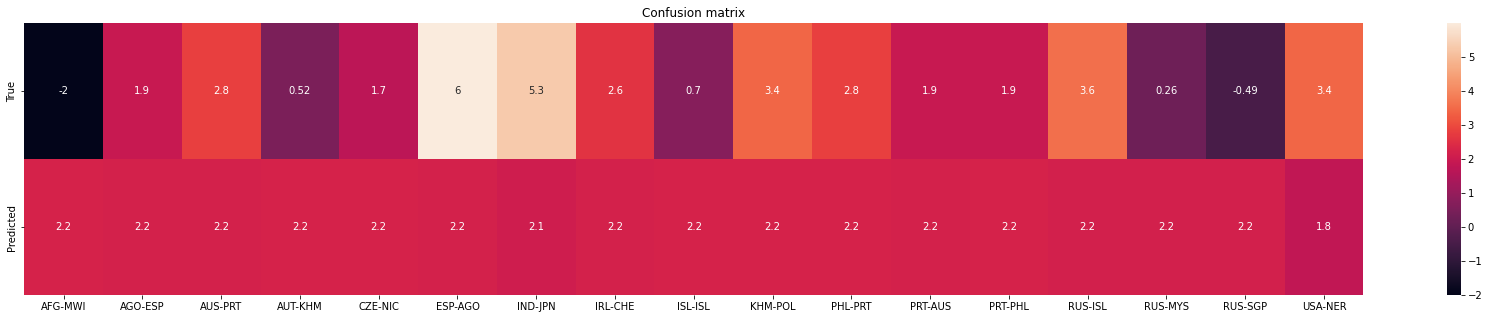

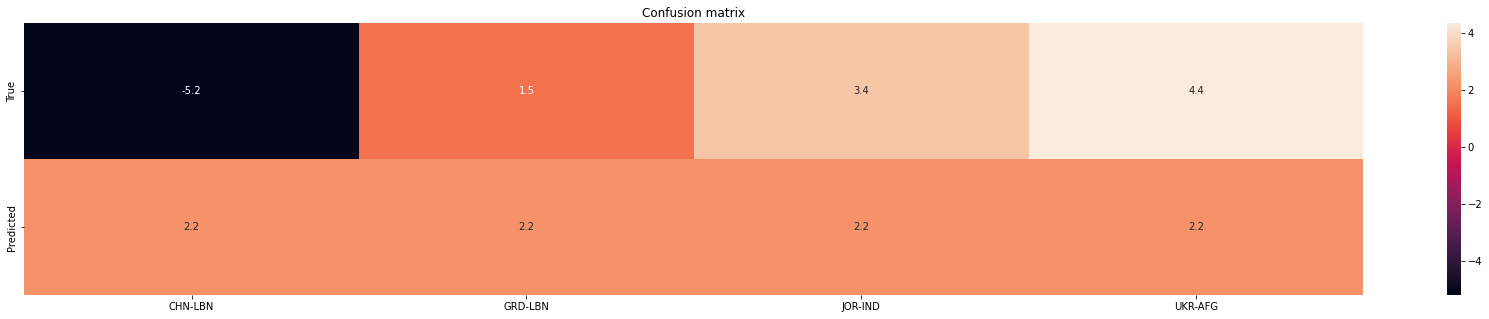

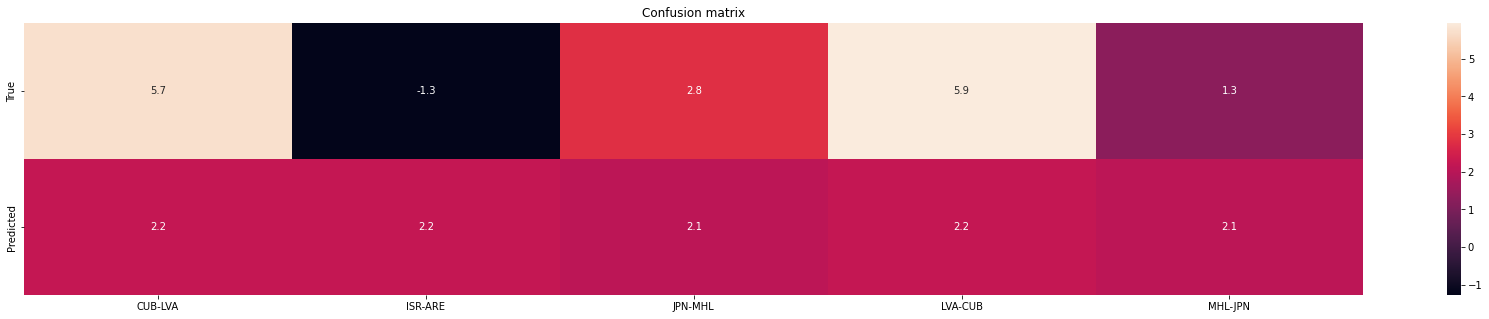

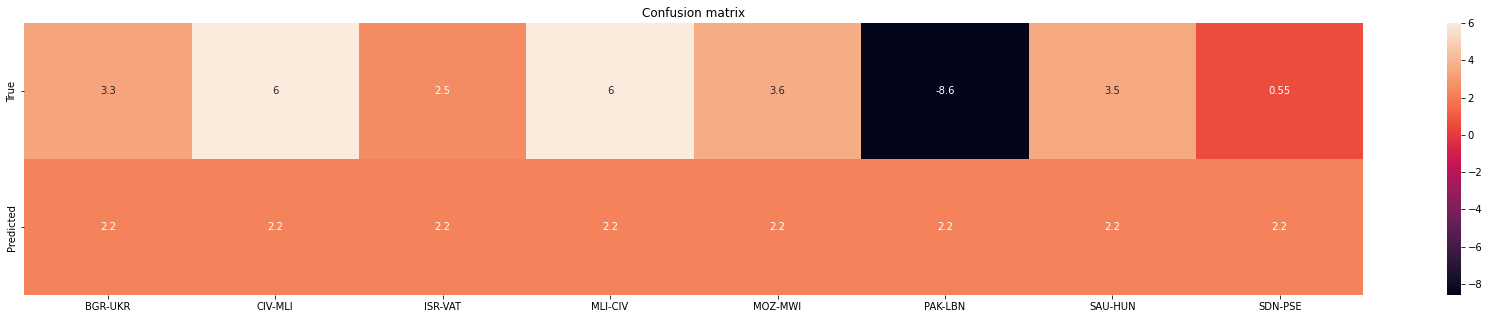

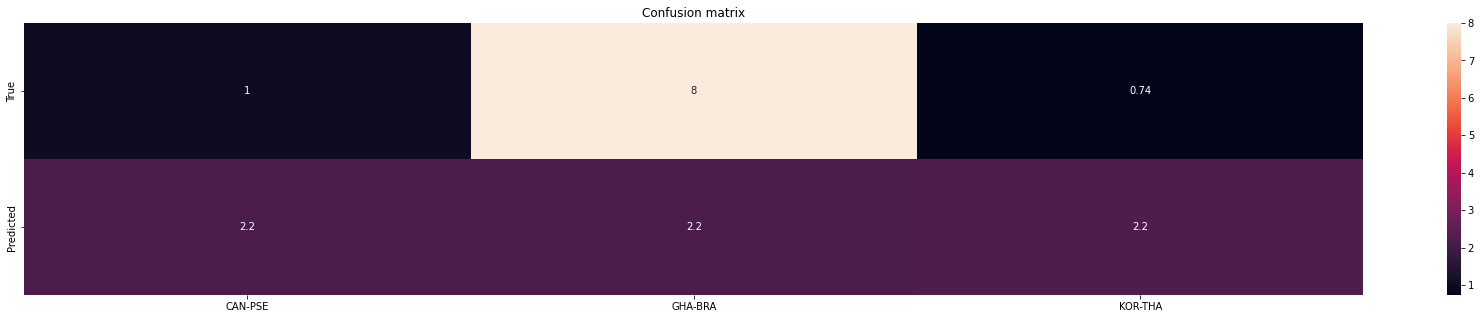

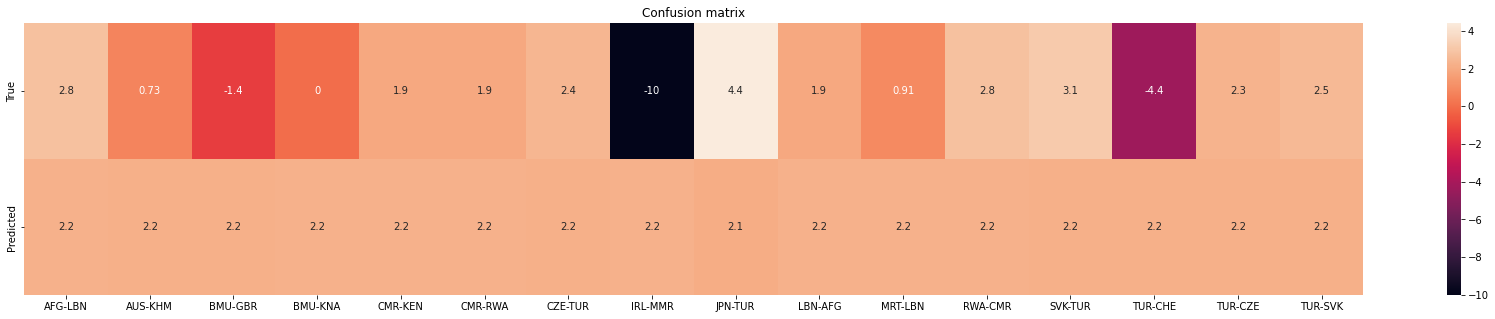

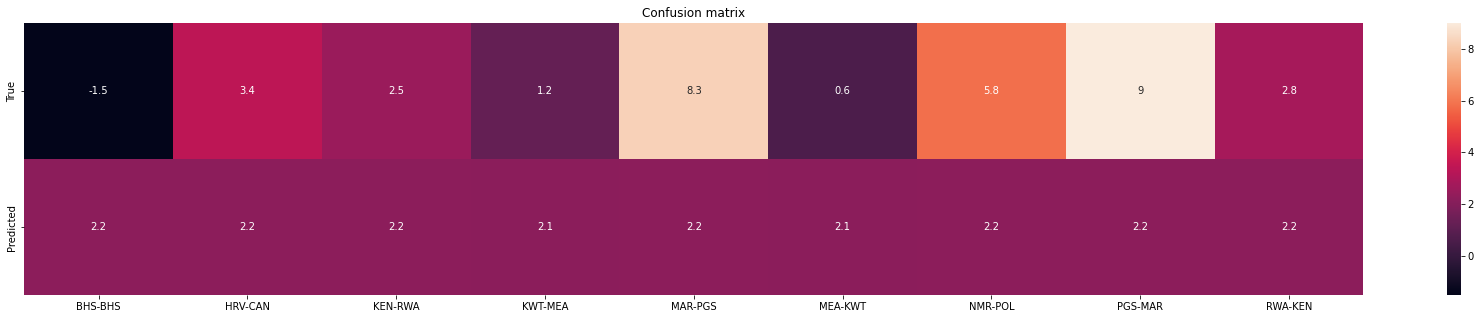

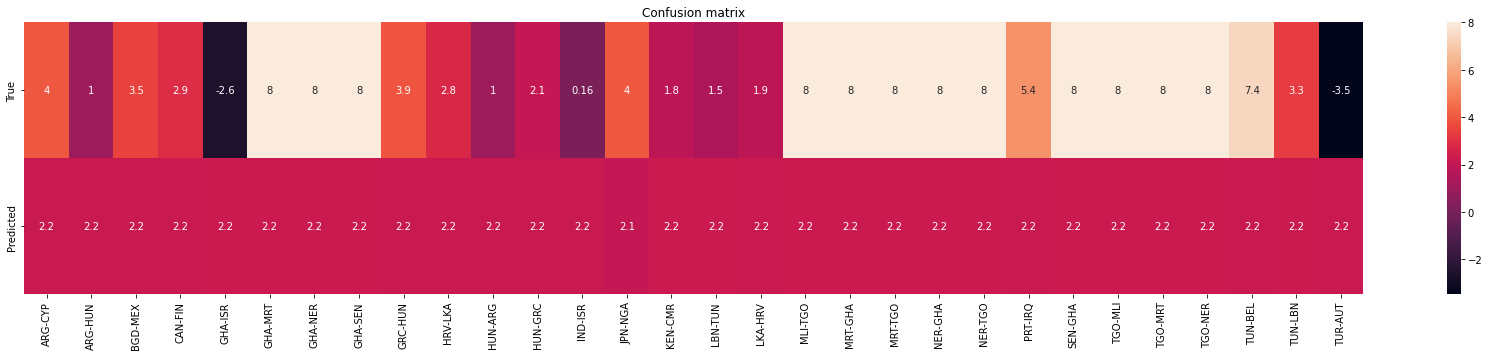

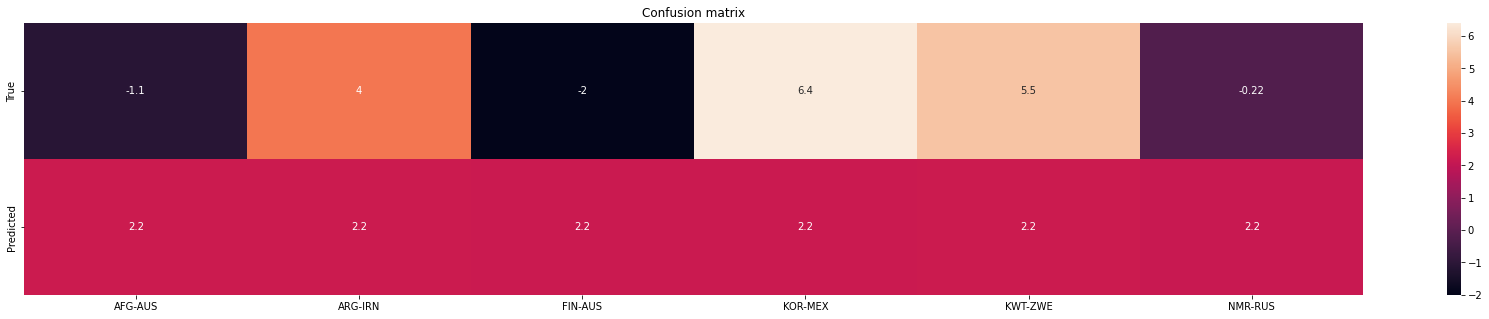

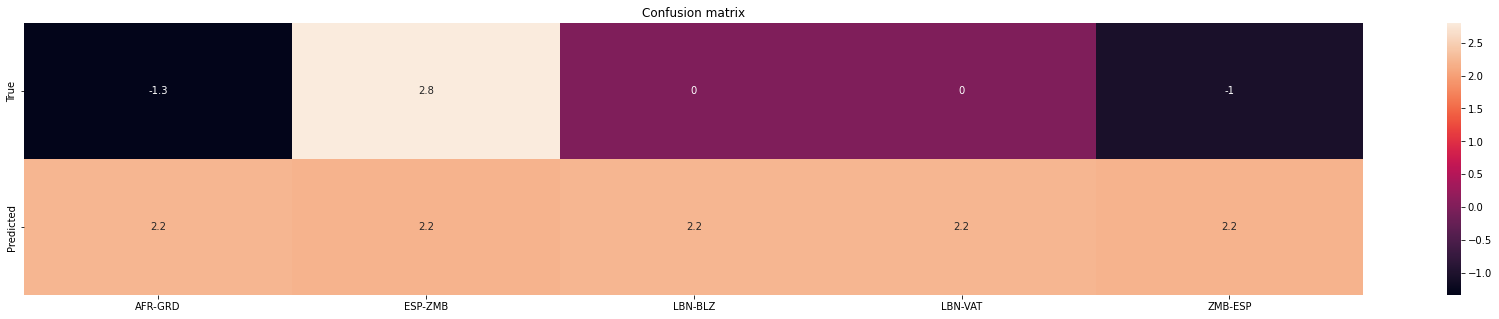

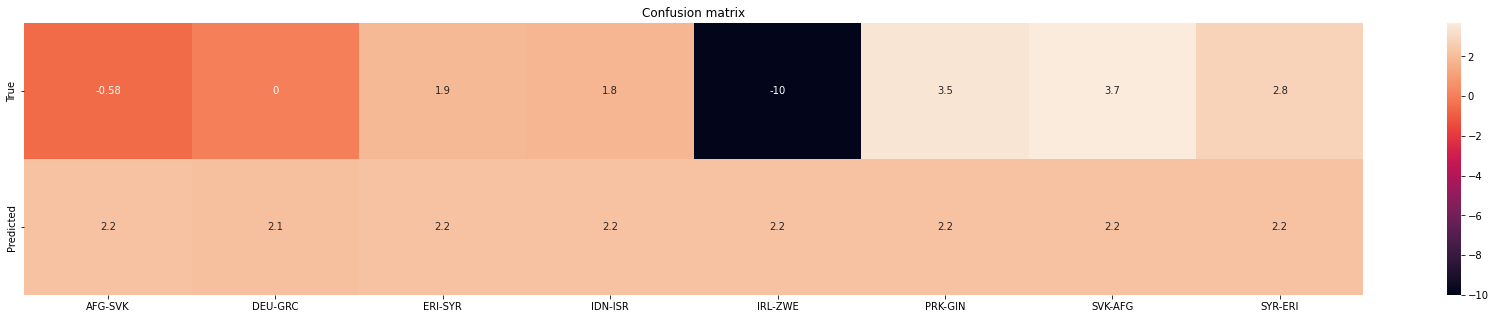

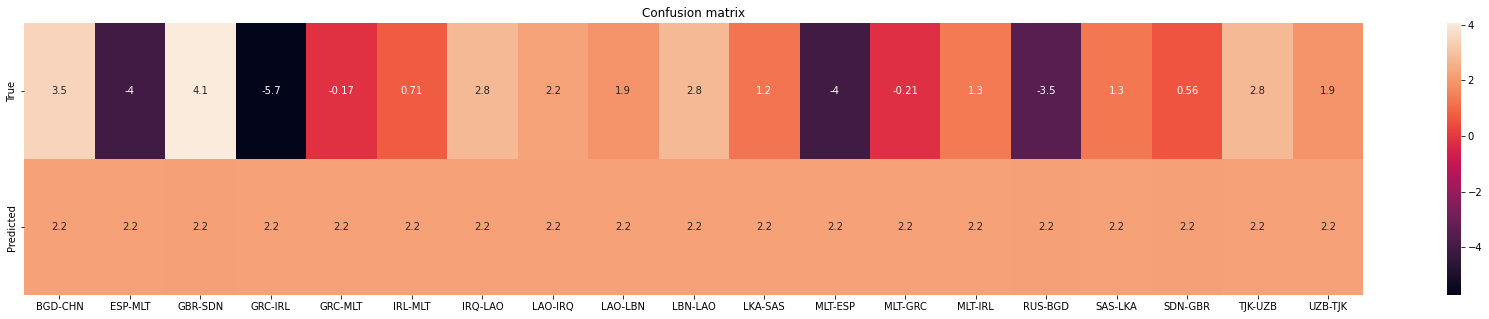

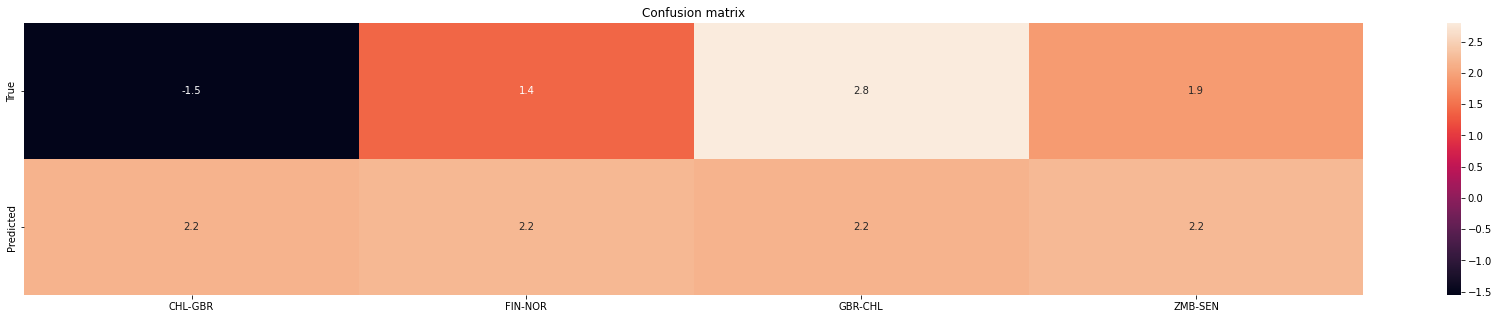

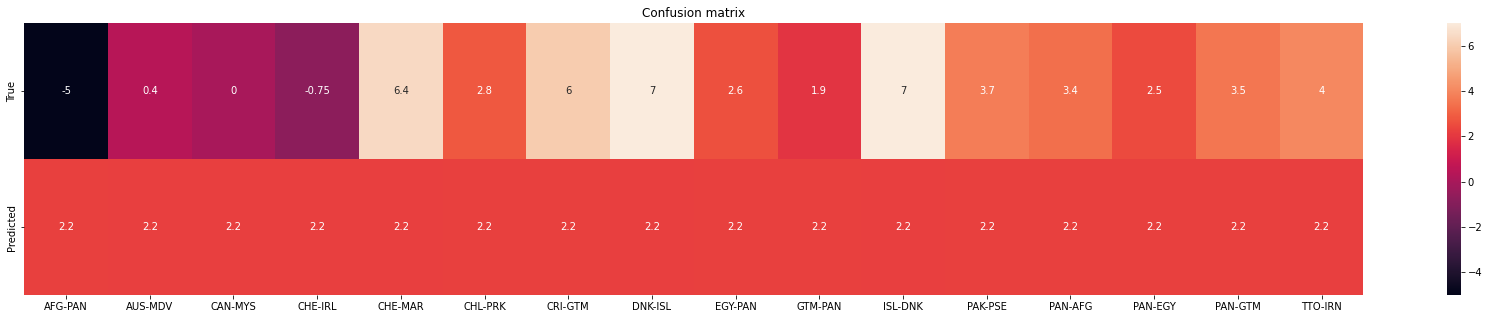

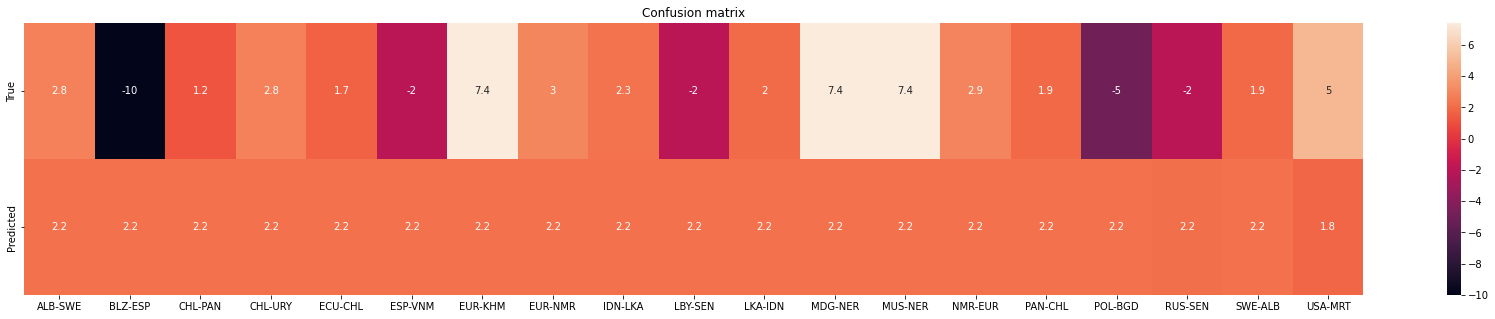

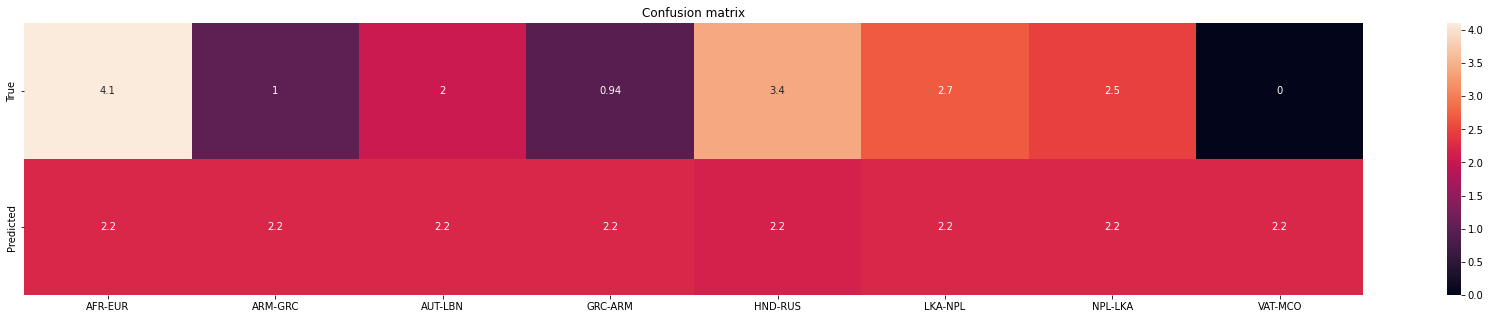

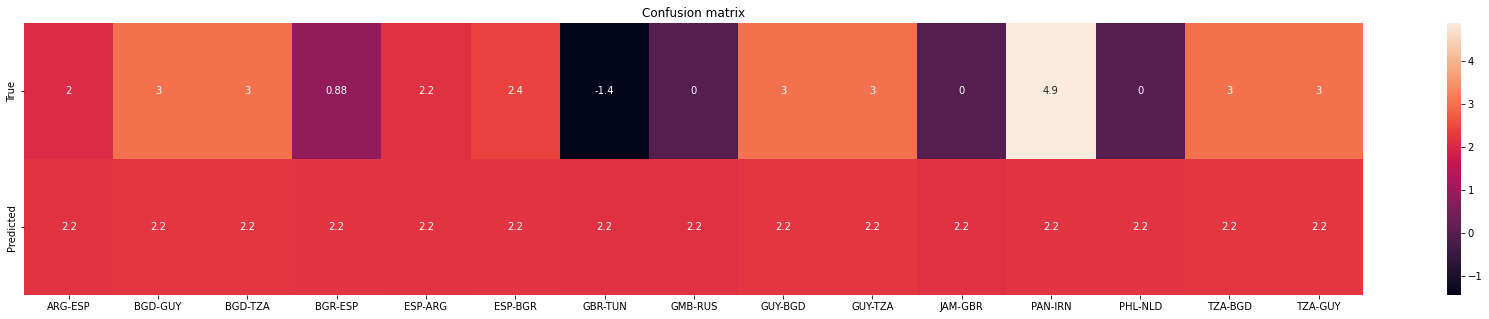

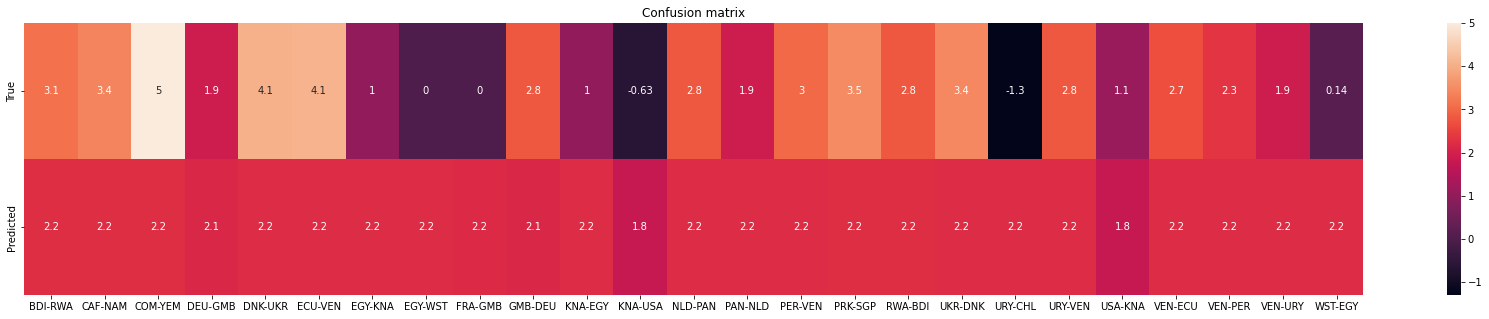

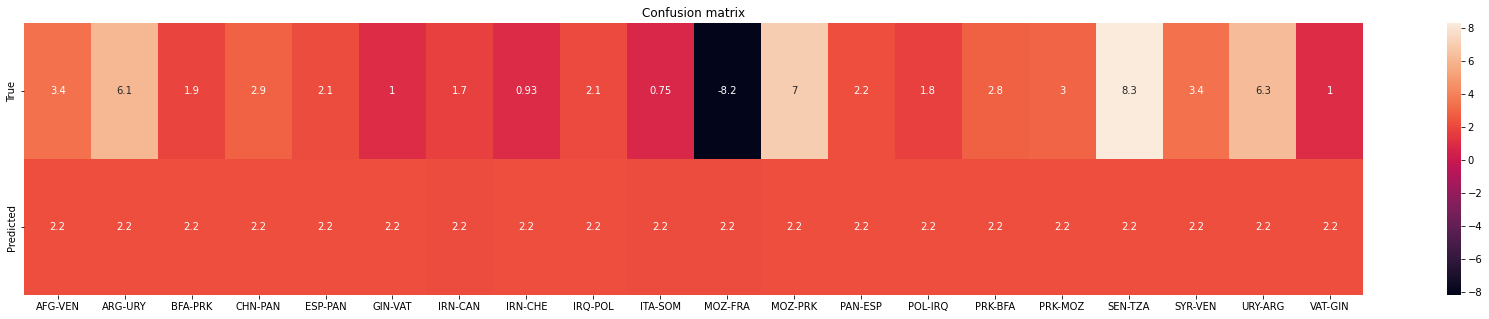

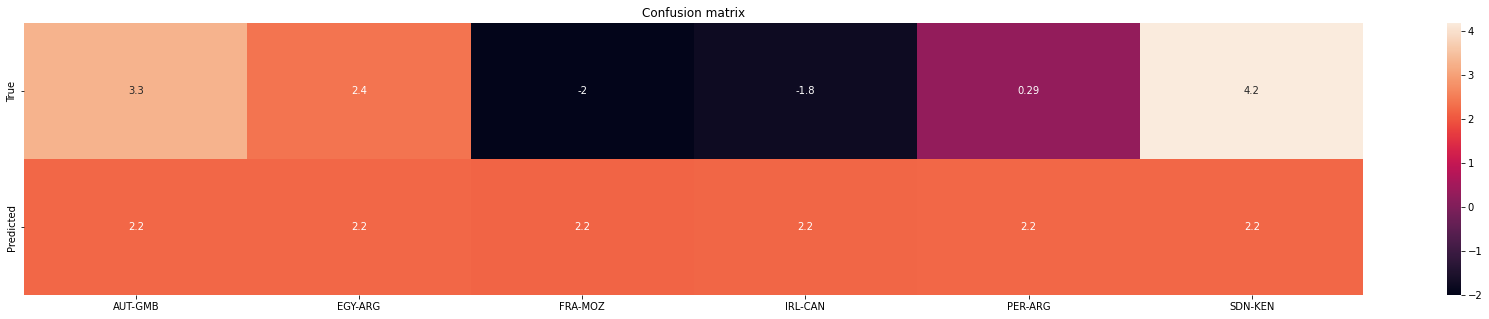

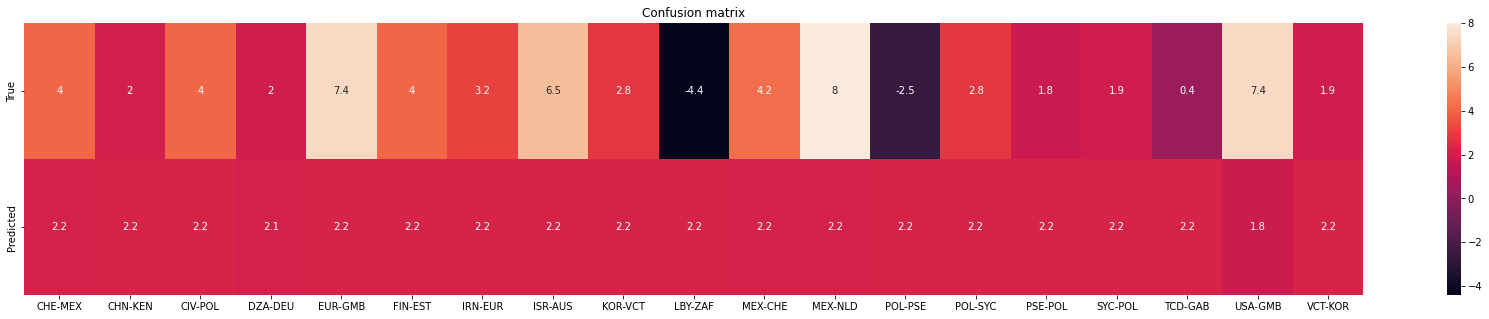

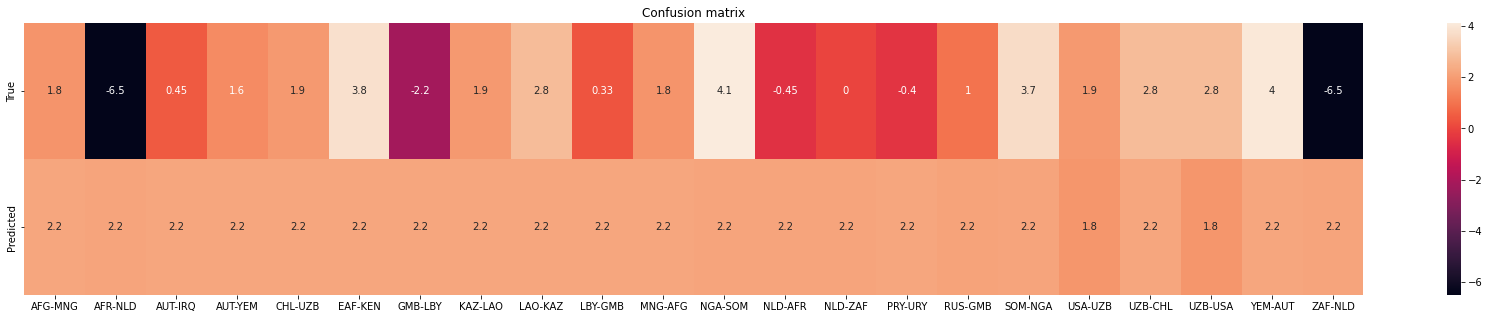

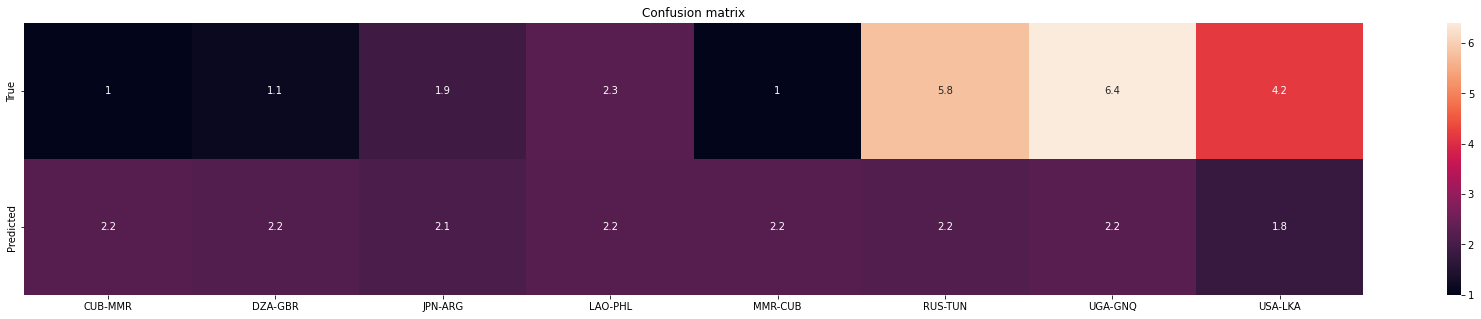

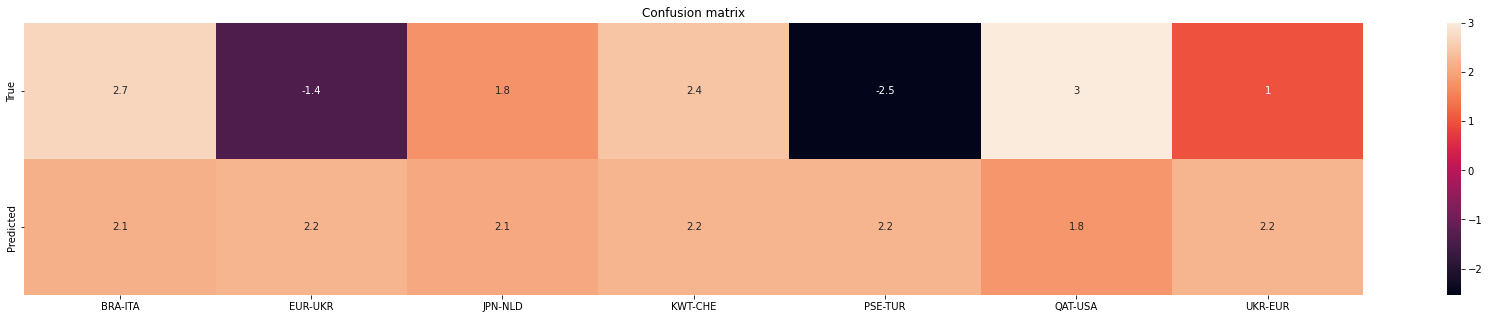

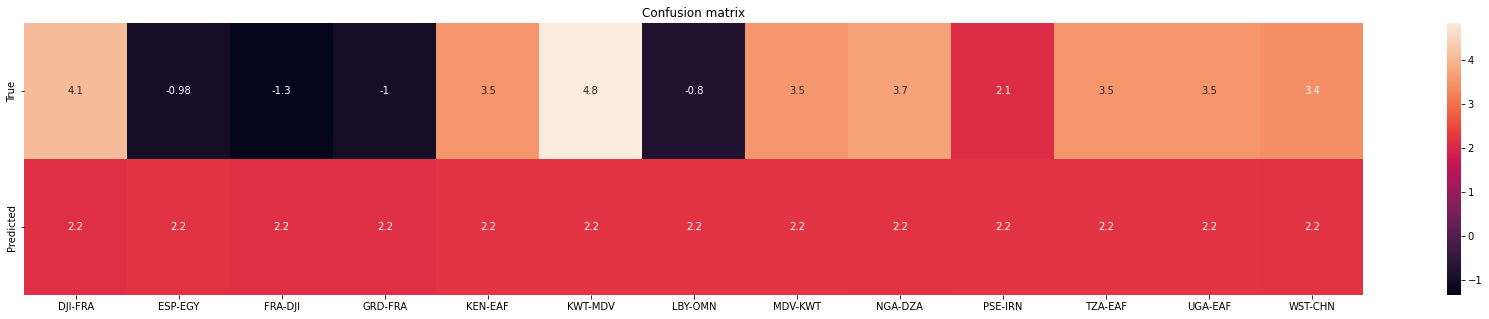

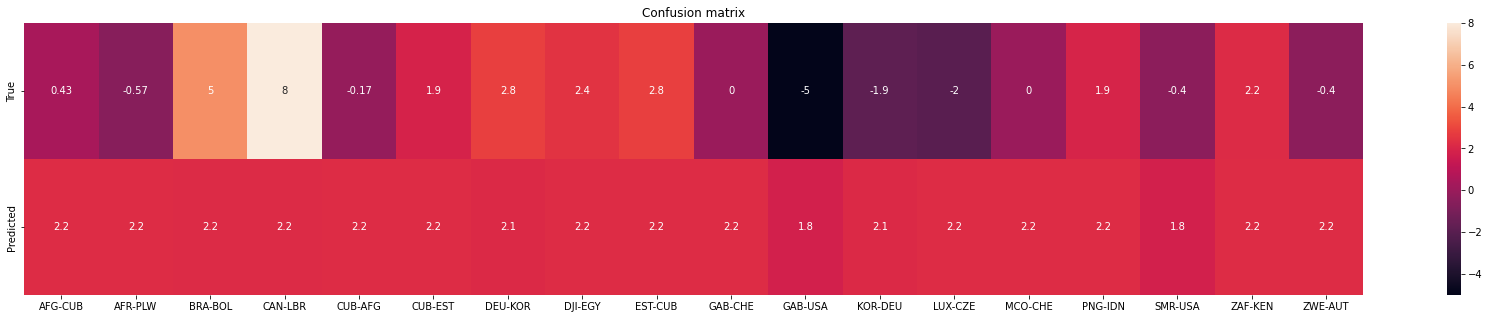

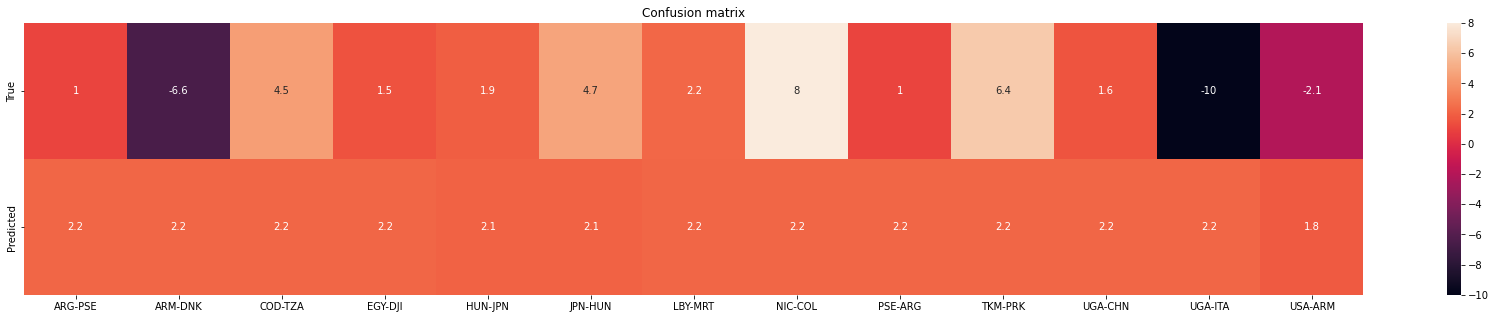

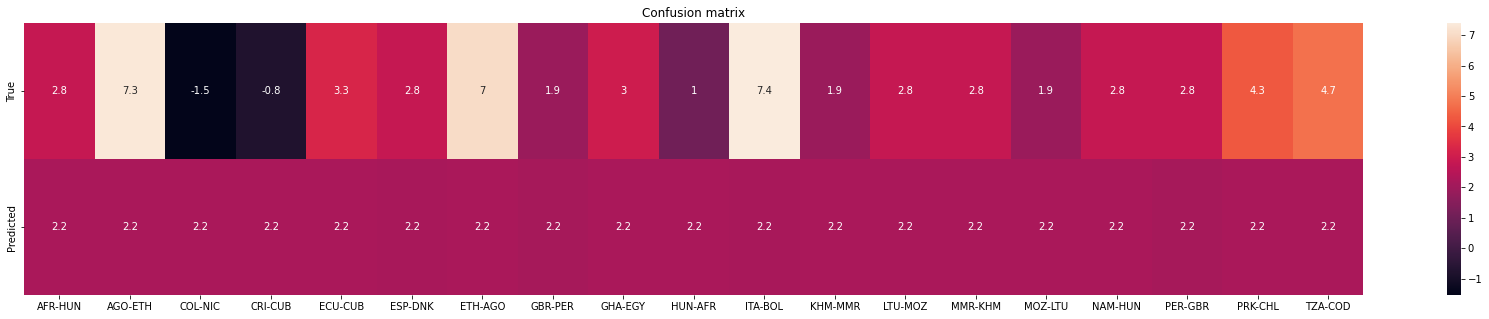

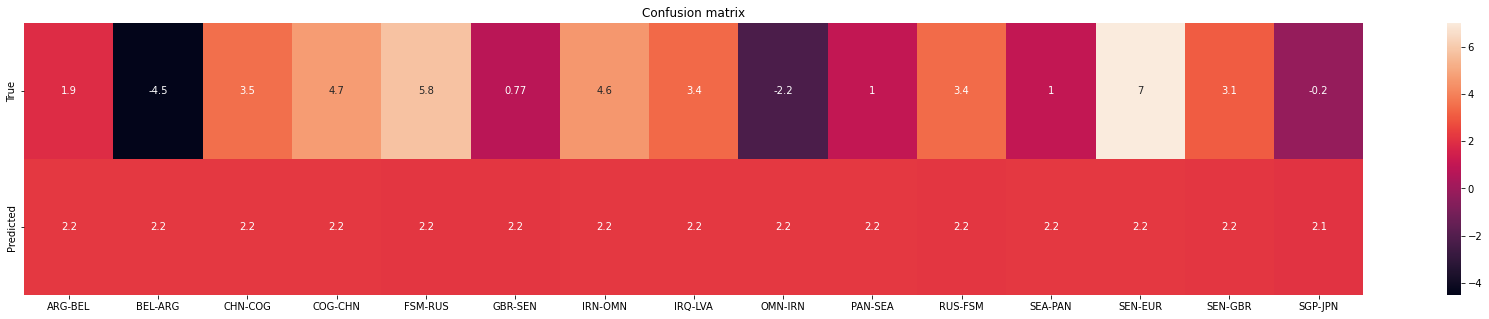

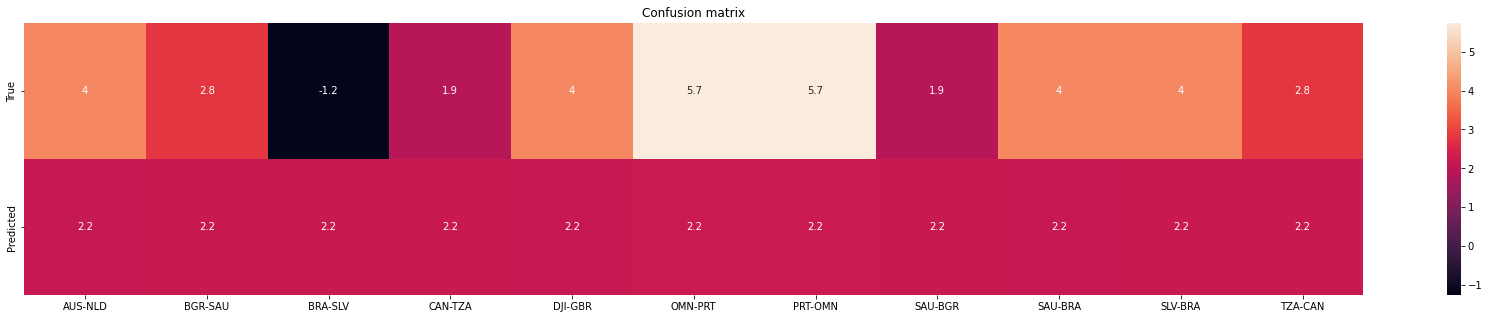

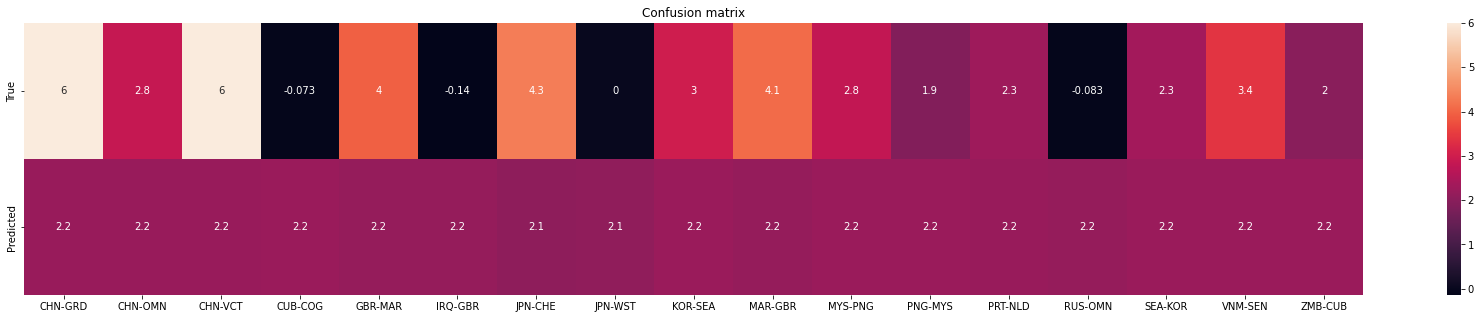

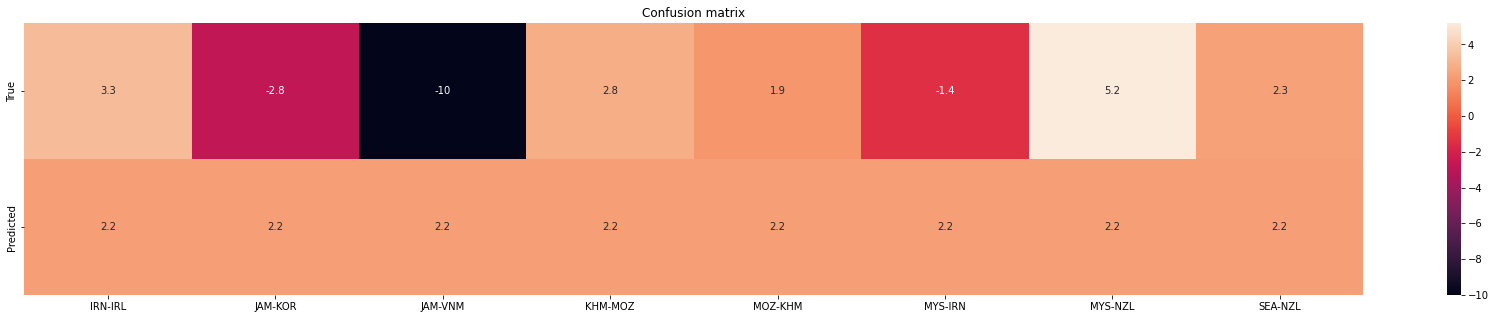

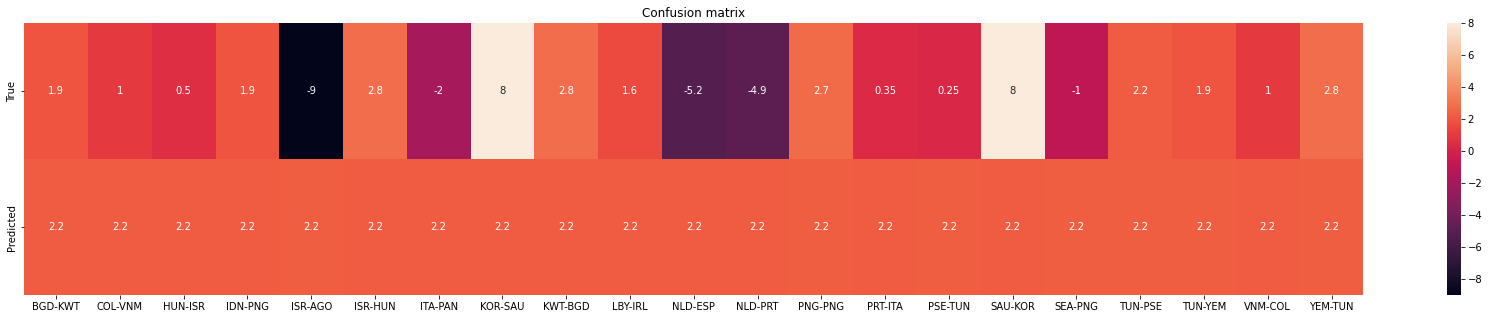

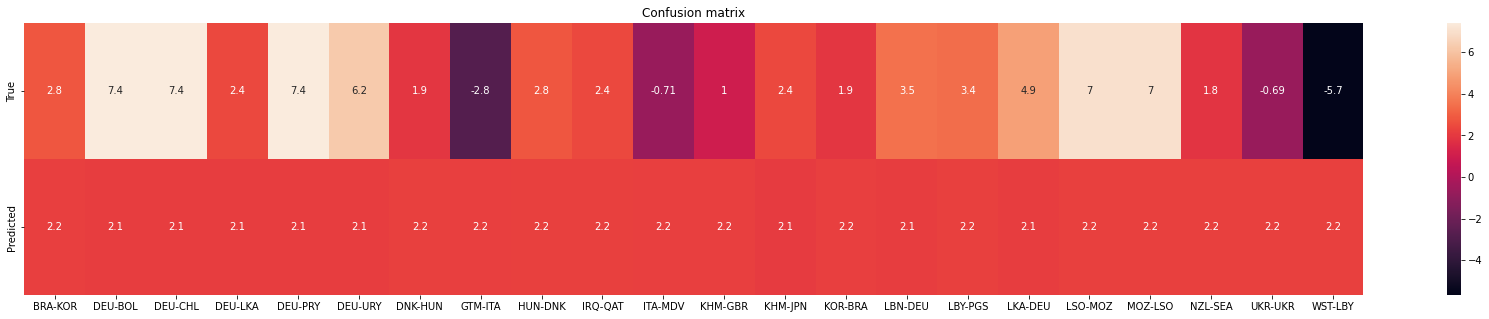

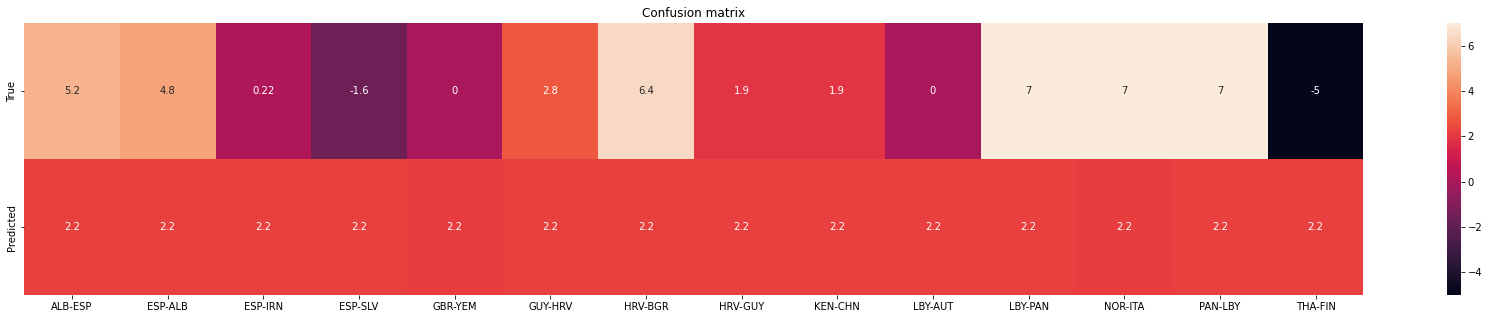

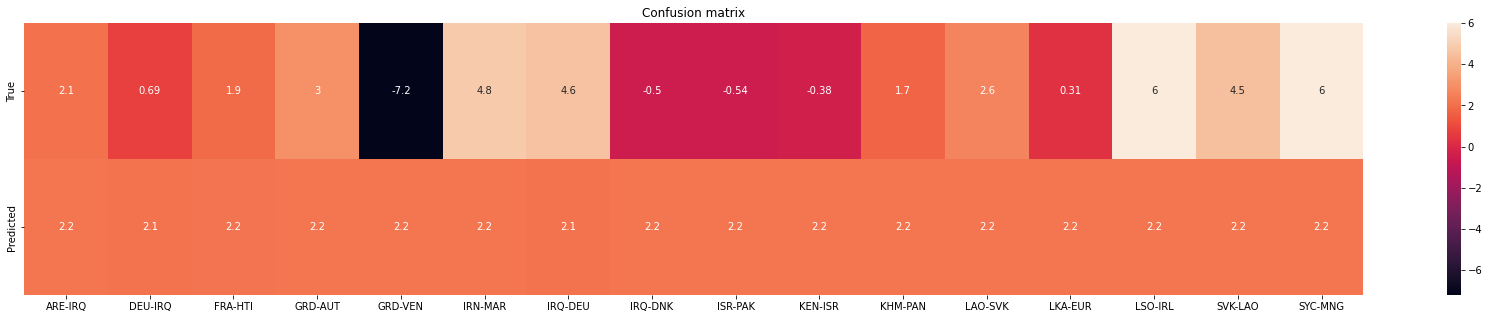

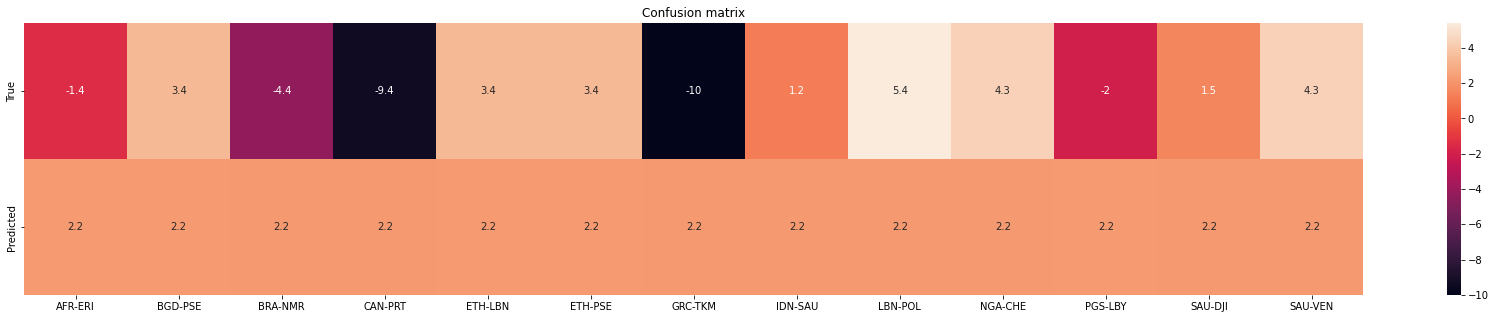

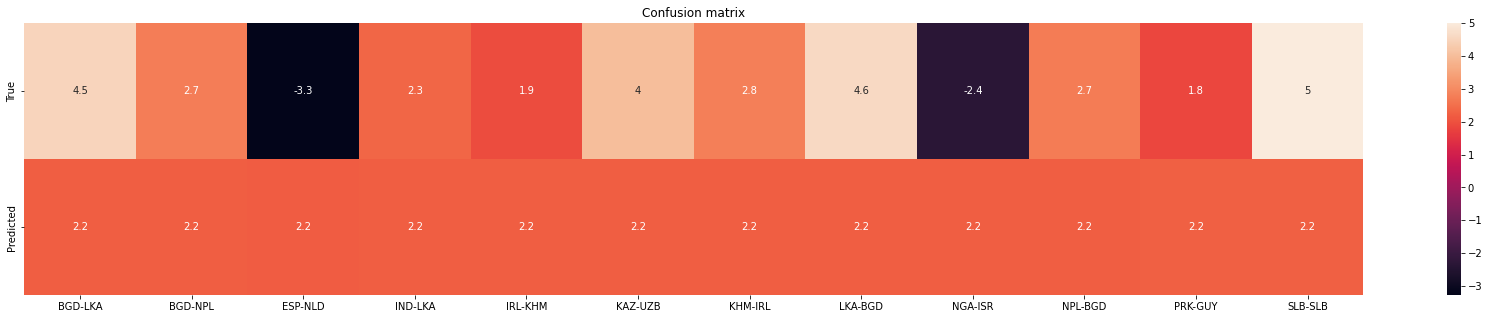

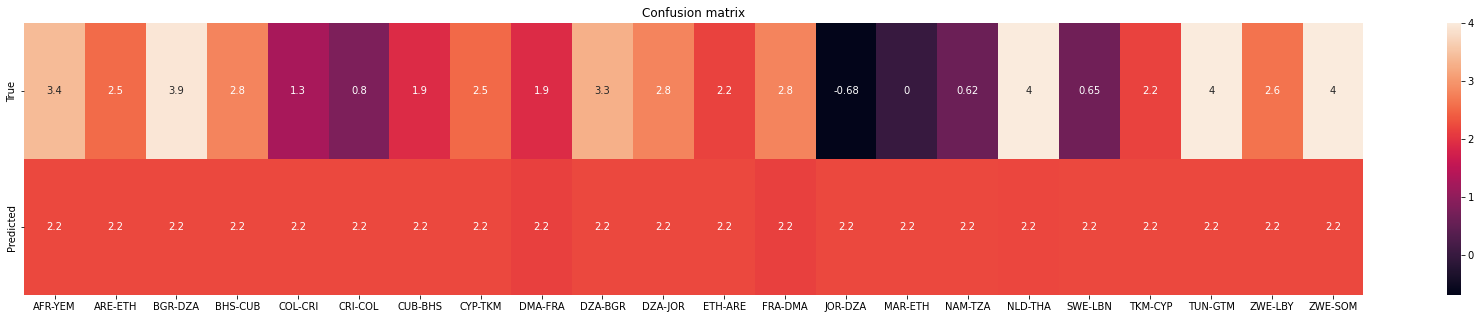

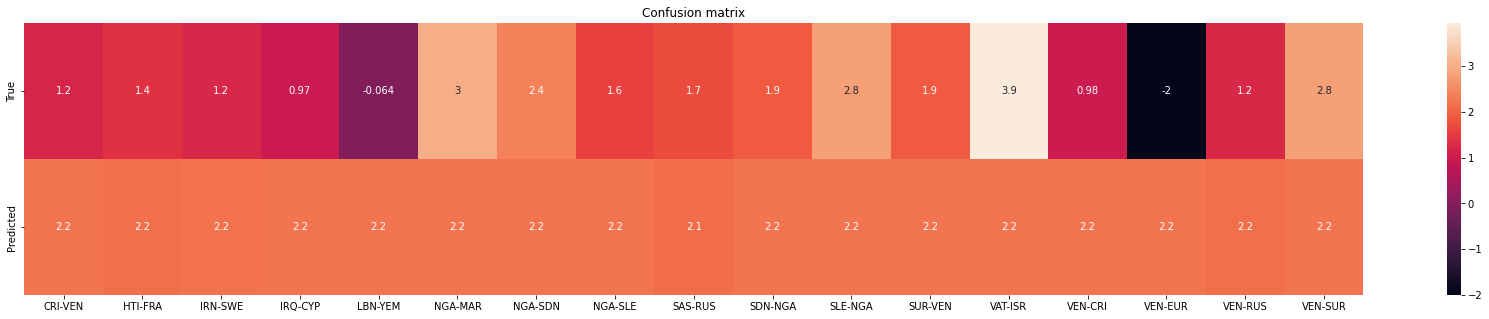

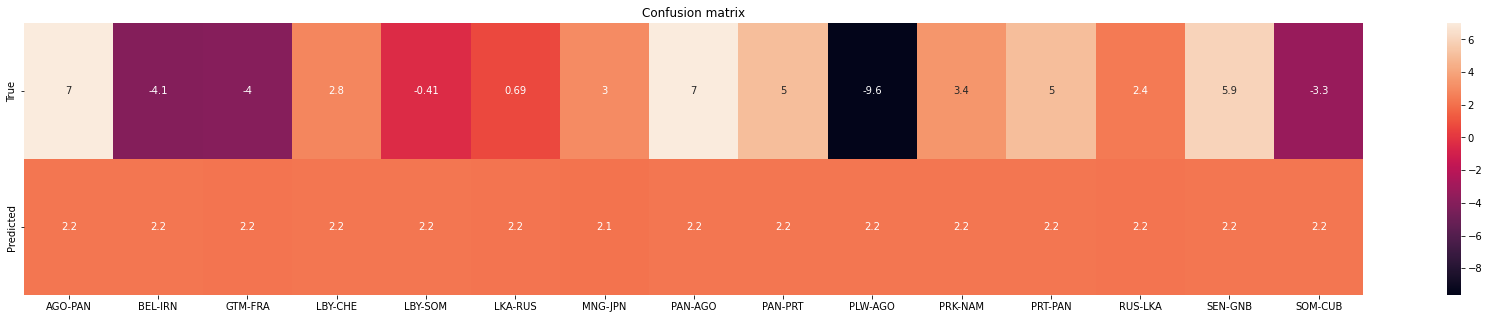

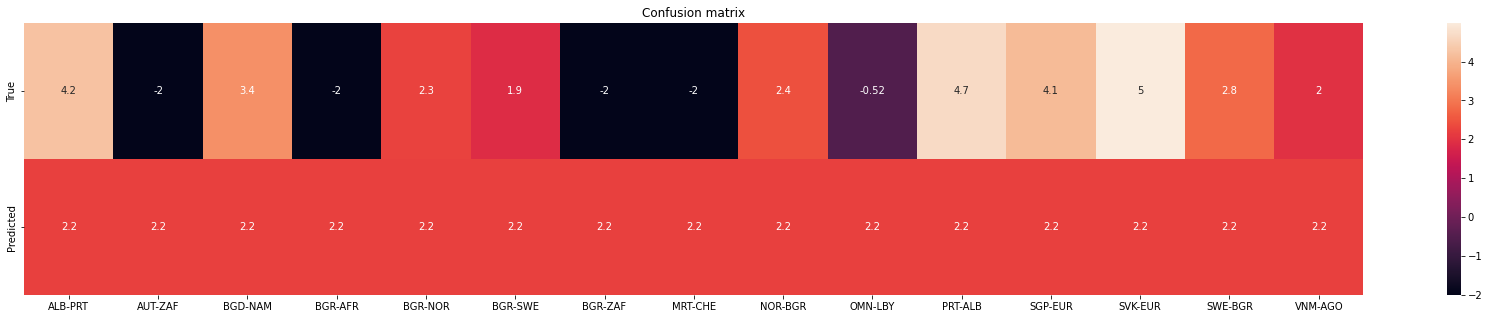

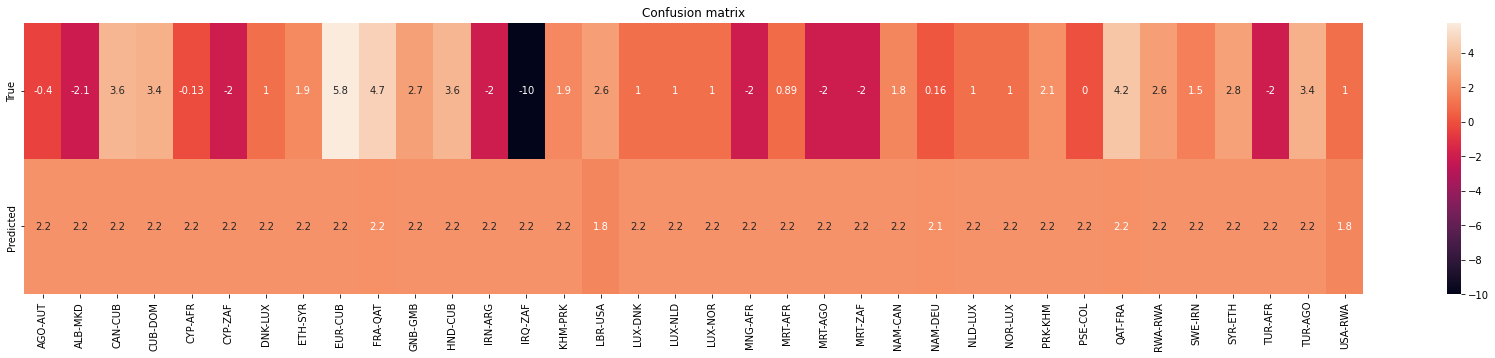

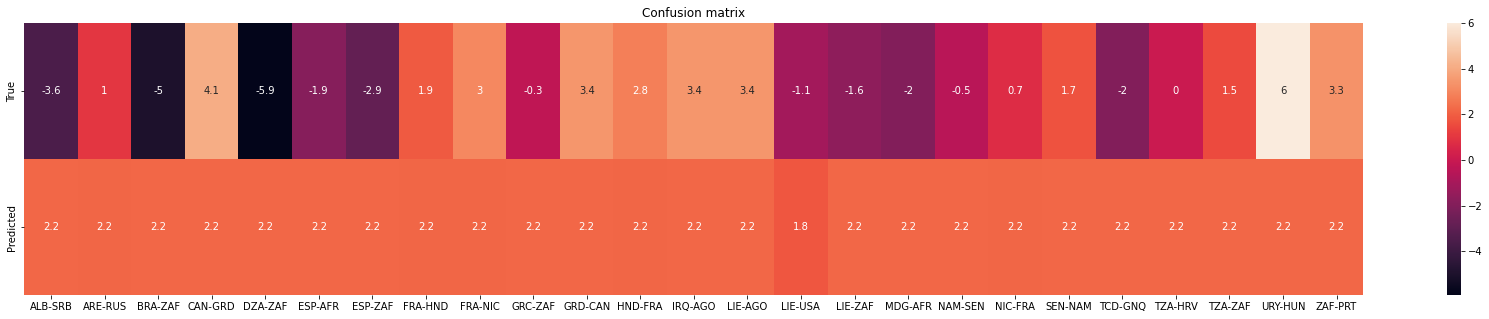

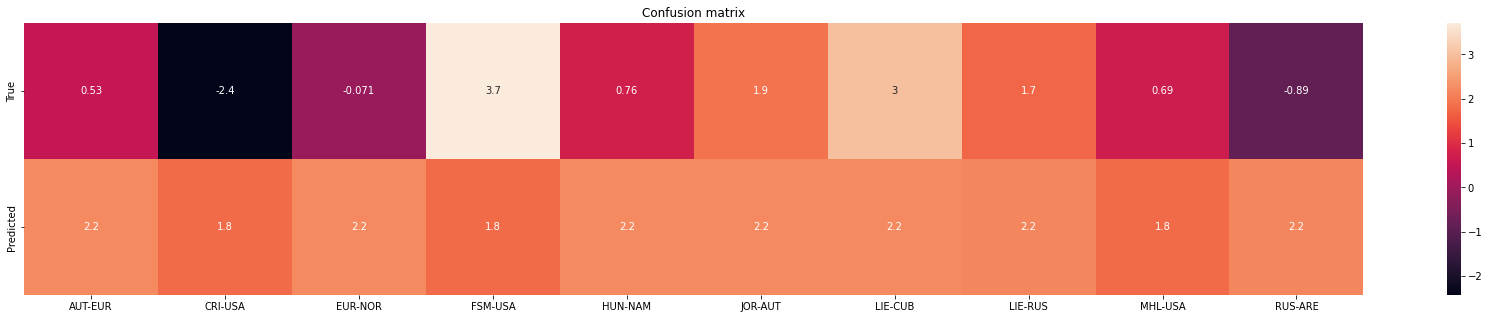

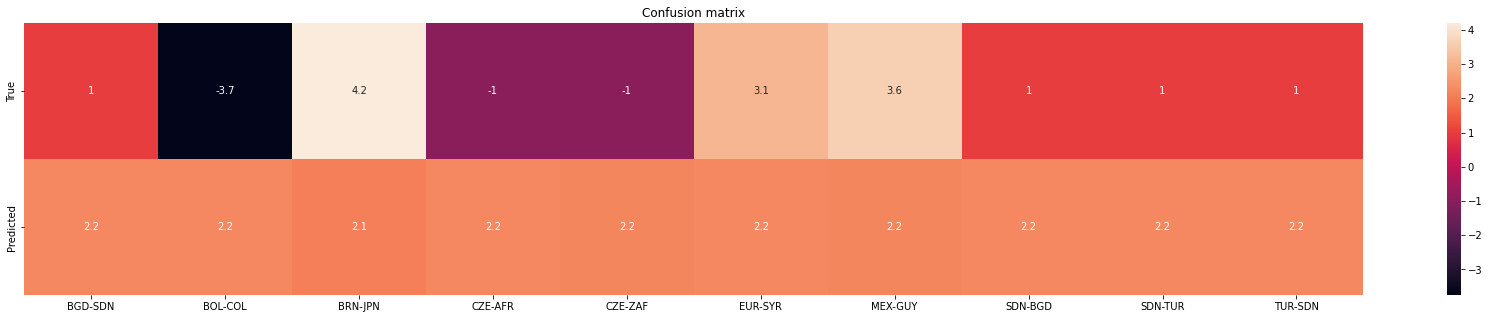

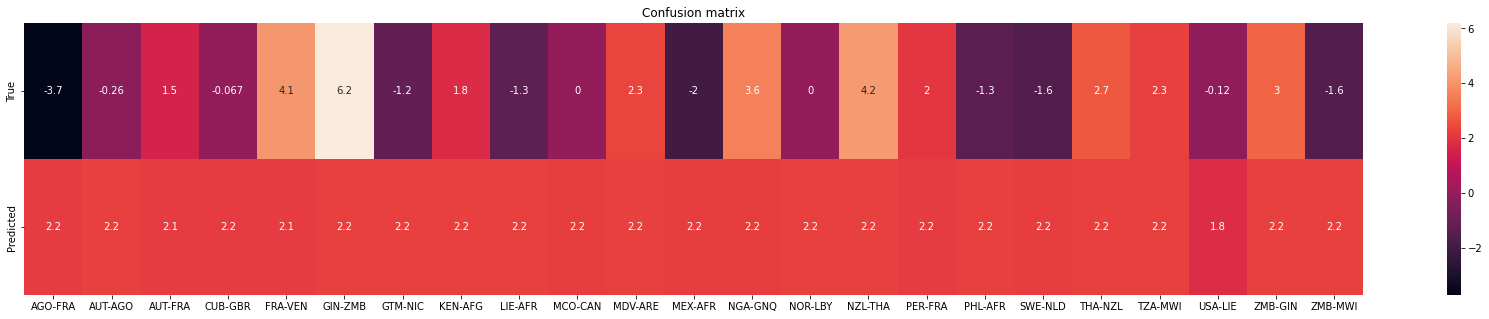

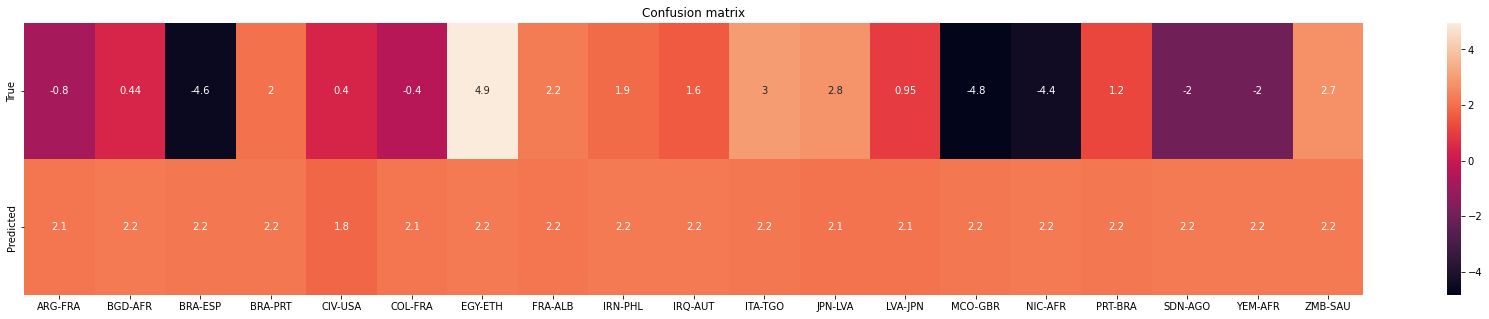

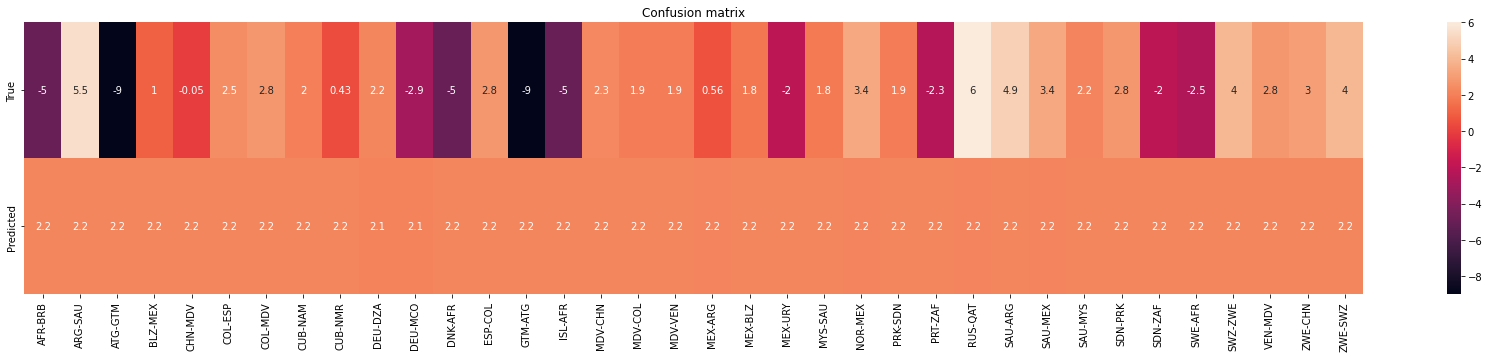

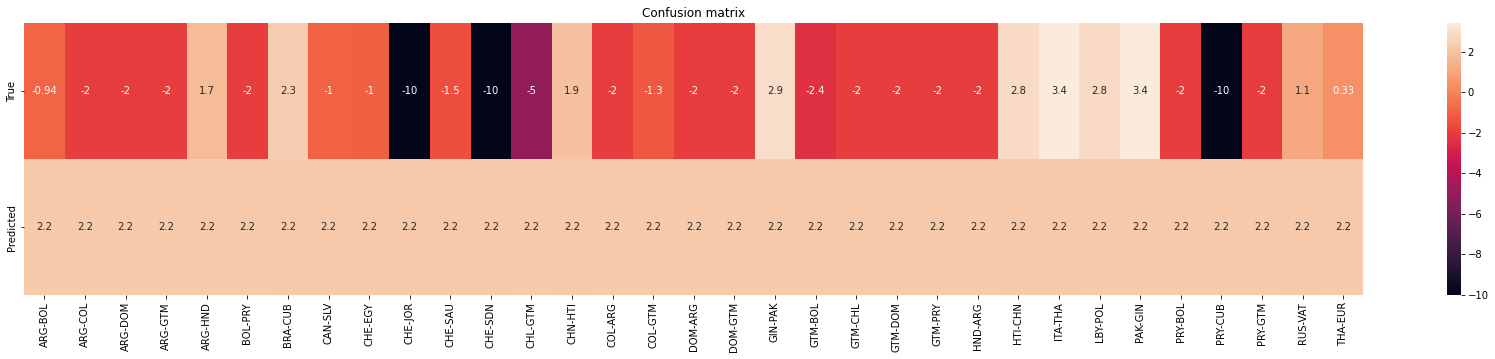

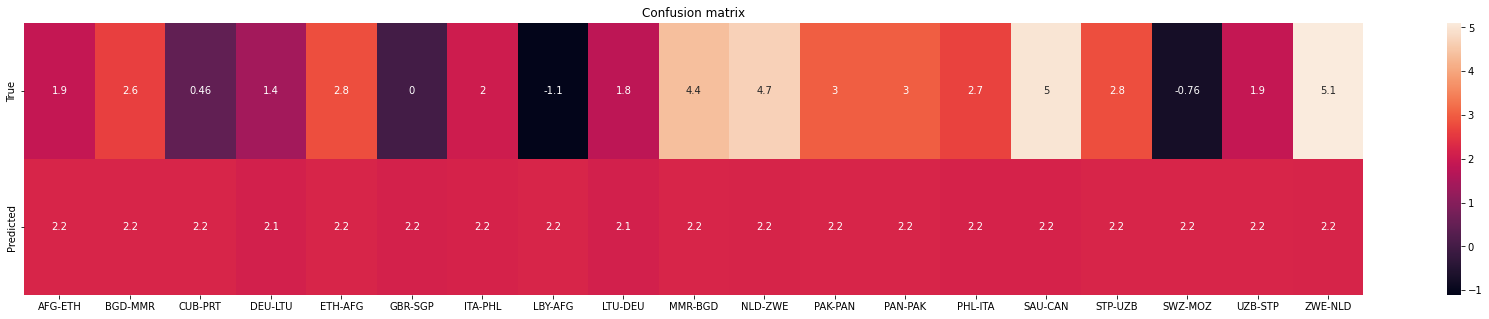

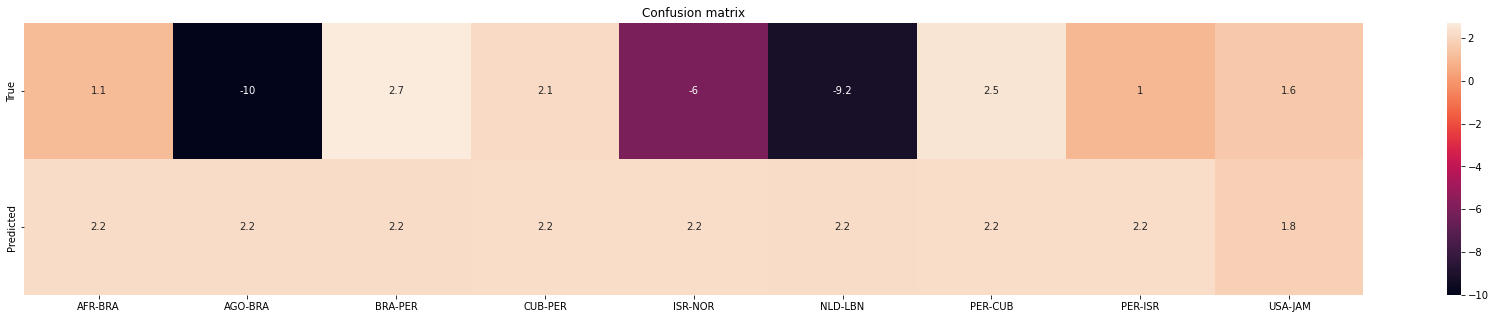

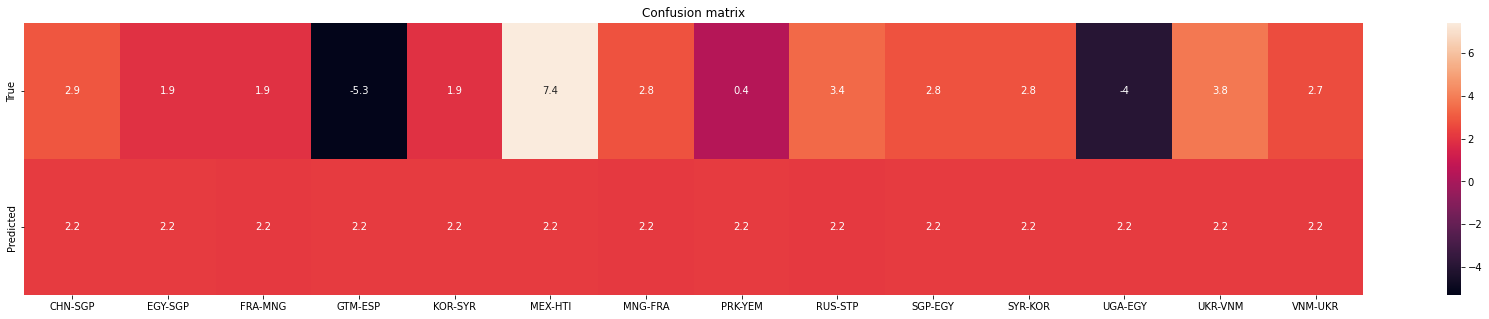

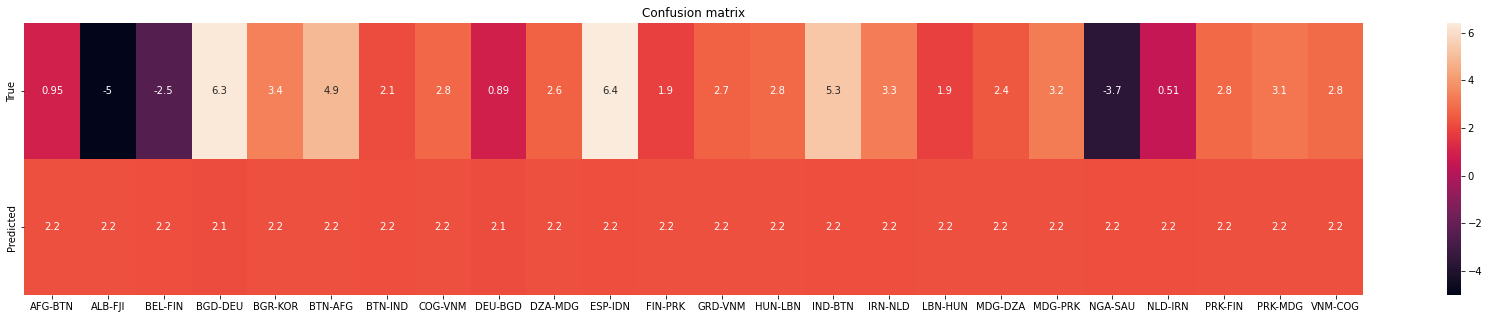

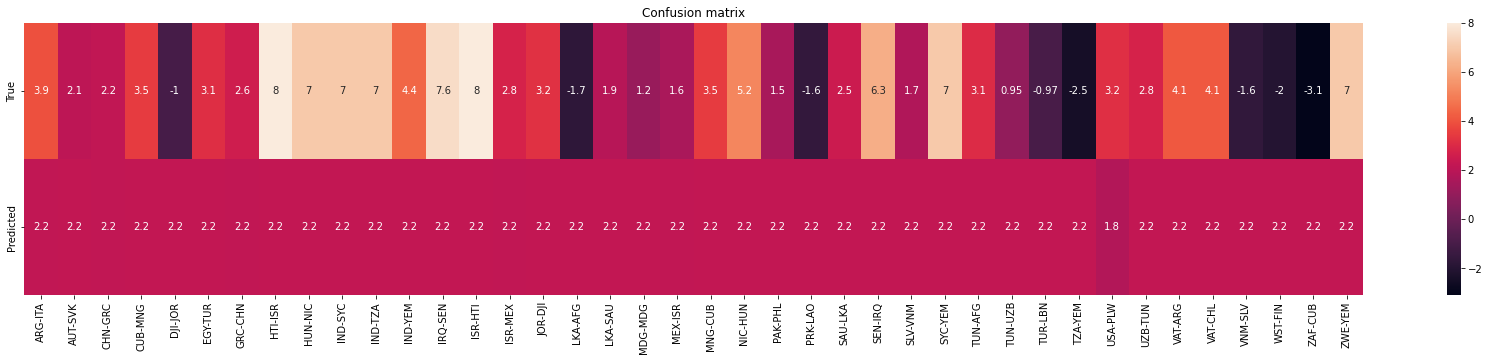

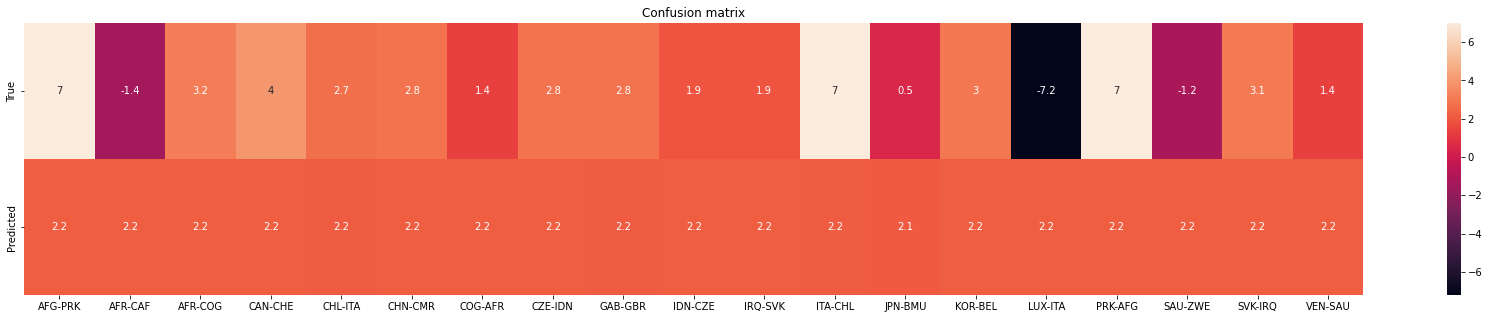

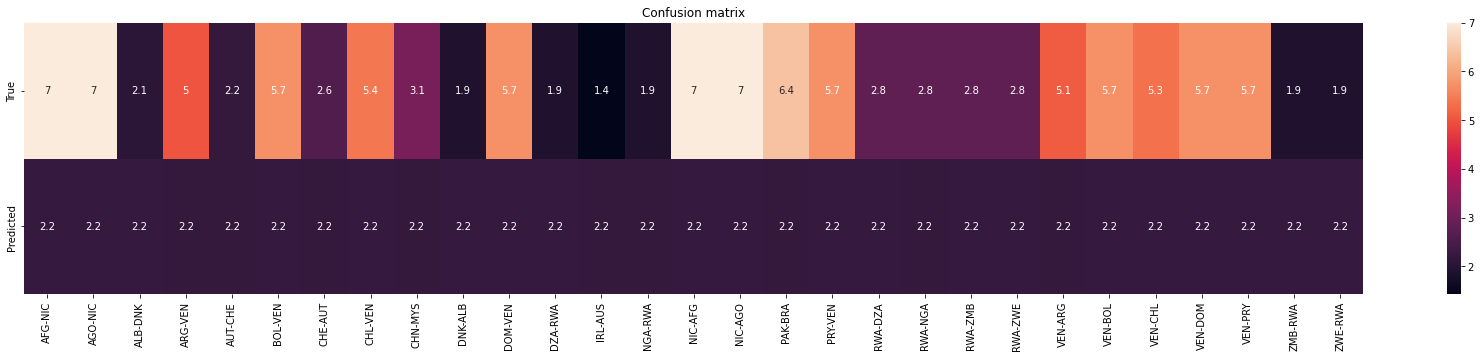

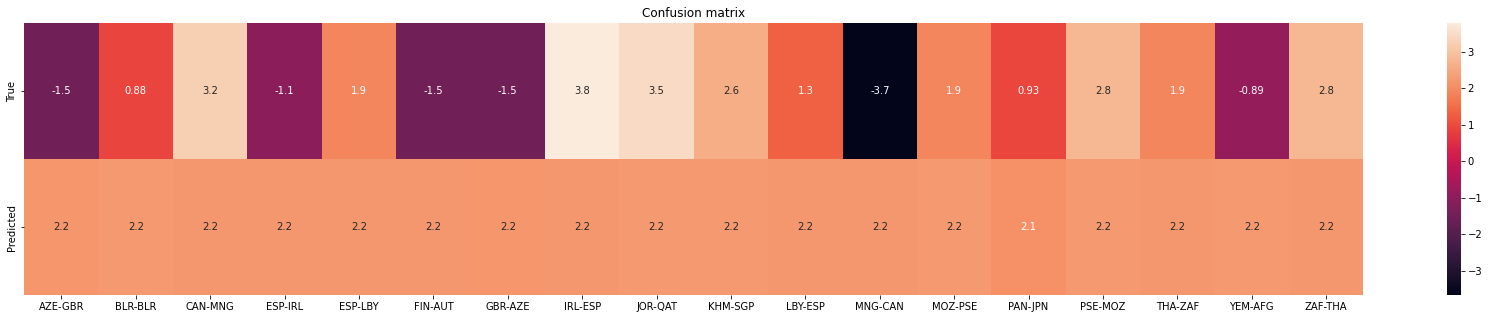

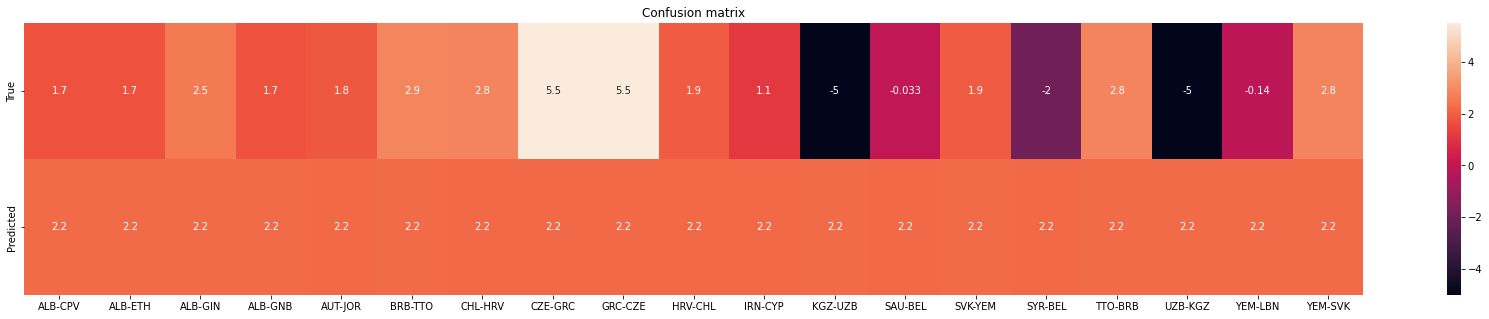

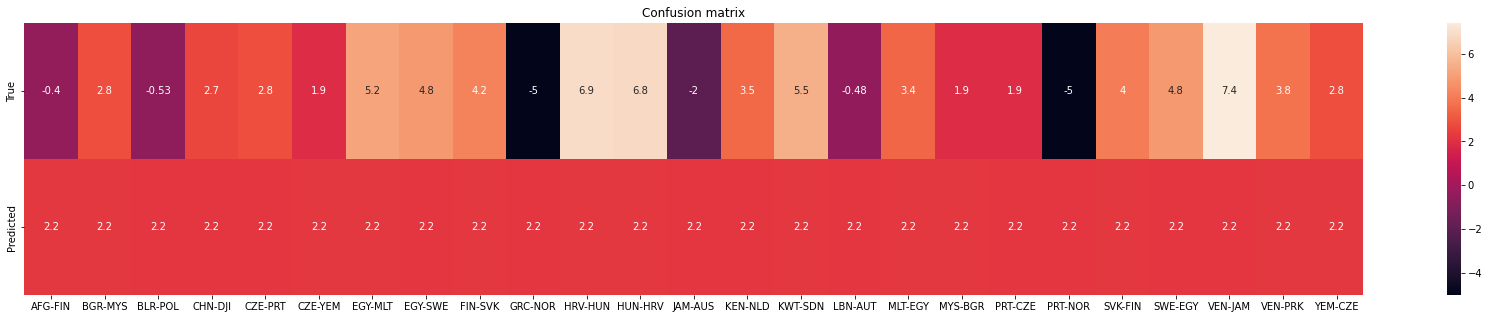

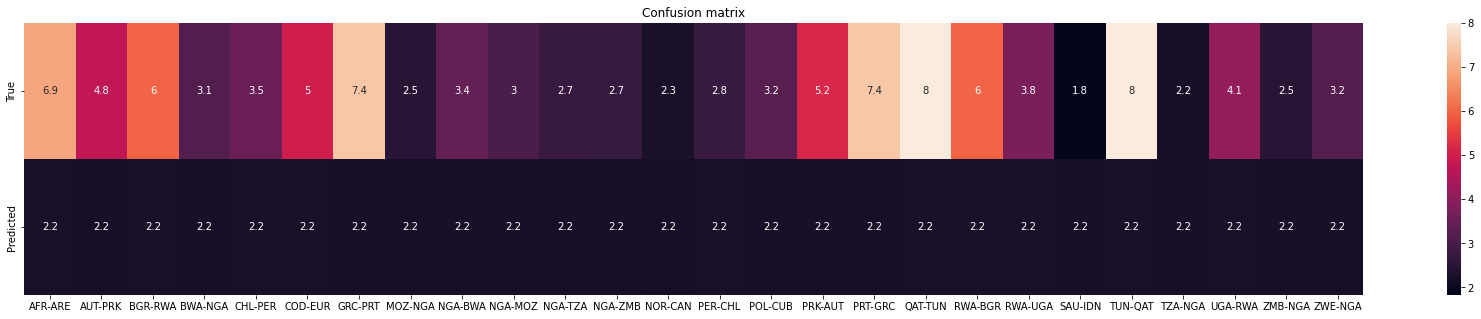

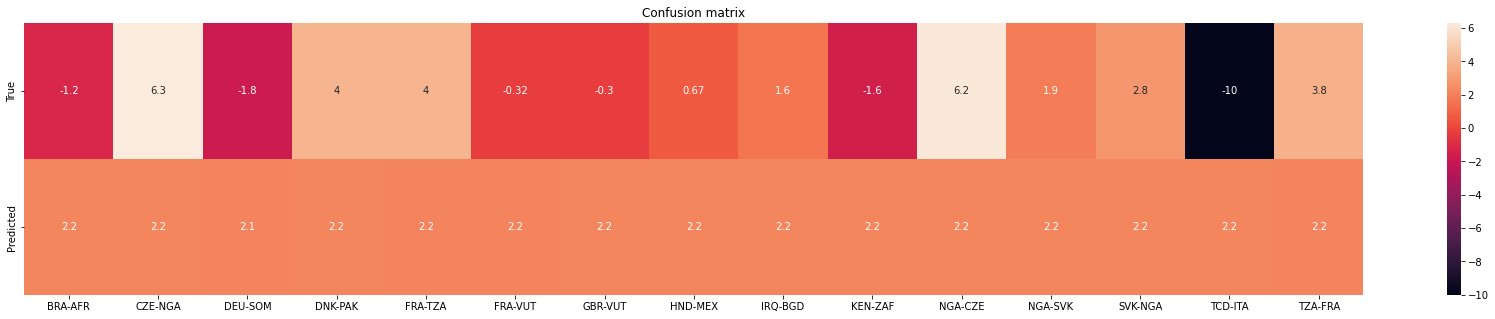

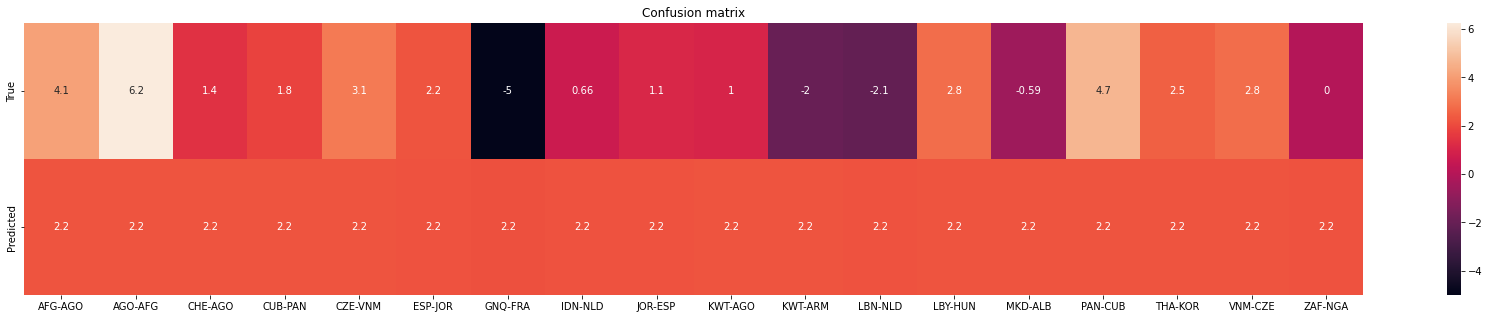

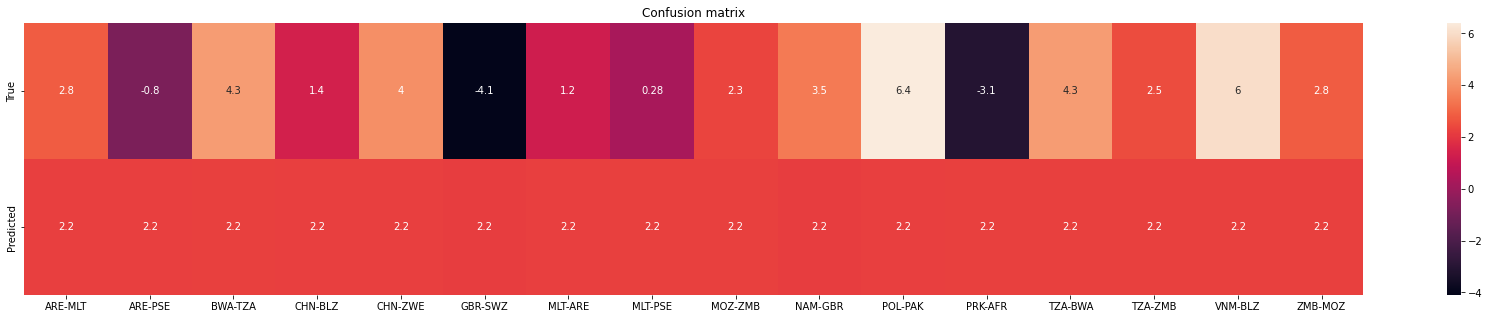

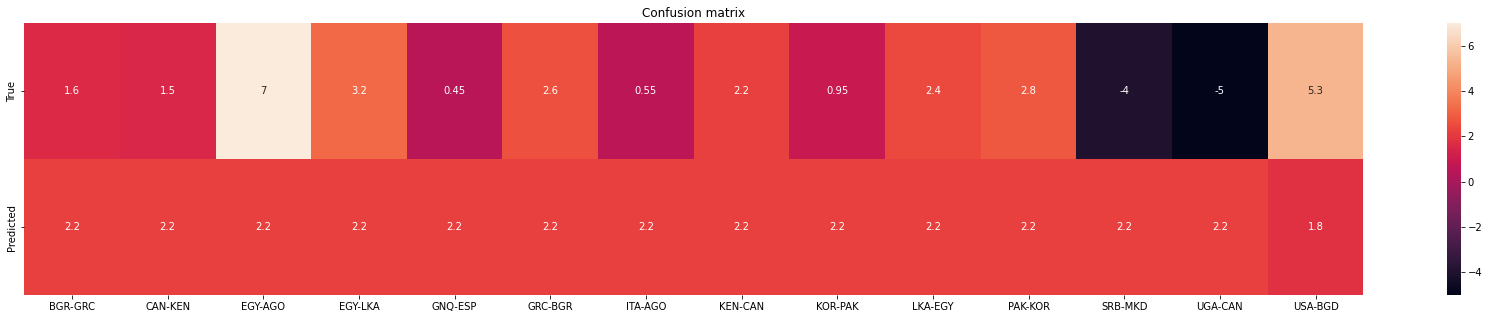

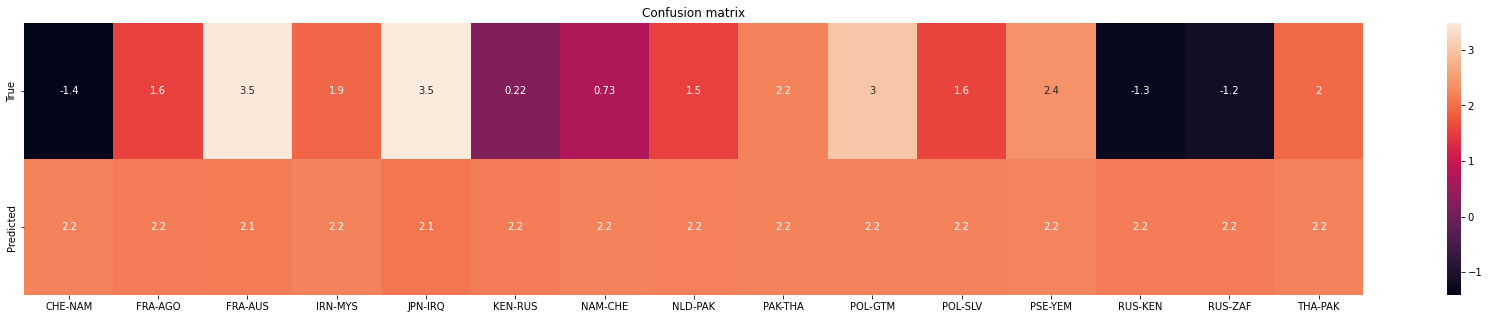

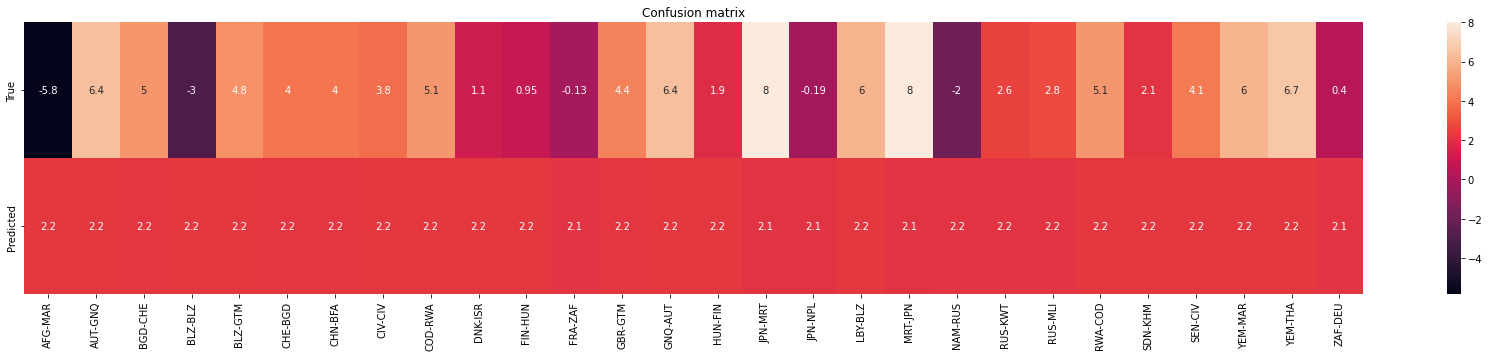

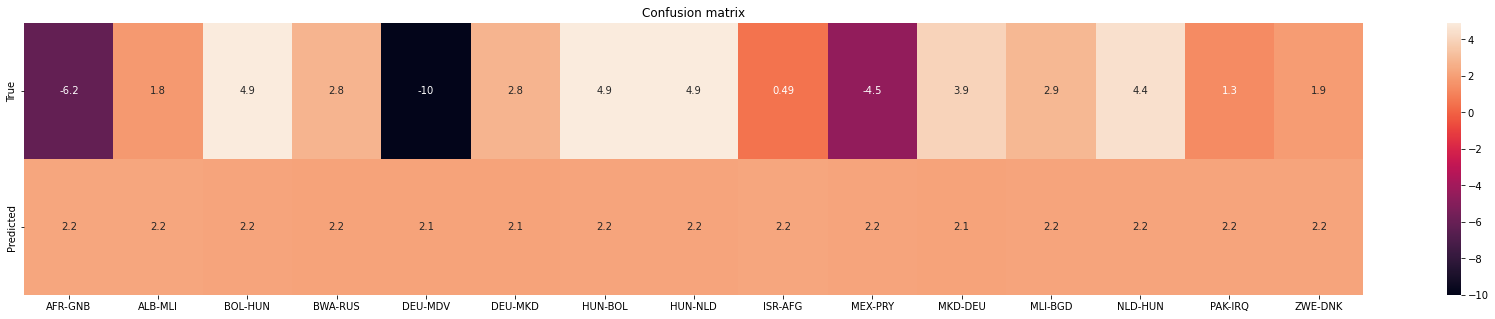

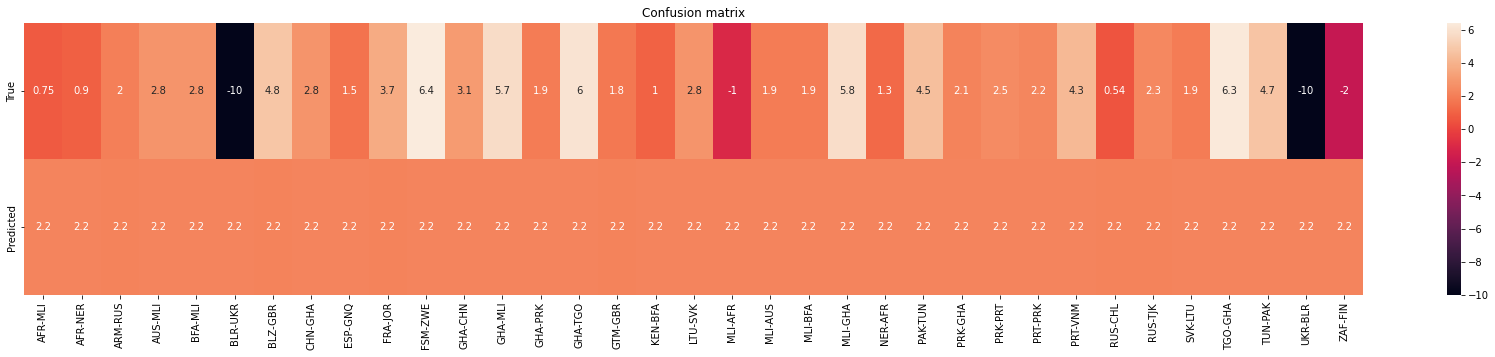

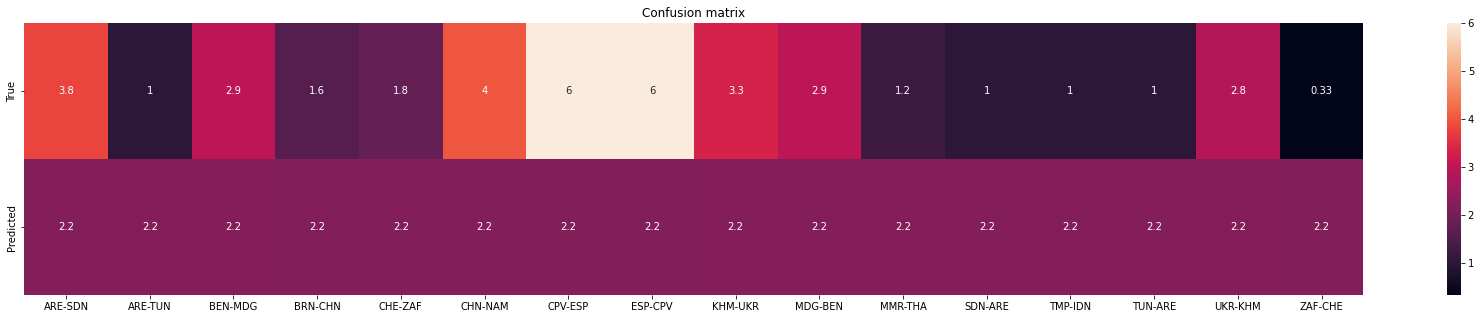

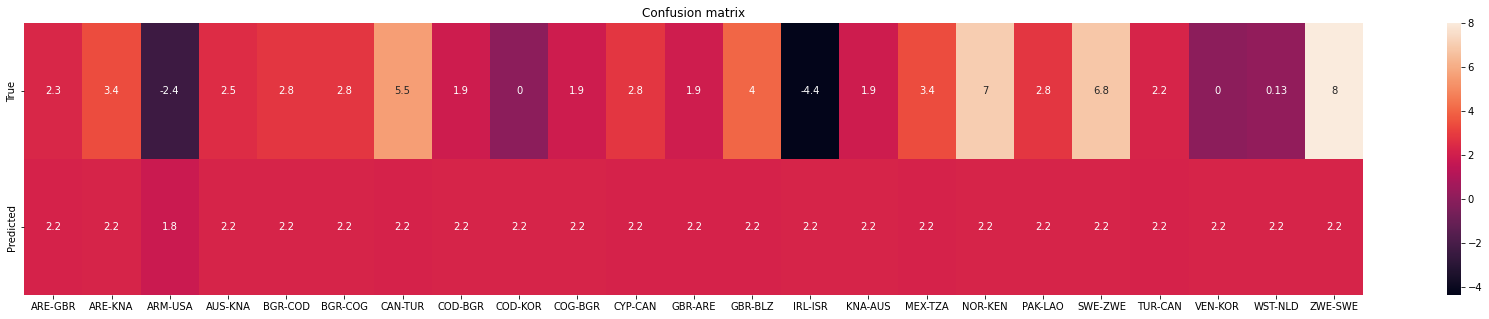

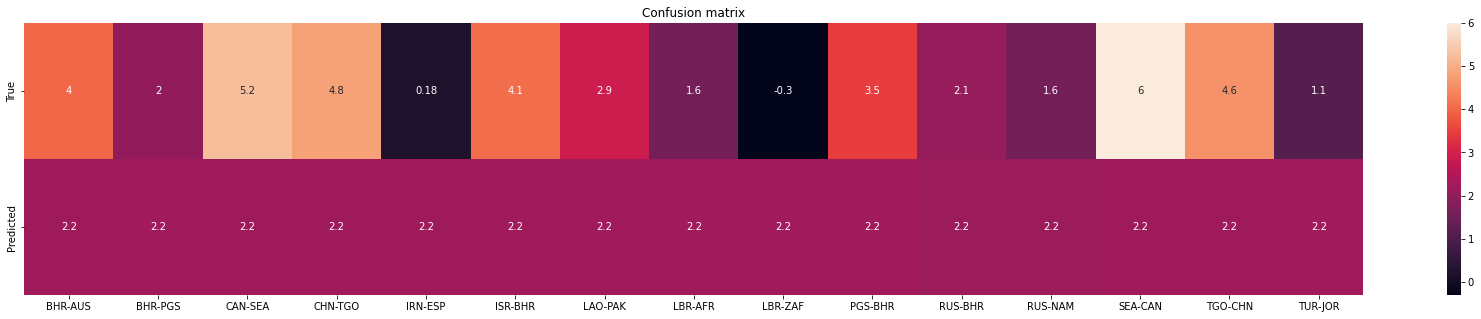

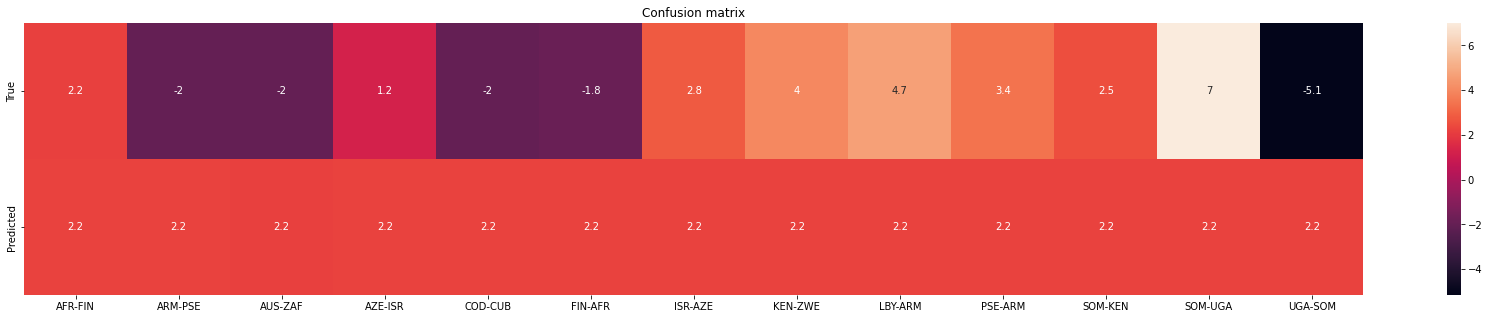

MSE: 10.8293


In [47]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    max_x = torch.nan_to_num(snapshot.x).max()
    X = torch.div(snapshot.x, max_x + 1)
    X = torch.clamp(X, 10e-5, 10e3)
    X = torch.nan_to_num(X)
    max_w = torch.nan_to_num(snapshot.edge_attr).max()
    W = torch.div(snapshot.edge_attr, max_w + 1)
    W = torch.clamp(W, 10e-5, 100)
    W = torch.nan_to_num(W)
    
    y_hat = model(X, snapshot.edge_index, W)
    y_hat = torch.sum(torch.mul(y_hat[snapshot.edge_index[0]], y_hat[snapshot.edge_index[1]]), 1)
    
    y_true = torch.diagonal(snapshot.y[snapshot.edge_index[0]][:, snapshot.edge_index[1]])
    
    plot_confusion_matrix(y_hat, y_true)
    cost = cost + torch.mean((y_hat-y_true)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

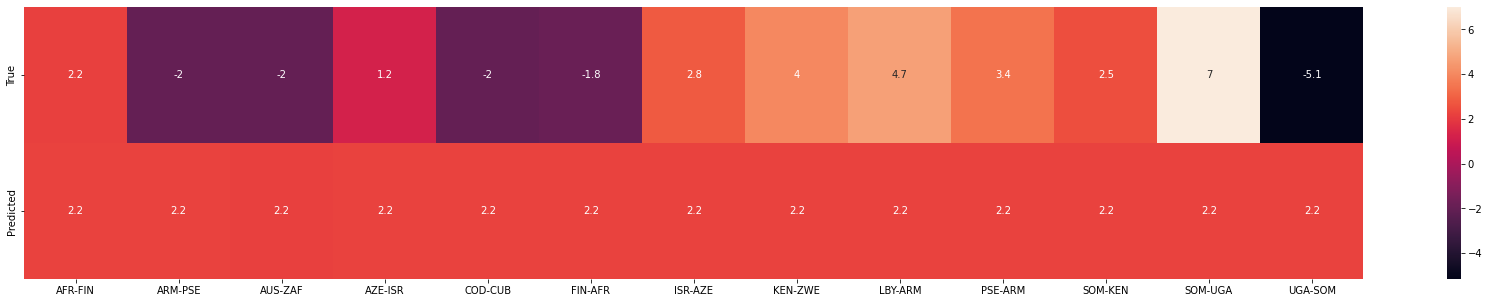

In [12]:
torch.save(model.state_dict(), '../../trained_models/GConvGRU.pt')